# 노드내용 복습

## 내가 원하는 숫자 만들기

### 0. 패키지 로딩하기

In [1]:
from tensorflow.keras import optimizers, losses
from tensorflow.keras import layers, Input, Model

import os
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

### 1. 데이터 준비하기

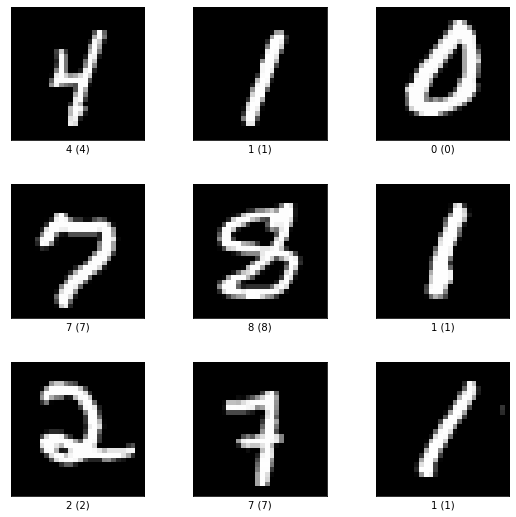

In [2]:
mnist, info = tfds.load("mnist", split = "train", with_info = True)

fig = tfds.show_examples(mnist, info)

* 여러 개의 숫자 이미지와 그에 알맞은 레이블이 출력되었다.
* 학습 전에 필요한 몇 가지 처리를 수행하는 함수를 정의한다.
* 이미지 픽셀값을 -1~1 사이의 범위로 변경하고, 레이블 정보를 원-핫 인코딩(one-hot encoding)했다.
* GAN과 cGAN 각각을 실험해 보기 위해 label 정보 사용 유무에 따라 gan_preprocessing()과 cgan_preprocessing() 두 가지 함수를 구성해 놓았다.

In [3]:
BATCH_SIZE = 128

def gan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    return image

def cgan_preprocessing(data):
    image = data["image"]
    image = tf.cast(image, tf.float32)
    image = (image / 127.5) - 1
    
    label = tf.one_hot(data["label"], 10)
    return image, label

gan_datasets  = mnist.map(gan_preprocessing).shuffle(1000).batch(BATCH_SIZE)
cgan_datasets = mnist.map(cgan_preprocessing).shuffle(100).batch(BATCH_SIZE)

* 원하는 대로 정확히 처리되었는지 한 개 데이터셋만 선택해 확인해본다.
* 이미지에 쓰인 숫자와 레이블이 일치해야 하고, 이미지 값의 범위가 -1~1 사이에 있어야 한다.

Label : tf.Tensor([0. 0. 0. 1. 0. 0. 0. 0. 0. 0.], shape=(10,), dtype=float32)
Image Min / Max : -1.0 1.0


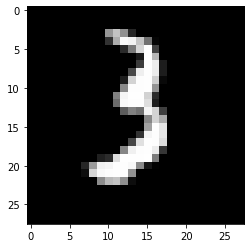

In [4]:
for i, j in cgan_datasets: break
    
# 이미지 i와 라벨 j가 일치하는지 확인해 본다.
print("Label :", j[0])
print("Image Min / Max :", i.numpy().min(), i.numpy().max())
plt.imshow(i.numpy()[0, ..., 0], plt.cm.gray)

# 원-핫 인코딩으로 표현된 Label과 출력된 이미지가 일치하는지 확인해야하므로, 보는 법을 알아보자.
# 0과 1로 이루어진 원-핫 벡터에는 각자 고유의 인덱스가 있습니다.
# MNIST의 경우, 숫자 0은 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.], 숫자 6은 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]의 값을 가진다.
# 이제 위 코드의 output을 확인해 이미지 i와 라벨 j가 일치하는지 확인해본다.

### 2. GAN Generator 구성하기

* 이번 구현은 Tensorflow2의 Subclassing 방법을 이용한다.
* Subclassing 방법은 tensorflow.keras.Model 을 상속받아 클래스를 만들며, 일반적으로 __init__() 메서드 안에서 레이어 구성을 정의하고, 구성된 레이어를 call() 메서드에서 사용해 forward propagation을 진행한다.
* 이러한 Subclassing 방법은 Pytorch의 모델 구성 방법과도 매우 유사하므로 이에 익숙해진다면 Pytorch의 모델 구성 방법도 빠르게 습득할 수 있다고 한다.

In [5]:
# 먼저 GAN의 Generator를 아래와 같이 구현했다.
class GeneratorGAN(Model):
    def __init__(self):
        super(GeneratorGAN, self).__init__()
        
        self.dense_1 = layers.Dense(128,         activation = "relu")
        self.dense_2 = layers.Dense(256,         activation = "relu")
        self.dense_3 = layers.Dense(512,         activation = "relu")
        self.dense_4 = layers.Dense(28 * 28 * 1, activation = "tanh")
        
        self.reshape = layers.Reshape((28, 28, 1))
        
    def call(self, noise):
        out = self.dense_1(noise)
        out = self.dense_2(out)
        out = self.dense_3(out)
        out = self.dense_4(out)
        return self.reshape(out)

* __init__() 메서드 안에서 사용할 모든 레이어를 정의했다.
* 4개의 fully-connected 레이어 중 한 개를 제외하고 모두 ReLU 활성화를 사용하는 것을 확인할 수 있다.
* call() 메서드에서는 노이즈를 입력받아 __init__()에서 정의된 레이어들을 순서대로 통과한다.
* Generator는 숫자가 쓰인 이미지를 출력해야 하므로 마지막 출력은 layers.Reshape()을 이용해 (28,28,1) 크기로 변환된다.

### 3. cGAN Generator 구성하기

In [6]:
class GeneratorCGAN(Model):
    def __init__(self):
        super(GeneratorCGAN, self).__init__()
        
        self.dense_z        = layers.Dense(256,         activation = "relu")
        self.dense_y        = layers.Dense(256,         activation = "relu")
        self.combined_dense = layers.Dense(512,         activation = "relu")
        self.final_dense    = layers.Dense(28 * 28 * 1, activation = "tanh")
        self.reshape        = layers.Reshape((28, 28, 1))
        
    def call(self, noise, label):
        noise = self.dense_z(noise)
        label = self.dense_y(label)
        out   = self.combined_dense(tf.concat([noise, label], axis = -1))
        out   = self.final_dense(out)
        return self.reshape(out)

* GAN의 Generator보다 구현이 복잡한듯 하지만 , cGAN을 이해한 대로 두 구조의 차이점은 레이블 정보가 추가된다는 것 뿐이다.

### 4. GAN Discriminator 구성하기

* 이전에(2번에서) 임의 노이즈 및 레이블 정보로부터 숫자 이미지를 생성하는 Generator를 구현했다.
* 이번에는 실제 이미지와 Generator가 생성한 이미지에 대해 진짜와 가짜를 식별하는 Discriminator를 구현해 보겠다.
* 먼저 GAN의 Discriminator를 아래와 같이 구현한다.

In [7]:
class DiscriminatorGAN(Model):
    def __init__(self):
        super(DiscriminatorGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.blocks = []
        for f in [512, 256, 128, 1]:
            self.blocks.append(layers.Dense(f, activation = None if f == 1 else "relu"))
            
    def call(self, x):
        x = self.flatten(x)
        for block in self.blocks:
            x = block(x)
        return x

* 여기에서는 __init__()에 blocks라는 리스트를 하나 만들어 놓고, for loop를 이용하여 필요한 레이어들을 쌓아놓았다.
* 이러한 방식을 이용하면 각각의 fully-connected 레이어를 매번 정의하지 않아도 되므로 많은 레이어가 필요할 때 편리하다.
* Discriminator의 입력은 Generator가 생성한 (28,28,1) 크기의 이미지이다.
* 이를 fully-connected 레이어로 학습하기 위해 call()에서는 가장 먼저 layers.Flatten()이 적용된다.
* 이어서 레이어들이 쌓여있는 blocks에 대해 for loop를 이용하여 레이어들을 순서대로 하나씩 꺼내 입력 데이터를 통과시킨다.
* 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력된다.

### 5. cGAN Discriminator 구성하기

* 다음으로 구현할 cGAN의 Discriminator는 Maxout이라는 특별한 레이어가 사용된다.
* Maxout은 간단히 설명하면 두 레이어 사이를 연결할 때, 여러 개의 fully-connected 레이어를 통과시켜 그 중 가장 큰 값을 가져오도록 한다.

In [8]:
# 아래 코드와 같이 Maxout을 구성할 수 있다.
# tensorflow.keras.layers.Layer를 상속받아 레이어를 정의했다.
# 이전에 모델을 정의한 것과 비슷하게 __init__(), call() 메서드를 구성한다.

class Maxout(layers.Layer):
    def __init__(self, units, pieces):
        super(Maxout, self).__init__()
        self.dense   = layers.Dense(units * pieces, activation = "relu")
        self.dropout = layers.Dropout(0.5)
        self.reshape = layers.Reshape((-1, pieces, units))
        
    def call(self, x):
        x = self.dense(x)
        x = self.dropout(x)
        x = self.reshape(x)
        return tf.math.reduce_max(x, axis = 1)

* Maxout 레이어를 구성할 때 units과 pieces의 설정이 필요하며, units 차원 수를 가진 fully-connected 레이어를 pieces개 만큼 만들고 그 중 최대 값을 출력한다.
* 예를 들어, 사용할 Maxout 레이어가 units = 100, pieces = 10으로 설정 된다면 입력으로부터 100차원의 representation을 10개 만들고, 10개 중에서 최대값을 가져와 최종 1개의 100차원 representation이 출력된다.

In [9]:
# 위에서 정의한 Maxout 레이어를 3번만 사용하면 아래와 같이 쉽게 cGAN의 Discriminator를 구성할 수 있다.
class DiscriminatorCGAN(Model):
    def __init__(self):
        super(DiscriminatorCGAN, self).__init__()
        self.flatten = layers.Flatten()
        
        self.image_block   = Maxout(240, 5)
        self.label_block   = Maxout(50,  5)
        self.combine_block = Maxout(240, 4)
        
        self.dense         = layers.Dense(1, activation = None)
        
    def call(self, image, label):
        image = self.flatten(image)
        image = self.image_block(image)
        label = self.label_block(label)
        x     = layers.Concatenate()([image, label])
        x     = self.combine_block(x)
        return self.dense(x)

* GAN의 Discriminator와 마찬가지로 Generator가 생성한 (28,28,1) 크기의 이미지가 입력되므로, layers.Flatten()이 적용된다.
* 그리고 이미지 입력 및 레이블 입력 각각은 Maxout 레이어를 한번씩 통과한 후 서로 결합되어 Maxout 레이어를 한번 더 통과한다.
* 마지막 fully-connected 레이어를 통과하면 진짜 및 가짜 이미지를 나타내는 1개의 값이 출력된다.

### 6. loss function과 optimizer를 정의하기

* 이전에 정의한 Generator 및 Discriminator를 이용해 MINST를 학습하고 각 모델로 직접 숫자 손글씨를 생성해본다.
* 우선 GAN, cGAN 각각의 모델 학습에 공통적으로 필요한 loss function과 optimizer를 정의한다.
* 진짜 및 가짜를 구별하기 위해 Binary Cross Entropy를 사용하고, Adam optimizer를 이용해 학습하겠다.

In [10]:
bce = losses.BinaryCrossentropy(from_logits = True)

def generator_loss(fake_output):
    return bce(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    return bce(tf.ones_like(real_output), real_output) + bce(tf.zeros_like(fake_output), fake_output)

gene_opt = optimizers.Adam(1e-4)
disc_opt = optimizers.Adam(1e-4)

### 7. GAN으로 MNIST 학습하기

* 이전 단계에서 구성한 GeneratorGAN 및 DiscriminatorGAN 모델 클래스를 이용한다.
* 여기서는 입력으로 사용되는 노이즈를 100차원으로 설정했으며, 하나의 배치 크기 데이터로 모델을 업데이트하는 함수를 아래와 같이 작성했다.

In [11]:
gan_generator     = GeneratorGAN()
gan_discriminator = DiscriminatorGAN()

@tf.function()
def gan_step(real_images):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent = True) as tape:
        # Generator를 이용해 가짜 이미지 생성
        fake_images = gan_generator(noise)
        
        # Discrominator를 이용해 진짜 및 가짜 이미지를 각각 판별
        real_out = gan_discriminator(real_images)
        fake_out = gan_discriminator(fake_images)
        
        # 각 손실(loss)을 계산
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
        
    # gradient 계산
    gene_grad = tape.gradient(gene_loss, gan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, gan_discriminator.trainable_variables)
    
    # 모델 학습
    gene_opt.apply_gradients(zip(gene_grad, gan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, gan_discriminator.trainable_variables))
    
    return gene_loss, disc_loss

* 위 함수를 이용해 우선 10 epoch만큼 학습을 진행해 본다. 100번의 반복마다 각 손실(loss)을 출력하도록 했다.

In [12]:
EPOCHS = 10

for epoch in range(1, EPOCHS + 1):
    for i, images in enumerate(gan_datasets):
        gene_loss, disc_loss = gan_step(images)
        
        if (i + 1) % 100 == 0:
            print(f"[{epoch} / {EPOCHS} EPOCHS, {i + 1} ITER] G : {gene_loss}, D : {disc_loss}")

[1 / 10 EPOCHS, 100 ITER] G : 2.3157103061676025, D : 0.1234799399971962
[1 / 10 EPOCHS, 200 ITER] G : 2.7218523025512695, D : 0.08826900273561478
[1 / 10 EPOCHS, 300 ITER] G : 2.178203821182251, D : 0.15944641828536987
[1 / 10 EPOCHS, 400 ITER] G : 2.383903741836548, D : 0.22383812069892883
[2 / 10 EPOCHS, 100 ITER] G : 4.5948638916015625, D : 0.06619679927825928
[2 / 10 EPOCHS, 200 ITER] G : 4.345541954040527, D : 0.20785383880138397
[2 / 10 EPOCHS, 300 ITER] G : 4.637979507446289, D : 0.12167966365814209
[2 / 10 EPOCHS, 400 ITER] G : 3.469672918319702, D : 0.2261783480644226
[3 / 10 EPOCHS, 100 ITER] G : 3.646026372909546, D : 0.07139185816049576
[3 / 10 EPOCHS, 200 ITER] G : 3.4511077404022217, D : 0.12736719846725464
[3 / 10 EPOCHS, 300 ITER] G : 4.207304954528809, D : 0.14005184173583984
[3 / 10 EPOCHS, 400 ITER] G : 4.169404029846191, D : 0.08218243718147278
[4 / 10 EPOCHS, 100 ITER] G : 4.050513744354248, D : 0.15809515118598938
[4 / 10 EPOCHS, 200 ITER] G : 4.293532848358154, 

* 짧은 시간 학습된 모델을 테스트 해본다.
* 100차원 노이즈 입력을 10개 사용하여 10개의 숫자 손글씨 데이터를 생성해 시각화한다.
* 경고메시지가 출력된다면 그냥 무시해도 된다.

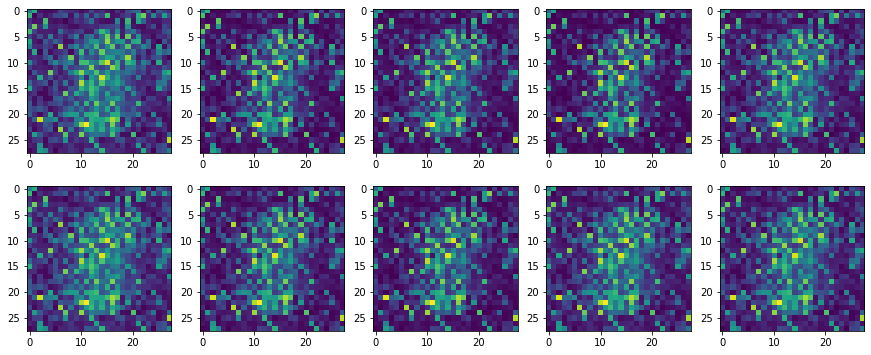

In [13]:
noise = tf.random.normal([10, 100])

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize = (15, 6))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.imshow(output[i - 1])

* 결과를 보니 아마도 10 epoch의 학습만으로는 좋은 결과를 기대할 수 없는 듯 하다.
* 위 구현을 그대로 500 epoch 학습한 가중치를 한번 사용해보자.

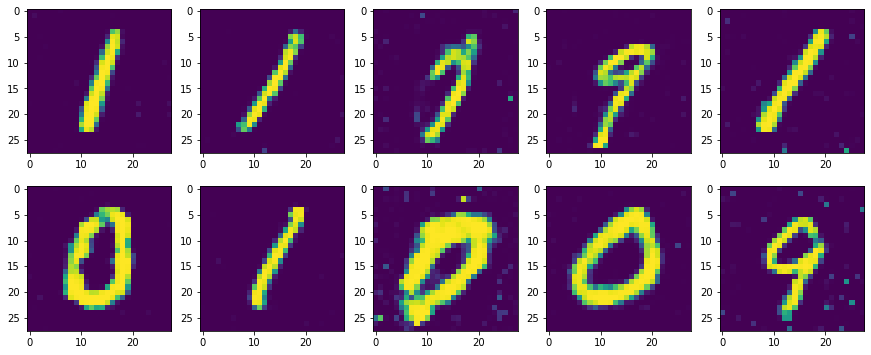

In [14]:
weight_path = os.getenv("HOME") + "/aiffel/conditional_generation/gan/GAN_500"

noise = tf.random.normal([10, 100])

gan_generator = GeneratorGAN()
gan_generator.load_weights(weight_path)

output = gan_generator(noise)
output = np.squeeze(output.numpy())

plt.figure(figsize = (15, 6))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.imshow(output[i - 1])

* 위에 보이는 10개의 결과 이미지는 서로 다른 숫자들이 시각화 됬을 수 있고, 아닐 수 있다.
* 이러한 방법으로는 내가 원하는 특정 숫자 하나를 출력하기 위해 수많은 입력을 넣어야 할 수 있다.
* 내가 원하는 숫자를 바로 얻어내기 위해 cGAN을 학습 시켜본다.

### 8. cGAN으로 MNIST 학습하기

* 이전 단계에서 구성한 GeneratorCGAN 및 DiscriminatorCGAN 모델 클래스를 이용한다.
* 위에서 실행했던 GAN 학습처럼 약간의 학습으로는 제대로 된 생성 결과를 얻을 수 없을 테니 이번에는 연습 삼아 1 epoch만 학습시킨다.

In [15]:
cgan_generator     = GeneratorCGAN()
cgan_discriminator = DiscriminatorCGAN()

@tf.function()
def cgan_step(real_images, labels):
    noise = tf.random.normal([real_images.shape[0], 100])
    
    with tf.GradientTape(persistent = True) as tape:
        fake_images = cgan_generator(noise, labels)
        
        real_out = cgan_discriminator(real_images, labels)
        fake_out = cgan_discriminator(fake_images, labels)
        
        gene_loss = generator_loss(fake_out)
        disc_loss = discriminator_loss(real_out, fake_out)
        
    gene_grad = tape.gradient(gene_loss, cgan_generator.trainable_variables)
    disc_grad = tape.gradient(disc_loss, cgan_discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_grad, cgan_generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_grad, cgan_discriminator.trainable_variables))
    
    return gene_loss, disc_loss

In [16]:
EPOCHS = 1

for epoch in range(1, EPOCHS + 1):
    for i, (images, labels) in enumerate(cgan_datasets):
        gene_loss, disc_loss = cgan_step(images, labels)
        
        if (i + 1) % 100 == 0:
            print(f"[{epoch} / {EPOCHS} EPOCHS, {i} ITER] G : {gene_loss}, D : {disc_loss}")

[1 / 1 EPOCHS, 99 ITER] G : 7.945955276489258, D : 0.005989313591271639
[1 / 1 EPOCHS, 199 ITER] G : 3.4521865844726562, D : 0.05380384996533394
[1 / 1 EPOCHS, 299 ITER] G : 3.8036930561065674, D : 0.06242621690034866
[1 / 1 EPOCHS, 399 ITER] G : 3.811880588531494, D : 0.11078117787837982


* 학습 과정에서 Generator 및 Discriminator에 레이블 정보만 추가로 입력했다는 점을 제외하면 위에서 학습한 GAN과 큰 차이는 없다.
* 위 코드로 짧게나마 학습시켜봤는데, 충분한 학습이 되기엔 더 많은 시간을 투자해야 한다.
* 뒤 에서 학습해야 할 것들이 많이 남아있으니, 시간을 아끼기 위해 위 코드로 500 epoch 학습한 가중치를 사용해보자.

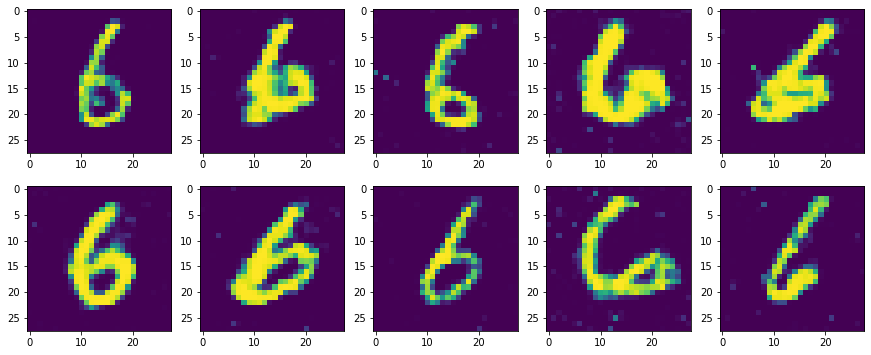

In [17]:
# 코드의 가장 윗줄에 있는 number 라는 변수에 원하는 숫자를 할당하고 코드를 실행시켜본다.
# 경고메시지가 출력된다면 그냥 무시해도 된다.
number = 6 # 원하는 숫자를 입력하기

weight_path = os.getenv("HOME") + "/aiffel/conditional_generation/cgan/CGAN_500"

noise = tf.random.normal([10, 100])

label = tf.one_hot(number, 10)
label = tf.expand_dims(label, axis = 0)
label = tf.repeat(label, 10, axis = 0)

generator = GeneratorCGAN()
generator.load_weights(weight_path)

output = generator(noise, label)
output = np.squeeze(output.numpy())

plt.figure(figsize = (15, 6))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.imshow(output[i - 1])

## 난 스케치를 할 테니 너는 채색을 하거라

### 0. 패키지 로딩하기

In [18]:
from tensorflow import image
from tensorflow import data
from tensorflow import losses
from tensorflow.keras import optimizers
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.preprocessing.image import random_rotation

import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 1. 데이터 준비하기

* 이번에는 pix2pix 모델에 대해서 직접 구현하고 실험해본다. 
* 사용할 데이터셋은 Sketch2Pokemon이라는 데이터셋이다.
* 이 데이터셋은 학습용 데이터 셋에 830개의 이미지가 있으며, 각 (256x256) 크기의 이미지 쌍이 나란히 붙어 (256x512) 크기의 이미지로 구성되어 있다고 한다.

In [19]:
data_path = os.getenv("HOME") + "/aiffel/conditional_generation/pokemon_pix2pix_dataset/train/"
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 830


* 이번에는 각각의 이미지들이 어떻게 생겼는지 확인해본다.
* 학습용 데이터셋에서 임의로 6장을 선택하여 시각화한다.

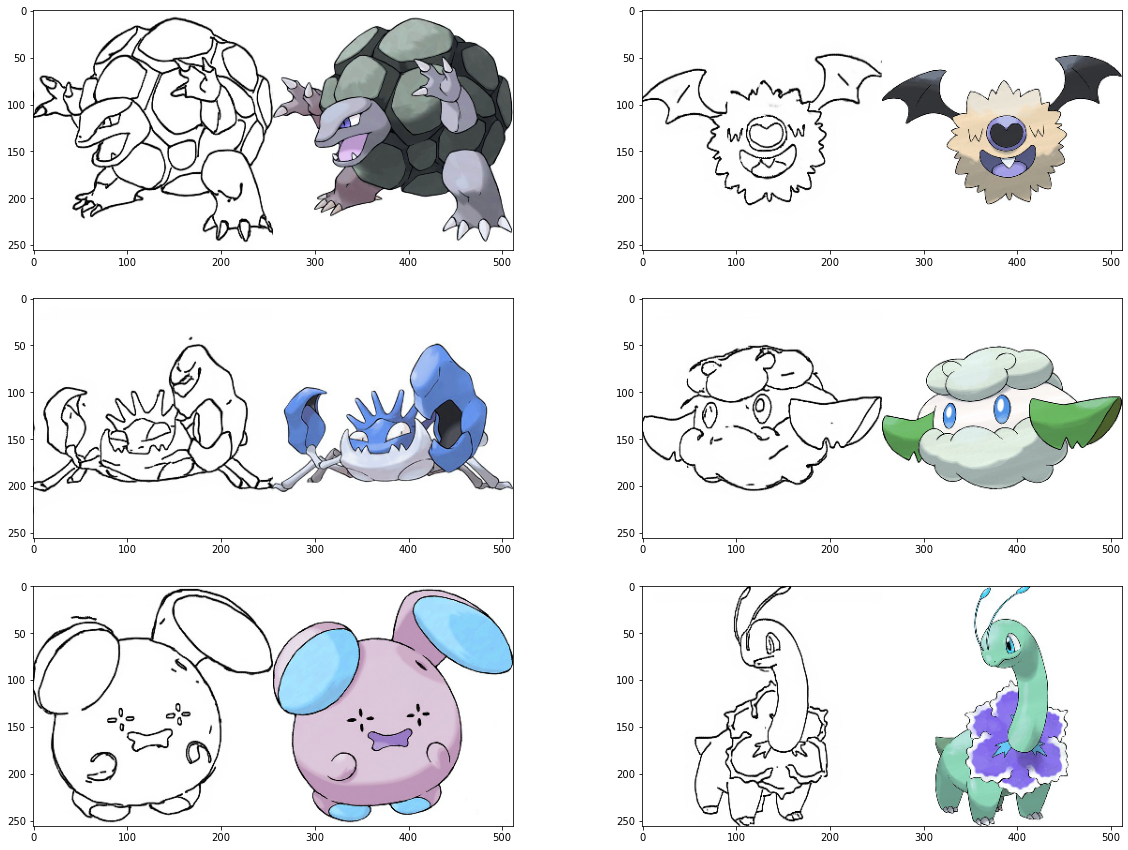

In [20]:
plt.figure(figsize = (20, 15))
for i in range(1, 7):
    f   = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3, 2, i)
    plt.imshow(img)

* 하나의 이미지에 포켓몬 스케치와 실제 포켓몬 이미지가 함께 포함되어 있음을 확인할 수 있다.
* 위 코드를 여러번 반복 실행해 보면 일부는 제대로 스케치 되지 않은 이미지도 확인할 수 있다.
* 출처를 확인해보니 직접 그려서 만든 데이터셋이 아닌 스케치 생성 모델을 이용해서 만들었다고 한다.
* 이미지를 하나 열어 크기를 확인해 보겠다.

In [21]:
f   = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


* (256, 512, 3)으로 확인된다.
* 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하면 되겠다.
* 아래 코드로 이미지를 나누었다.

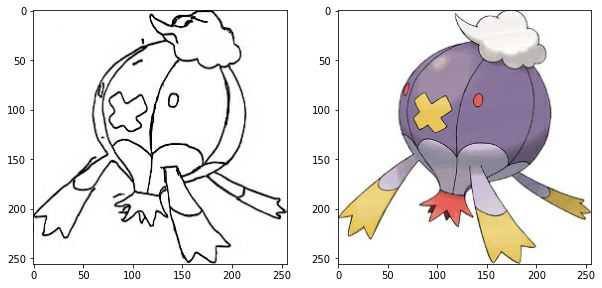

In [22]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x / 127.5) - 1

def denormalize(x):
    x = (x + 1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w       = tf.shape(img)[1] // 2
    sketch  = img[:, :w, :]
    sketch  = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :]
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize = (10, 7))

plt.subplot(1, 2, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 2, 2)
plt.imshow(denormalize(colored))

* 위와 같이 두 개 이미지로 나누었다.
* 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표이다.
* 앞서 봤듯이 학습에 사용할 수 있는 데이터의 수는 약 800개뿐이다.
* 학습에 사용하는 데이터의 다양성을 높이기 위해 여러 augmentation 방법을 적용해 보겠다.

In [23]:
@tf.function() # 빠른 텐서플로 연산을 위해 사용한다.
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis = -1)
    
    _pad = tf.constant([[30, 30], [30, 30], [0, 0]])
    
    if tf.random.uniform(()) < 0.5:
        padded = tf.pad(stacked, _pad, "REFLECT")
        
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values = 1.)
        
    out = image.random_crop(padded, size = [256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < 0.5:
        degree = tf.random.uniform([], minval = 1, maxval = 4, dtype = tf.int32)
        out    = image.rot90(out, k = degree)
        
    return out[..., :3], out[..., 3:]

* apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용한다.
* 위에서 정의한 apply_augmentation 함수에 두 이미지가 입력되면 어떠한 과정을 거치는지 순서대로 적어보자.
* 1. 두 이미지가 채널 축으로 연결된다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 된다.
* 2. 1의 결과가 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용된다.
* 3. 2의 결과에서 (256, 256, 6) 크기를 가진 이미지를 임의로 잘라낸다. (tf.image.random_crop)
* 4. 3의 결과를 50% 확률로 가로로 뒤집는다. (tf.image.random_flip_left_right)
* 5. 4의 결과를 50% 확률로 세로로 뒤집는다. (tf.image.random_flip_up_down)
* 6. 5의 결과를 50% 확률로 회전시킨다. (tf.image.rot90)
* 위와 같이 구성한 함수를 데이터에 적용해 시각화 해본다.

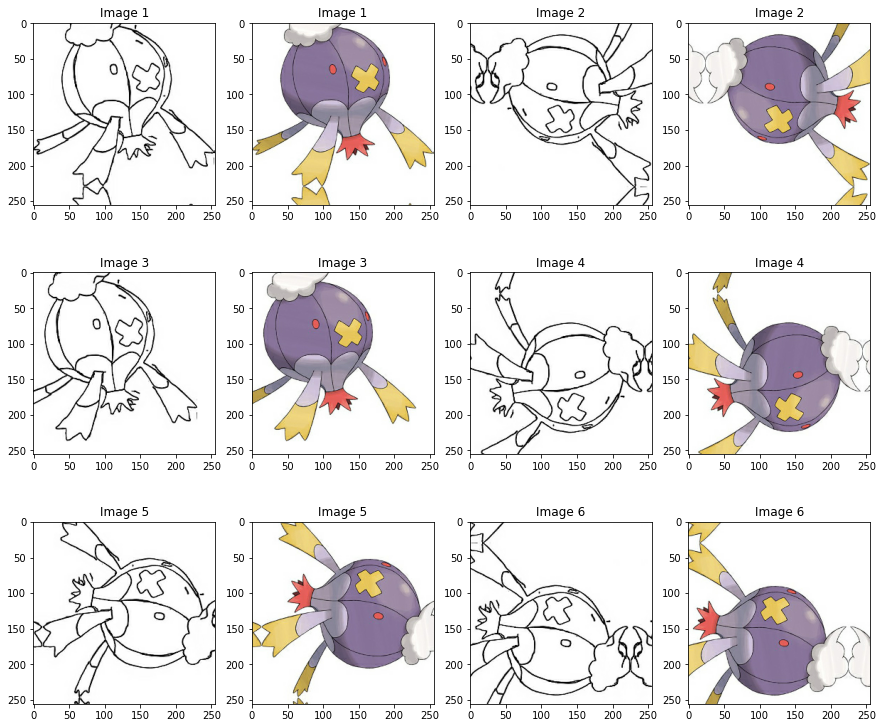

In [24]:
plt.figure(figsize = (15, 13))
img_n = 1

for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3, 4, i)
    plt.imshow(denormalize(augmented_sketch))
    plt.title(f"Image {img_n}")
    
    plt.subplot(3, 4, i + 1)
    plt.imshow(denormalize(augmented_colored))
    plt.title(f"Image {img_n}")
    
    img_n += 1

* 다양한 이미지가 생성된다.
* 여기서 사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 더욱더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대해 볼 수 있다.
* 마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해본다.

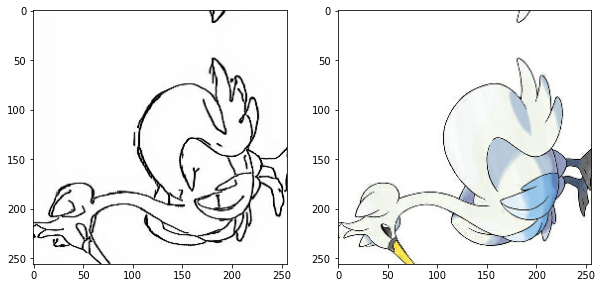

In [25]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample          = train_images.take(1)
sample          = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0] + 1) * 127.5, (sample[0][1] + 1) * 127.5

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sketch[0].astype(np.uint8))

plt.subplot(1, 2, 2)
plt.imshow(colored[0].astype(np.uint8))

### 2. Generator 구성하기

* Generator의 Encoder 부분을 구현해보자.
* 먼저 논문에서 "C64", "C128" 등으로 쓰여진 것과 같이 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었다.

In [26]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn = True):
        super(EncodeBlock, self).__init__()
        self.use_bn    = use_bn
        self.conv      = layers.Conv2D(n_filters, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu     = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

* __init__() 메서드에서 n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정 할 수 있다.
* 이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정했다.
* Encoder에 사용할 기본 블록을 구성했으니 이 블록을 여러번 가져다 사용하면 쉽게 Encoder를 구성할 수 있습니다. (아래 코드)

In [27]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64, 128, 256, 512, 512, 512, 512, 512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn = False))
            else:
                self.blocks.append(EncodeBlock(f))
                
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape = (256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

* 각 블록을 거치면서 사용할 필터의 개수를 filters라는 리스트에 지정했다.
* blocks이라는 리스트에는 사용할 블록들을 정의해 넣어두고, call() 메서드에서 차례대로 블록들을 통과한다.
* Encoder 첫 번째 블록에서는 BatchNorm을 사용하지 않는다.
* get_summary는 레이어가 제대로 구성되었는지 확인하기 위한 용도로 따로 만들어 놓았다.
* 위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴보자.
* 만들어 놓은 get_summary 메서드를 바로 불러오면 된다.

In [28]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

* 블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인 할 수 있다.
* 이번엔 Decoder를 구현한다.
* Encoder와 마찬가지로 사용할 기본 블록을 정의하고, 이 블록을 여러번 반복하여 Decoder를 만든다.

In [29]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout = True):
        super(DecodeBlock, self).__init__()
        self.dropout   = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.relu      = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(0.5)(x)
        return self.relu(x)
    
    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512, 512, 512, 512, 256, 128, 64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout = False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias = False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape = (1, 1, 256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

* 처음 세 개의 블록에서만 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있다.
* 마찬가지로 (1, 1, 512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인해본다.

In [30]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

* (width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256, 256, 3) 크기로 알맞게 출력되었다.
* 위에서 구성한 Encoder와 Decoder를 연결시키면 Encoder에서 (256, 256, 3) 입력이 (1, 1, 512)로 변환되고,
* Decoder를 통과해 다시 원래 입력 크기와 같은 (256, 256, 3)의 결과를 얻을 수 있다.
* 스케치를 입력으로 이런 연산 과정을 통해 채색된 이미지 출력을 얻을 수 있다.
* 아래 코드와 같이 tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성했다.

In [31]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_summary(self, input_shape = (256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [32]:
EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


### 3. Generator 재구성하기

* 지금까지 Encoder와 Decoder를 연결시켜 Generator를 만들어 봤다.
* 하지만 Pix2Pix의 Generator 구조는 두 가지를 제안했다.
* 더 좋은 결과를 기대하기 위해 이전에 구현했던 것들을 조금 수정하여 U-Net 구조를 만들고 실험해본다.
* 먼저 Encoder 및 Decoder에 사용되는 기본적인 블록은 이전에 아래 코드와 같이 구현했었다.
* 참고로 아래 단락부터는 두 가지 구조를 각각 "Encoder-Decoder Generator" 및 "U-Net Generator"라는 용어로 구분하여 사용했다.

In [33]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn = True):
        super(EncodeBlock, self).__init__()
        self.use_bn    = use_bn
        self.conv      = layers.Conv2D(n_filters, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu     = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)
    
    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout = True):
        super(DecodeBlock, self).__init__()
        self.dropout   = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.relu      = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(0.5)(x)
        return self.relu(x)

* 여기서 특별히 수정해야 할 부분은 없다. 그대로 가져다가 사용한다.
* 정의된 블록들을 이용해 한 번에 U-Net Generator를 정의한다.
* 아래 모델의 __init__() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, call()에서 forward propagation 하도록 한다.
* 이전 구현에는 없었던 skip connection이 call() 내부에서 어떻게 구현되었는지 잘 확인해보자.

In [34]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64, 128, 256, 512, 512, 512, 512, 512]
        decode_filters = [512, 512, 512, 512, 256, 128, 64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn = False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
                
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout = False))
                
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias = False)
        
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
            
        features = features[:-1]
        
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
            
        x = self.last_conv(x)
        return x
    
    def get_summary(self, input_shape = (256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

* 먼저, __init__()에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행한다.
* 이때, Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았다.
* 이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데,
* features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용된다.
* 코드의 call() 내에서 "features = features[:-1]"가 필요한 이유는 Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력 (feature 리스트의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아니기 때문이다.
* 그리고 코드의 call() 내의 Decoder 연산 부분에서 features[::-1]가 필요한 이유는 Skip connection은 encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는 등 대칭을 이루기 때문이다. features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례때로 사용하기 위해서 features의 역순으로 연결한다.
* 이제 Generator 구현이 끝났다.
* 마지막으로 완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 확인해본다.

In [35]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

### 4. Discriminator 구성하기

* Discriminator에 사용할 기본적인 블록부터 만든다.

In [36]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride = 2, custom_pad = False, use_bn = True, act = True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn     = use_bn
        self.act        = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv    = layers.Conv2D(n_filters, 4, stride, "valid", use_bias = False)
        else:
            self.conv    = layers.Conv2D(n_filters, 4, stride, "same",  use_bias = False)
            
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu     = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
            
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
            
        return x

* __init__() 에서 필요한 만큼 많은 설정을 가능하게끔 했다.
* 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능하다.

* Discriminator를 표현한 그림을 찾아보면 마지막 2개 블록의 출력은 입력에 비해 (width, height) 크기가 1씩 감소한다는 것을 알 수 있다.
* 1씩 감소시키기 위한 방법을 자세히 보자.
* (128, 128, 32) 크기의 입력이 layers.ZeroPadding2D()를 통과하면, width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어난다.
* 출력 : (130, 130, 32)
* 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어든다.
* 이는 OutSize = (InSize + 2 ∗ PadSize − FilterSize) / Stride + 1의 식으로 계산할 수 있다.
* 채널 수는 사용한 필터 개수와 같다.
* 출력 : (127, 127, 64)
* 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않는다.
* 간단하게 코드를 작성하여 각 출력의 크기가 맞는지 확인해 본다.

In [37]:
inputs = Input((128, 128, 32))

out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias = False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


* 이런 코드와 비슷한 설정으로 (width, height) 크기를 1씩 감소시킬 수 있다.
* 마지막 2개 블록은 출력의 크기가 1씩 감소하므로 이런 방식을 적용하면 된다.
* Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30, 30) 크기로 맞추느라 위와 같이 조금 복잡한 과정을 설명했다.
* 사용할 기본적인 블록을 만들었으니 이를 이용해 바로 Discriminator를 만들어본다.

In [38]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1  = layers.Concatenate()
        self.block2  = DiscBlock(n_filters = 64,  stride = 2, custom_pad = False, use_bn = False, act = True)
        self.block3  = DiscBlock(n_filters = 128, stride = 2, custom_pad = False, use_bn = True,  act = True)
        self.block4  = DiscBlock(n_filters = 256, stride = 2, custom_pad = False, use_bn = True,  act = True)
        self.block5  = DiscBlock(n_filters = 512, stride = 1, custom_pad = True,  use_bn = True,  act = True)
        self.block6  = DiscBlock(n_filters = 1,   stride = 1, custom_pad = True,  use_bn = False, act = False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters     = [64, 128, 256, 512, 1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters  = f,
        #         strides    = 2 if i < 3 else 1,
        #         custom_pad = False if i < 3 else True,
        #         use_bn     = False if i == 0 and i == 4 else True,
        #         act        = True if i < 4 else False
        #     ))
        
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape = (256, 256, 3), y_shape = (256, 256, 3)):
        x, y = Input(x_shape), Input(y_shape)
        return Model((x, y), self.call(x, y)).summary()

* __init__() 내부에서 사용할 블록들을 정의했는데, 이전의 구현들처럼 (위 코드의 주석 처리된 부분과 같이) for loop로 간편하게 블록을 만들 수도 있지만, 쉽게 코드를 읽게끔 총 6개 블록을 각각 따로 만들었다.
* 첫 번째 블록은 단순한 연결(concat)을 수행하며, Discriminator의 최종 출력은 sigmoid 활성화를 사용했다.
* 각 블록의 출력 크기가 알맞게 되었는지 아래 코드로 확인해본다.

In [39]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

* 시험 삼아 임의의 (256, 256, 3) 크기의 입력을 넣어 나오는 (30, 30) 출력을 시각화해본다.

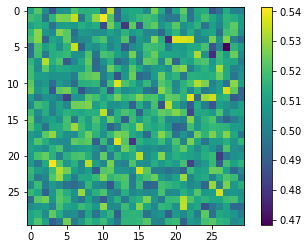

In [40]:
x = tf.random.normal([1,  256, 256, 3])
y = tf.random.uniform([1, 256, 256, 3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ..., 0])
plt.colorbar()

* 위 (30, 30) 크기를 갖는 결과 이미지의 각 픽셀값은 원래 입력의 (70, 70) 패치에 대한 분류 결과이다.
* 전체 입력의 크기가 (256, 256) 이므로, 각각의 (70, 70) 패치는 원래 입력상에서 많이 겹쳐있다.
* 각각의 픽셀값은 sigmoid 함수의 결괏값이므로 0 ~ 1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해내는 데 사용한다.
* 드디어 Pix2Pix를 구성하는 Generator와 Discriminator의 구현이 끝났다.
* 다음은 본격적인 모델 학습을 진행해본다.

### 5. 학습 및 테스트하기

* 이번 단계에서는 구현된 Generator와 Discriminator를 학습시켜보고, 스케치를 입력으로 채색된 이미지를 생성해본다.
* 먼저 학습에 필요한 손실함수부터 정의한다.
* 레이블 정보만 있는 입력에 대해 여러 손실함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성한다고 한다.
* 이번 실험에서도 두 가지 손실 함수를 모두 사용해본다.

In [41]:
bce = losses.BinaryCrossentropy(from_logits = False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss   = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

* Generator 및 Discriminator의 손실 계산을 각각 정의했다.
* Generator의 손실함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있다. 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산한다.
* Discriminator의 손실함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교한다.
* 사용할 optimizer는 논문과 동일하게 설정했다.

In [42]:
gene_opt = optimizers.Adam(2e-4, beta_1 = 0.5, beta_2 = 0.999)
disc_opt = optimizers.Adam(2e-4, beta_1 = 0.5, beta_2 = 0.999)

* 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현했다.

In [43]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training = True)
        
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training = True)
        real_disc = discriminator(sketch, real_colored, training = True)
        
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss    = gene_loss + (100 * l1_loss) # L1 손실 반영 λ = 100
        
        # Discriminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
        
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

* 전반적인 학습 과정은 앞서 진행했었던 cGAN 학습과 크게 다르지 않다.
* 다만 위 코드의 gene_total_loss 계산 라인에서 최종 Generator 손실을 계산할 때, L1 손실에 100을 곱한 부분을 확인할 수 있다.
* λ는 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 λ = 100을 사용했다.
* 앞서 정의한 함수를 이용해서 학습을 진행한다.

In [44]:
EPOCHS = 10

generator     = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS + 1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        # 10회 반복마다 손실을 출력한다.
        if (i + 1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i + 1}] \
                  \nGenerator_loss : {g_loss.numpy():.4f} \
                  \nL1_loss : {l1_loss.numpy():.4f} \
                  \nDiscriminator_loss : {d_loss.numpy():.4f}", 
                  end = "\n\n")

EPOCH[1] - STEP[10]                   
Generator_loss : 0.9509                   
L1_loss : 0.4207                   
Discriminator_loss : 1.2667

EPOCH[1] - STEP[20]                   
Generator_loss : 1.0767                   
L1_loss : 0.2972                   
Discriminator_loss : 1.3113

EPOCH[1] - STEP[30]                   
Generator_loss : 0.8672                   
L1_loss : 0.2749                   
Discriminator_loss : 1.2445

EPOCH[1] - STEP[40]                   
Generator_loss : 1.4103                   
L1_loss : 0.2782                   
Discriminator_loss : 1.1401

EPOCH[1] - STEP[50]                   
Generator_loss : 0.8163                   
L1_loss : 0.2189                   
Discriminator_loss : 1.1128

EPOCH[1] - STEP[60]                   
Generator_loss : 1.3644                   
L1_loss : 0.2633                   
Discriminator_loss : 0.4868

EPOCH[1] - STEP[70]                   
Generator_loss : 1.9599                   
L1_loss : 0.2100                   


EPOCH[3] - STEP[170]                   
Generator_loss : 3.1779                   
L1_loss : 0.2852                   
Discriminator_loss : 0.1201

EPOCH[3] - STEP[180]                   
Generator_loss : 4.0982                   
L1_loss : 0.2751                   
Discriminator_loss : 1.9714

EPOCH[3] - STEP[190]                   
Generator_loss : 2.5936                   
L1_loss : 0.2493                   
Discriminator_loss : 0.6173

EPOCH[3] - STEP[200]                   
Generator_loss : 1.3706                   
L1_loss : 0.2955                   
Discriminator_loss : 1.4399

EPOCH[4] - STEP[10]                   
Generator_loss : 3.2693                   
L1_loss : 0.2582                   
Discriminator_loss : 0.3358

EPOCH[4] - STEP[20]                   
Generator_loss : 1.8179                   
L1_loss : 0.2497                   
Discriminator_loss : 0.3203

EPOCH[4] - STEP[30]                   
Generator_loss : 1.8524                   
L1_loss : 0.2579                

EPOCH[6] - STEP[130]                   
Generator_loss : 1.5751                   
L1_loss : 0.2261                   
Discriminator_loss : 0.3297

EPOCH[6] - STEP[140]                   
Generator_loss : 1.3094                   
L1_loss : 0.3633                   
Discriminator_loss : 0.4589

EPOCH[6] - STEP[150]                   
Generator_loss : 2.3557                   
L1_loss : 0.2918                   
Discriminator_loss : 0.8323

EPOCH[6] - STEP[160]                   
Generator_loss : 0.6332                   
L1_loss : 0.2268                   
Discriminator_loss : 1.2816

EPOCH[6] - STEP[170]                   
Generator_loss : 2.2530                   
L1_loss : 0.2520                   
Discriminator_loss : 0.4928

EPOCH[6] - STEP[180]                   
Generator_loss : 0.4431                   
L1_loss : 0.2269                   
Discriminator_loss : 1.4880

EPOCH[6] - STEP[190]                   
Generator_loss : 2.1194                   
L1_loss : 0.2497             

EPOCH[9] - STEP[90]                   
Generator_loss : 0.5774                   
L1_loss : 0.2340                   
Discriminator_loss : 1.0337

EPOCH[9] - STEP[100]                   
Generator_loss : 0.8476                   
L1_loss : 0.3046                   
Discriminator_loss : 0.7615

EPOCH[9] - STEP[110]                   
Generator_loss : 1.6302                   
L1_loss : 0.2753                   
Discriminator_loss : 0.3432

EPOCH[9] - STEP[120]                   
Generator_loss : 0.6959                   
L1_loss : 0.3143                   
Discriminator_loss : 0.8165

EPOCH[9] - STEP[130]                   
Generator_loss : 1.2735                   
L1_loss : 0.2310                   
Discriminator_loss : 0.4192

EPOCH[9] - STEP[140]                   
Generator_loss : 1.3247                   
L1_loss : 0.2260                   
Discriminator_loss : 0.4418

EPOCH[9] - STEP[150]                   
Generator_loss : 0.8880                   
L1_loss : 0.2327              

* 아래 코드로 짧게나마 학습해 본 모델에 채색을 시켜보자. 아마 마음에 안 들 것이다.

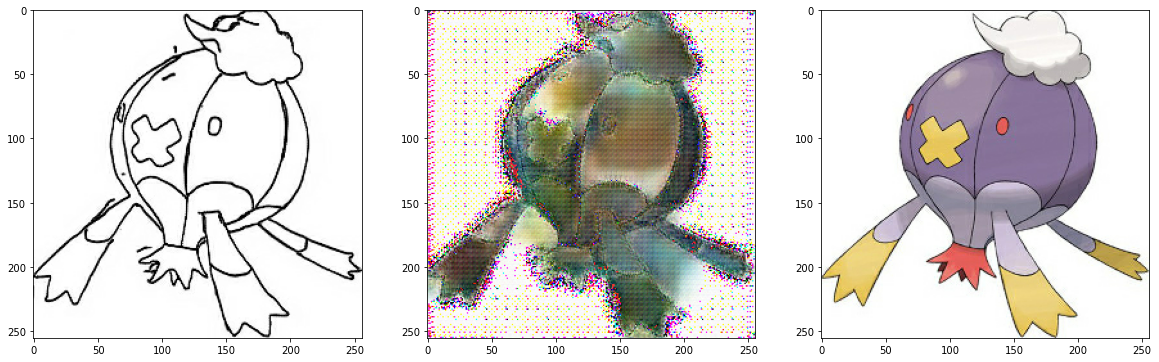

In [45]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize = (20, 10))

plt.subplot(1, 3, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 3, 2)
plt.imshow(pred[0])

plt.subplot(1, 3, 3)
plt.imshow(denormalize(colored))

* 데이터셋을 제공한 출처를 보면, Pix2Pix로 128 epoch 학습 후 테스트 결과도 별로라고 한다.
* 이전 10 epoch 학습의 결과보다는 훨씬 낫지만, 조금 오래 학습했어도 채색해야 할 전체적인 색감 정도만 학습되며 아직까지 세부적으로는 제대로 채색되지 않다는 것을 확인할 수 있다.

# 프로젝트

## Segmentation map으로 도로 이미지 만들기

* 이전 Pix2Pix 논문에서 제시한 결과 중에 도로의 레이블 정보를 활용해 이미지를 생성해낸 결과가 있었다.
* 이번 프로젝트는 위와 같은 데이터셋을 이용해 Pix2Pix를 학습시켜보는 것이다.
* 데이터셋은 1000개의 학습용 이미지 및 5개의 평가 이미지로 구성되어 있다.
* 이전 포켓몬 데이터에서 사용했던 스케치와는 조금 다른 레이블 정보 이미지를 입력으로 사용하기 때문에, 전처리 과정에 대해 약간의 혼란이 있을 수 있지만 크게 다른 과정은 없다.

### 프로젝트 수행
* 프로젝트를 진행하면서 필수로 수행해야 할 사항은 다음과 같다.
* 1. 데이터에 한 가지 이상의 augmentation 방법을 적용하여 학습한다. (어떠한 방법을 사용했는지 적어주세요.)
* 2. 이전에 구현했던 두 개의 Generator 중 Encoder와 Decoder간에 skip connection이 있는 U-Net Generator를 사용한다.
* 3. 모델 학습 후, 학습된 Generator를 이용해 테스트한다. 테스트 데이터는 다운받았던 "val" 폴더 내 이미지를 사용한다.
* 4. 1개 이상의 이미지에 대해 테스트 과정을 거친 후 그 결과를 스케치, 생성된 사진, 실제 사진 순서로 나란히 시각화한다.
* 5. 모델을 충분히 학습하기에 시간이 부족할 수 있다. 적어도 10 epoch 이상 학습하며 중간 손실 값에 대한 로그를 남겨본다. 좋은 결과를 얻기 위해선 긴 학습 시간이 필요하므로 테스트 결과는 만족스럽지 않아도 괜찮다.

### 0. 패키지 로딩하기

In [28]:
from tensorflow import image
from tensorflow import data
from tensorflow import losses
from tensorflow.keras import optimizers
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.preprocessing.image import random_rotation

import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

### 1. 데이터 준비하기

In [29]:
data_path = os.getenv("HOME") + "/aiffel/conditional_generation/cityscapes/train/"
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


* 이번에는 각각의 이미지들이 어떻게 생겼는지 확인해본다.
* 학습용 데이터셋에서 임의로 6장을 선택하여 시각화한다.

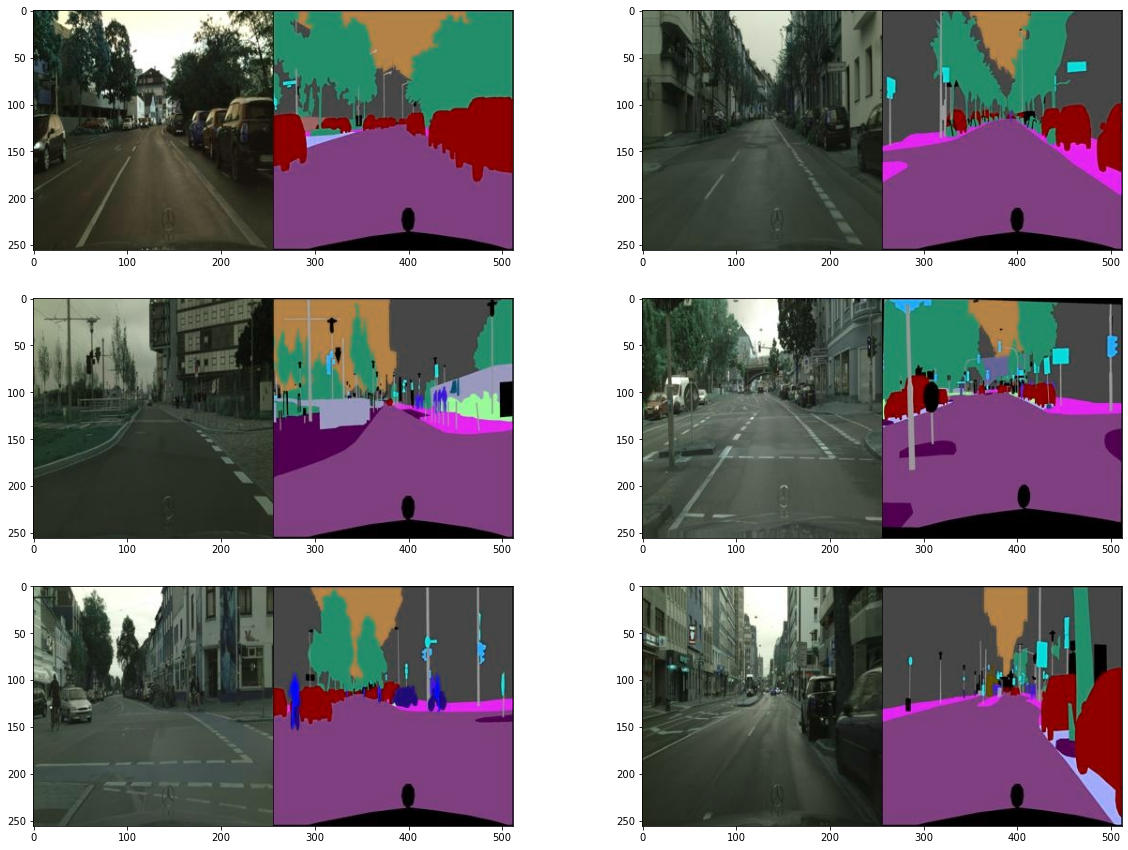

In [30]:
plt.figure(figsize = (20, 15))
for i in range(1, 7):
    f   = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3, 2, i)
    plt.imshow(img)

* 하나의 이미지에 스케치와 실제 이미지가 함께 포함되어 있음을 확인할 수 있다.
* 이미지를 하나 열어 크기를 확인해 보겠다.

In [31]:
f   = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


* (256, 512, 3)으로 확인된다.
* 모델 학습에 사용할 데이터를 (256, 256, 3) 크기의 2개 이미지로 분할하여 사용하면 되겠다.
* 아래 코드로 이미지를 나누었다.

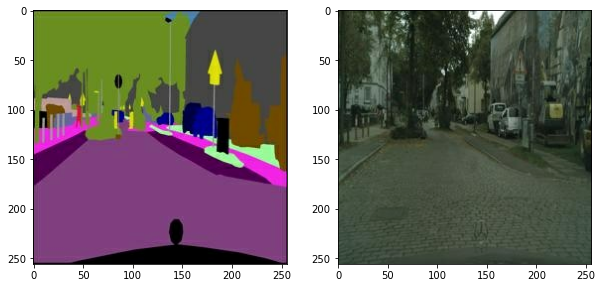

In [32]:
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x / 127.5) - 1

def denormalize(x):
    x = (x + 1) * 127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w       = tf.shape(img)[1] // 2
    colored = img[:, :w, :]
    colored = tf.cast(colored, tf.float32)
    sketch  = img[:, w:, :]
    sketch  = tf.cast(sketch, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize = (10, 7))

plt.subplot(1, 2, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 2, 2)
plt.imshow(denormalize(colored))

* 위와 같이 두 개 이미지로 나누었다.
* 첫 번째 스케치를 다음 단계에서 구성할 Pix2Pix 모델에 입력하여 두 번째 그림과 같은 채색된 이미지를 생성하는 것이 이번 단계의 목표이다.
* 앞서 봤듯이 학습에 사용할 수 있는 데이터의 수는 약 1000개뿐이다.
* 학습에 사용하는 데이터의 다양성을 높이기 위해 여러 augmentation 방법을 적용해 보겠다.

In [33]:
@tf.function() # 빠른 텐서플로 연산을 위해 사용한다.
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis = -1)
    
    _pad = tf.constant([[30, 30], [30, 30], [0, 0]])
    
    if tf.random.uniform(()) < 0.5:
        padded = tf.pad(stacked, _pad, "REFLECT")
        
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values = 1.)
        
    out = image.random_crop(padded, size = [256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < 0.5:
        degree = tf.random.uniform([], minval = 1, maxval = 4, dtype = tf.int32)
        out    = image.rot90(out, k = degree)
        
    return out[..., :3], out[..., 3:]

* apply_augmentation 함수는 스케치 및 채색된 2개 이미지를 입력으로 받아 여러 가지 연산을 두 이미지에 동일하게 적용한다.
* 위에서 정의한 apply_augmentation 함수에 두 이미지가 입력되면 어떠한 과정을 거치는지 순서대로 적어보자.
* 1. 두 이미지가 채널 축으로 연결된다. (tf.concat). 두 이미지가 각각 3채널인 경우 6채널이 된다.
* 2. 1의 결과가 각 50% 확률로 Refection padding 또는 constant padding이 30픽셀의 pad width 만큼 적용된다.
* 3. 2의 결과에서 (256, 256, 6) 크기를 가진 이미지를 임의로 잘라낸다. (tf.image.random_crop)
* 4. 3의 결과를 50% 확률로 가로로 뒤집는다. (tf.image.random_flip_left_right)
* 5. 4의 결과를 50% 확률로 세로로 뒤집는다. (tf.image.random_flip_up_down)
* 6. 5의 결과를 50% 확률로 회전시킨다. (tf.image.rot90)
* 위와 같이 구성한 함수를 데이터에 적용해 시각화 해본다.

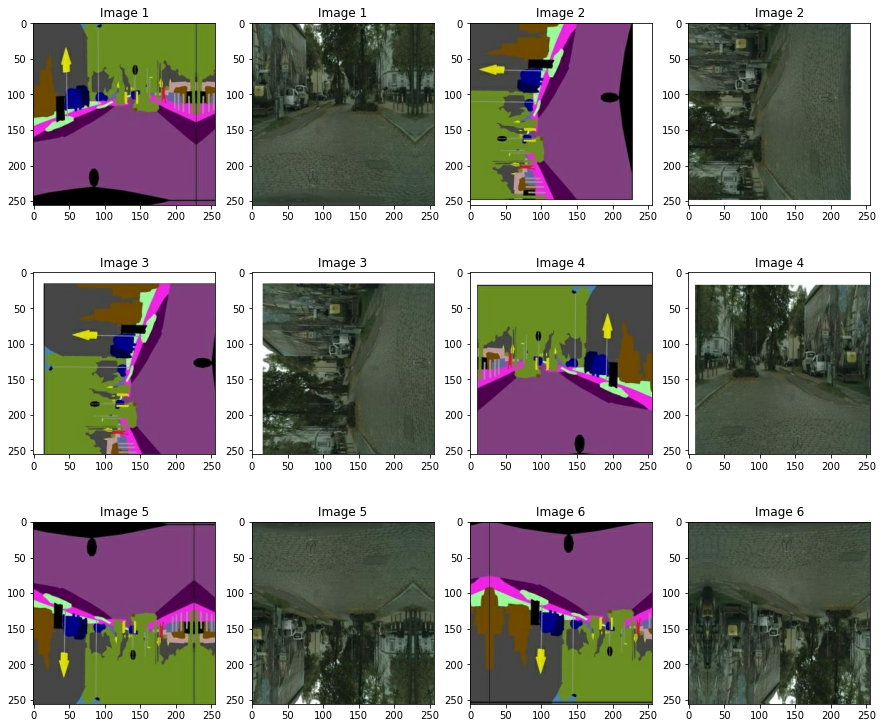

In [34]:
plt.figure(figsize = (15, 13))
img_n = 1

for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3, 4, i)
    plt.imshow(denormalize(augmented_sketch))
    plt.title(f"Image {img_n}")
    
    plt.subplot(3, 4, i + 1)
    plt.imshow(denormalize(augmented_colored))
    plt.title(f"Image {img_n}")
    
    img_n += 1

* 다양한 이미지가 생성된다.
* 여기서 사용한 augmentation 방법 외에 더 많은 방법을 활용한다면 더욱더 다양한 데이터셋을 만들어 좋은 일반화 결과를 기대해 볼 수 있다.
* 마지막으로 위 과정들을 학습 데이터에 적용하며, 잘 적용되었는지 하나의 이미지만 시각화하여 확인해본다.

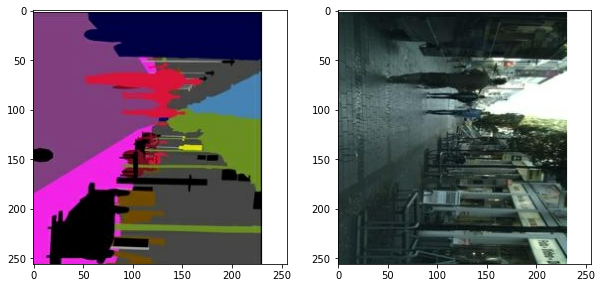

In [35]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample          = train_images.take(1)
sample          = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0] + 1) * 127.5, (sample[0][1] + 1) * 127.5

plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sketch[0].astype(np.uint8))

plt.subplot(1, 2, 2)
plt.imshow(colored[0].astype(np.uint8))

### 2. Generator 구성하기

* Generator의 Encoder 부분을 구현해보자.
* 먼저 논문에서 "C64", "C128" 등으로 쓰여진 것과 같이 "Convolution → BatchNorm → LeakyReLU"의 3개 레이어로 구성된 기본적인 블록을 아래와 같이 하나의 레이어로 만들었다.

In [36]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn = True):
        super(EncodeBlock, self).__init__()
        self.use_bn    = use_bn
        self.conv      = layers.Conv2D(n_filters, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu     = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

* __init__() 메서드에서 n_filters, use_bn를 설정하여 사용할 필터의 개수와 BatchNorm 사용 여부를 결정 할 수 있다.
* 이외 Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정했다.
* Encoder에 사용할 기본 블록을 구성했으니 이 블록을 여러번 가져다 사용하면 쉽게 Encoder를 구성할 수 있습니다. (아래 코드)

In [37]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64, 128, 256, 512, 512, 512, 512, 512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn = False))
            else:
                self.blocks.append(EncodeBlock(f))
                
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape = (256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

* 각 블록을 거치면서 사용할 필터의 개수를 filters라는 리스트에 지정했다.
* blocks이라는 리스트에는 사용할 블록들을 정의해 넣어두고, call() 메서드에서 차례대로 블록들을 통과한다.
* Encoder 첫 번째 블록에서는 BatchNorm을 사용하지 않는다.
* get_summary는 레이어가 제대로 구성되었는지 확인하기 위한 용도로 따로 만들어 놓았다.
* 위에서 구성한 Encoder에 (256,256,3) 크기의 데이터를 입력했을 때, 어떤 크기의 데이터가 출력되는지 살펴보자.
* 만들어 놓은 get_summary 메서드를 바로 불러오면 된다.

In [38]:
Encoder().get_summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block_32 (EncodeBlock (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_33 (EncodeBlock (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_34 (EncodeBlock (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_35 (EncodeBlock (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_36 (EncodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_37 (EncodeBlock (None, 4, 4, 512)         4196

* 블록을 통과할수록 (width, height) 크기는 반씩 줄어들고, 사용된 필터의 수는 최대 512개로 늘어나 최종 (1,1,512)로 알맞은 크기가 출력됨을 확인 할 수 있다.
* 이번엔 Decoder를 구현한다.
* Encoder와 마찬가지로 사용할 기본 블록을 정의하고, 이 블록을 여러번 반복하여 Decoder를 만든다.

In [39]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout = True):
        super(DecodeBlock, self).__init__()
        self.dropout   = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.relu      = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(0.5)(x)
        return self.relu(x)
    
    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512, 512, 512, 512, 256, 128, 64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout = False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias = False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape = (1, 1, 256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

* 처음 세 개의 블록에서만 Dropout을 사용했으며, 마지막 convolution에는 3개의 필터를 사용해 출력하는 것을 확인할 수 있다.
* 마찬가지로 (1, 1, 512) 크기의 데이터가 입력되었을 때, 어떤 크기가 출력되는지 확인해본다.

In [40]:
Decoder().get_summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block_28 (DecodeBlock (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_29 (DecodeBlock (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_30 (DecodeBlock (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_31 (DecodeBlock (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_32 (DecodeBlock (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_33 (DecodeBlock (None, 64, 64, 128)       5248

* (width, height) 크기가 점점 늘어나고 사용 필터의 수는 점점 줄어들어 최종 (256, 256, 3) 크기로 알맞게 출력되었다.
* 위에서 구성한 Encoder와 Decoder를 연결시키면 Encoder에서 (256, 256, 3) 입력이 (1, 1, 512)로 변환되고,
* Decoder를 통과해 다시 원래 입력 크기와 같은 (256, 256, 3)의 결과를 얻을 수 있다.
* 스케치를 입력으로 이런 연산 과정을 통해 채색된 이미지 출력을 얻을 수 있다.
* 아래 코드와 같이 tf.keras.Model을 상속받아 Encoder와 Decoder를 연결해 Generator를 구성했다.

In [41]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def get_summary(self, input_shape = (256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [42]:
EncoderDecoderGenerator().get_summary()

Model: "model_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_3 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_3 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


### 3. Generator 재구성하기

* 지금까지 Encoder와 Decoder를 연결시켜 Generator를 만들어 봤다.
* 하지만 Pix2Pix의 Generator 구조는 두 가지를 제안했다.
* 더 좋은 결과를 기대하기 위해 이전에 구현했던 것들을 조금 수정하여 U-Net 구조를 만들고 실험해본다.
* 먼저 Encoder 및 Decoder에 사용되는 기본적인 블록은 이전에 아래 코드와 같이 구현했었다.
* 참고로 아래 단락부터는 두 가지 구조를 각각 "Encoder-Decoder Generator" 및 "U-Net Generator"라는 용어로 구분하여 사용했다.

In [43]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn = True):
        super(EncodeBlock, self).__init__()
        self.use_bn    = use_bn
        self.conv      = layers.Conv2D(n_filters, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu     = layers.LeakyReLU(0.2)
        
    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)
    
    
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout = True):
        super(DecodeBlock, self).__init__()
        self.dropout   = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias = False)
        self.batchnorm = layers.BatchNormalization()
        self.relu      = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(0.5)(x)
        return self.relu(x)

* 여기서 특별히 수정해야 할 부분은 없다. 그대로 가져다가 사용한다.
* 정의된 블록들을 이용해 한 번에 U-Net Generator를 정의한다.
* 아래 모델의 __init__() 메서드에서 Encoder 및 Decoder에서 사용할 모든 블록들을 정의해 놓고, call()에서 forward propagation 하도록 한다.
* 이전 구현에는 없었던 skip connection이 call() 내부에서 어떻게 구현되었는지 잘 확인해보자.

In [44]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64, 128, 256, 512, 512, 512, 512, 512]
        decode_filters = [512, 512, 512, 512, 256, 128, 64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn = False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
                
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout = False))
                
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias = False)
        
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
            
        features = features[:-1]
        
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
            
        x = self.last_conv(x)
        return x
    
    def get_summary(self, input_shape = (256, 256, 3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

* 먼저, __init__()에서 정의된 encode_blocks 및 decode_blocks가 call() 내부에서 차례대로 사용되어 Encoder 및 Decoder 내부 연산을 수행한다.
* 이때, Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았다.
* 이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데,
* features 리스트에 있는 각각의 출력들이 Decoder 블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용된다.
* 코드의 call() 내에서 "features = features[:-1]"가 필요한 이유는 Skip connection을 위해 만들어진 features 리스트에는 Encoder 내 각 블록의 출력이 들어있는데, Encoder의 마지막 출력 (feature 리스트의 마지막 항목)은 Decoder로 직접 입력되므로 skip connection의 대상이 아니기 때문이다.
* 그리고 코드의 call() 내의 Decoder 연산 부분에서 features[::-1]가 필요한 이유는 Skip connection은 encoder 내 첫 번째 블록의 출력이 Decoder의 마지막 블록에 연결되고, Encoder 내 두번째 블록의 출력이 Decoder의 뒤에서 2번째 블록에 연결되는 등 대칭을 이루기 때문이다. features에는 Encoder 블록들의 출력들이 순서대로 쌓여있고, 이를 Decoder에서 차례때로 사용하기 위해서 features의 역순으로 연결한다.
* 이제 Generator 구현이 끝났다.
* 마지막으로 완성된 U-Net 구조 Generator 내부의 각 출력이 적절한지 확인해본다.

In [45]:
UNetGenerator().get_summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_48 (EncodeBlock)   (None, 128, 128, 64) 3072        input_11[0][0]                   
__________________________________________________________________________________________________
encode_block_49 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_48[0][0]            
__________________________________________________________________________________________________
encode_block_50 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_49[0][0]            
____________________________________________________________________________________________

### 4. Discriminator 구성하기

* Discriminator에 사용할 기본적인 블록부터 만든다.

In [46]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride = 2, custom_pad = False, use_bn = True, act = True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn     = use_bn
        self.act        = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv    = layers.Conv2D(n_filters, 4, stride, "valid", use_bias = False)
        else:
            self.conv    = layers.Conv2D(n_filters, 4, stride, "same",  use_bias = False)
            
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu     = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
            
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
            
        return x

* __init__() 에서 필요한 만큼 많은 설정을 가능하게끔 했다.
* 필터의 수(n_filters), 필터가 순회하는 간격(stride), 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정(custom_pad), BatchNorm의 사용 여부(use_bn), 활성화 함수 사용 여부(act)가 설정 가능하다.

* Discriminator를 표현한 그림을 찾아보면 마지막 2개 블록의 출력은 입력에 비해 (width, height) 크기가 1씩 감소한다는 것을 알 수 있다.
* 1씩 감소시키기 위한 방법을 자세히 보자.
* (128, 128, 32) 크기의 입력이 layers.ZeroPadding2D()를 통과하면, width 및 height의 양쪽 면에 각각 1씩 패딩되어 총 2만큼 크기가 늘어난다.
* 출력 : (130, 130, 32)
* 패딩하지 않고 필터 크기 4 및 간격(stride) 1의 convolution 레이어를 통과하면 width 및 height 가 3씩 줄어든다.
* 이는 OutSize = (InSize + 2 ∗ PadSize − FilterSize) / Stride + 1의 식으로 계산할 수 있다.
* 채널 수는 사용한 필터 개수와 같다.
* 출력 : (127, 127, 64)
* 이 외 다른 레이어(BatchNorm, LeakyReLU)는 출력의 크기에 영향을 주지 않는다.
* 간단하게 코드를 작성하여 각 출력의 크기가 맞는지 확인해 본다.

In [47]:
inputs = Input((128, 128, 32))

out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias = False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d_7 (ZeroPaddin (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_115 (Bat (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_69 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


* 이런 코드와 비슷한 설정으로 (width, height) 크기를 1씩 감소시킬 수 있다.
* 마지막 2개 블록은 출력의 크기가 1씩 감소하므로 이런 방식을 적용하면 된다.
* Pix2Pix의 Discriminator가 70x70 PatchGAN을 사용하기 때문에 최종 출력을 (30, 30) 크기로 맞추느라 위와 같이 조금 복잡한 과정을 설명했다.
* 사용할 기본적인 블록을 만들었으니 이를 이용해 바로 Discriminator를 만들어본다.

In [48]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1  = layers.Concatenate()
        self.block2  = DiscBlock(n_filters = 64,  stride = 2, custom_pad = False, use_bn = False, act = True)
        self.block3  = DiscBlock(n_filters = 128, stride = 2, custom_pad = False, use_bn = True,  act = True)
        self.block4  = DiscBlock(n_filters = 256, stride = 2, custom_pad = False, use_bn = True,  act = True)
        self.block5  = DiscBlock(n_filters = 512, stride = 1, custom_pad = True,  use_bn = True,  act = True)
        self.block6  = DiscBlock(n_filters = 1,   stride = 1, custom_pad = True,  use_bn = False, act = False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters     = [64, 128, 256, 512, 1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters  = f,
        #         strides    = 2 if i < 3 else 1,
        #         custom_pad = False if i < 3 else True,
        #         use_bn     = False if i == 0 and i == 4 else True,
        #         act        = True if i < 4 else False
        #     ))
        
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape = (256, 256, 3), y_shape = (256, 256, 3)):
        x, y = Input(x_shape), Input(y_shape)
        return Model((x, y), self.call(x, y)).summary()

* __init__() 내부에서 사용할 블록들을 정의했는데, 이전의 구현들처럼 (위 코드의 주석 처리된 부분과 같이) for loop로 간편하게 블록을 만들 수도 있지만, 쉽게 코드를 읽게끔 총 6개 블록을 각각 따로 만들었다.
* 첫 번째 블록은 단순한 연결(concat)을 수행하며, Discriminator의 최종 출력은 sigmoid 활성화를 사용했다.
* 각 블록의 출력 크기가 알맞게 되었는지 아래 코드로 확인해본다.

In [49]:
Discriminator().get_summary()

Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_17 (Concatenate)    (None, 256, 256, 6)  0           input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
disc_block_15 (DiscBlock)       (None, 128, 128, 64) 6144        concatenate_17[0][0]      

* 시험 삼아 임의의 (256, 256, 3) 크기의 입력을 넣어 나오는 (30, 30) 출력을 시각화해본다.

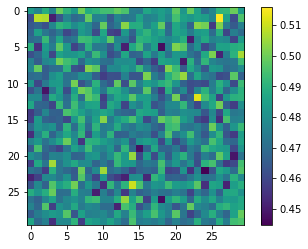

In [50]:
x = tf.random.normal([1,  256, 256, 3])
y = tf.random.uniform([1, 256, 256, 3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ..., 0])
plt.colorbar()

* 위 (30, 30) 크기를 갖는 결과 이미지의 각 픽셀값은 원래 입력의 (70, 70) 패치에 대한 분류 결과이다.
* 전체 입력의 크기가 (256, 256) 이므로, 각각의 (70, 70) 패치는 원래 입력상에서 많이 겹쳐있다.
* 각각의 픽셀값은 sigmoid 함수의 결괏값이므로 0 ~ 1 사이의 값을 가지며, 진짜 및 가짜 데이터를 판별해내는 데 사용한다.
* 드디어 Pix2Pix를 구성하는 Generator와 Discriminator의 구현이 끝났다.
* 다음은 본격적인 모델 학습을 진행해본다.

### 5. 학습 및 테스트하기

* 이번 단계에서는 구현된 Generator와 Discriminator를 학습시켜보고, 스케치를 입력으로 채색된 이미지를 생성해본다.
* 먼저 학습에 필요한 손실함수부터 정의한다.
* 레이블 정보만 있는 입력에 대해 여러 손실함수를 사용해 실제 이미지를 만들어 낸 결과는, 일반적인 GAN의 손실함수에 L1을 추가로 이용했을 때 가장 실제에 가까운 이미지를 생성한다고 한다.
* 이번 실험에서도 두 가지 손실 함수를 모두 사용해본다.

In [51]:
bce = losses.BinaryCrossentropy(from_logits = False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss   = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

* Generator 및 Discriminator의 손실 계산을 각각 정의했다.
* Generator의 손실함수 (위 코드의 get_gene_loss)는 총 3개의 입력이 있다. 이 중 fake_disc는 Generator가 생성한 가짜 이미지를 Discriminator에 입력하여 얻어진 값이며, 실제 이미지를 뜻하는 "1"과 비교하기 위해 tf.ones_like()를 사용합니다. 또한 L1 손실을 계산하기 위해 생성한 가짜 이미지(fake_output)와 실제 이미지(real_output) 사이의 MAE(Mean Absolute Error)를 계산한다.
* Discriminator의 손실함수 (위 코드의 get_disc_loss)는 2개의 입력이 있으며, 이들은 가짜 및 진짜 이미지가 Discriminator에 각각 입력되어 얻어진 값입니다. Discriminator는 실제 이미지를 잘 구분해 내야 하므로 real_disc는 "1"로 채워진 벡터와 비교하고, fake_disc는 "0"으로 채워진 벡터와 비교한다.
* 사용할 optimizer는 논문과 동일하게 설정했다.

In [52]:
gene_opt = optimizers.Adam(2e-4, beta_1 = 0.5, beta_2 = 0.999)
disc_opt = optimizers.Adam(2e-4, beta_1 = 0.5, beta_2 = 0.999)

* 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정은 아래와 같이 구현했다.

In [53]:
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training = True)
        
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training = True)
        real_disc = discriminator(sketch, real_colored, training = True)
        
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss    = gene_loss + (100 * l1_loss) # L1 손실 반영 λ = 100
        
        # Discriminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
        
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

* 전반적인 학습 과정은 앞서 진행했었던 cGAN 학습과 크게 다르지 않다.
* 다만 위 코드의 gene_total_loss 계산 라인에서 최종 Generator 손실을 계산할 때, L1 손실에 100을 곱한 부분을 확인할 수 있다.
* λ는 학습 과정에서 L1 손실을 얼마나 반영할 것인지를 나타내며 논문에서는 λ = 100을 사용했다.
* 앞서 정의한 함수를 이용해서 학습을 진행한다.

In [54]:
EPOCHS = 500

generator     = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS + 1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
        
        # 10회 반복마다 손실을 출력한다.
        if (i + 1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i + 1}] \
                  \nGenerator_loss : {g_loss.numpy():.4f} \
                  \nL1_loss : {l1_loss.numpy():.4f} \
                  \nDiscriminator_loss : {d_loss.numpy():.4f}", 
                  end = "\n\n")

EPOCH[1] - STEP[10]                   
Generator_loss : 0.9600                   
L1_loss : 0.3215                   
Discriminator_loss : 1.3663

EPOCH[1] - STEP[20]                   
Generator_loss : 0.9263                   
L1_loss : 0.2202                   
Discriminator_loss : 1.2600

EPOCH[1] - STEP[30]                   
Generator_loss : 0.9628                   
L1_loss : 0.2059                   
Discriminator_loss : 1.3161

EPOCH[1] - STEP[40]                   
Generator_loss : 0.7906                   
L1_loss : 0.1850                   
Discriminator_loss : 1.2068

EPOCH[1] - STEP[50]                   
Generator_loss : 0.9089                   
L1_loss : 0.2022                   
Discriminator_loss : 1.1501

EPOCH[1] - STEP[60]                   
Generator_loss : 0.8028                   
L1_loss : 0.2299                   
Discriminator_loss : 1.1128

EPOCH[1] - STEP[70]                   
Generator_loss : 1.0422                   
L1_loss : 0.1855                   


EPOCH[3] - STEP[70]                   
Generator_loss : 0.2438                   
L1_loss : 0.1615                   
Discriminator_loss : 1.8033

EPOCH[3] - STEP[80]                   
Generator_loss : 2.4526                   
L1_loss : 0.1892                   
Discriminator_loss : 0.8164

EPOCH[3] - STEP[90]                   
Generator_loss : 2.2557                   
L1_loss : 0.1541                   
Discriminator_loss : 0.7132

EPOCH[3] - STEP[100]                   
Generator_loss : 0.9525                   
L1_loss : 0.1665                   
Discriminator_loss : 0.9648

EPOCH[3] - STEP[110]                   
Generator_loss : 1.6144                   
L1_loss : 0.1935                   
Discriminator_loss : 0.4699

EPOCH[3] - STEP[120]                   
Generator_loss : 0.8619                   
L1_loss : 0.1802                   
Discriminator_loss : 0.9508

EPOCH[3] - STEP[130]                   
Generator_loss : 1.3327                   
L1_loss : 0.1827                

EPOCH[5] - STEP[130]                   
Generator_loss : 1.0006                   
L1_loss : 0.2329                   
Discriminator_loss : 1.7075

EPOCH[5] - STEP[140]                   
Generator_loss : 2.4369                   
L1_loss : 0.1879                   
Discriminator_loss : 1.0041

EPOCH[5] - STEP[150]                   
Generator_loss : 1.6858                   
L1_loss : 0.1857                   
Discriminator_loss : 0.3307

EPOCH[5] - STEP[160]                   
Generator_loss : 0.7331                   
L1_loss : 0.1734                   
Discriminator_loss : 0.9075

EPOCH[5] - STEP[170]                   
Generator_loss : 3.1939                   
L1_loss : 0.1710                   
Discriminator_loss : 0.7510

EPOCH[5] - STEP[180]                   
Generator_loss : 1.0257                   
L1_loss : 0.1839                   
Discriminator_loss : 0.5875

EPOCH[5] - STEP[190]                   
Generator_loss : 2.1027                   
L1_loss : 0.1654             

EPOCH[7] - STEP[190]                   
Generator_loss : 0.3506                   
L1_loss : 0.1729                   
Discriminator_loss : 1.6232

EPOCH[7] - STEP[200]                   
Generator_loss : 2.2435                   
L1_loss : 0.1708                   
Discriminator_loss : 0.3527

EPOCH[7] - STEP[210]                   
Generator_loss : 0.5659                   
L1_loss : 0.1856                   
Discriminator_loss : 1.1253

EPOCH[7] - STEP[220]                   
Generator_loss : 1.0783                   
L1_loss : 0.1800                   
Discriminator_loss : 0.6596

EPOCH[7] - STEP[230]                   
Generator_loss : 1.8445                   
L1_loss : 0.2217                   
Discriminator_loss : 0.3916

EPOCH[7] - STEP[240]                   
Generator_loss : 1.1119                   
L1_loss : 0.1787                   
Discriminator_loss : 0.5802

EPOCH[7] - STEP[250]                   
Generator_loss : 0.9035                   
L1_loss : 0.2035             

EPOCH[9] - STEP[250]                   
Generator_loss : 2.2760                   
L1_loss : 0.1565                   
Discriminator_loss : 1.2137

EPOCH[10] - STEP[10]                   
Generator_loss : 1.4196                   
L1_loss : 0.1604                   
Discriminator_loss : 0.6138

EPOCH[10] - STEP[20]                   
Generator_loss : 2.0099                   
L1_loss : 0.1677                   
Discriminator_loss : 0.4664

EPOCH[10] - STEP[30]                   
Generator_loss : 2.4835                   
L1_loss : 0.1668                   
Discriminator_loss : 1.6658

EPOCH[10] - STEP[40]                   
Generator_loss : 0.9391                   
L1_loss : 0.2151                   
Discriminator_loss : 0.6481

EPOCH[10] - STEP[50]                   
Generator_loss : 2.1920                   
L1_loss : 0.1687                   
Discriminator_loss : 0.8380

EPOCH[10] - STEP[60]                   
Generator_loss : 1.7120                   
L1_loss : 0.1499             

EPOCH[12] - STEP[60]                   
Generator_loss : 1.9682                   
L1_loss : 0.1823                   
Discriminator_loss : 0.2556

EPOCH[12] - STEP[70]                   
Generator_loss : 1.7073                   
L1_loss : 0.1727                   
Discriminator_loss : 1.1734

EPOCH[12] - STEP[80]                   
Generator_loss : 1.7046                   
L1_loss : 0.1571                   
Discriminator_loss : 1.1395

EPOCH[12] - STEP[90]                   
Generator_loss : 1.0049                   
L1_loss : 0.1966                   
Discriminator_loss : 0.7427

EPOCH[12] - STEP[100]                   
Generator_loss : 2.7102                   
L1_loss : 0.1998                   
Discriminator_loss : 0.3056

EPOCH[12] - STEP[110]                   
Generator_loss : 0.7801                   
L1_loss : 0.2370                   
Discriminator_loss : 0.6830

EPOCH[12] - STEP[120]                   
Generator_loss : 1.0378                   
L1_loss : 0.1630          

EPOCH[14] - STEP[120]                   
Generator_loss : 1.0663                   
L1_loss : 0.1727                   
Discriminator_loss : 0.5683

EPOCH[14] - STEP[130]                   
Generator_loss : 1.5387                   
L1_loss : 0.1613                   
Discriminator_loss : 0.8575

EPOCH[14] - STEP[140]                   
Generator_loss : 2.0664                   
L1_loss : 0.2047                   
Discriminator_loss : 0.4549

EPOCH[14] - STEP[150]                   
Generator_loss : 1.6852                   
L1_loss : 0.1817                   
Discriminator_loss : 0.6029

EPOCH[14] - STEP[160]                   
Generator_loss : 0.8356                   
L1_loss : 0.1951                   
Discriminator_loss : 0.9834

EPOCH[14] - STEP[170]                   
Generator_loss : 0.4702                   
L1_loss : 0.1817                   
Discriminator_loss : 1.3675

EPOCH[14] - STEP[180]                   
Generator_loss : 0.8429                   
L1_loss : 0.1637      

EPOCH[16] - STEP[180]                   
Generator_loss : 2.7932                   
L1_loss : 0.1786                   
Discriminator_loss : 0.7390

EPOCH[16] - STEP[190]                   
Generator_loss : 2.5941                   
L1_loss : 0.1563                   
Discriminator_loss : 1.3305

EPOCH[16] - STEP[200]                   
Generator_loss : 0.6458                   
L1_loss : 0.2069                   
Discriminator_loss : 0.8968

EPOCH[16] - STEP[210]                   
Generator_loss : 0.8539                   
L1_loss : 0.1723                   
Discriminator_loss : 0.6991

EPOCH[16] - STEP[220]                   
Generator_loss : 1.7232                   
L1_loss : 0.1662                   
Discriminator_loss : 0.4365

EPOCH[16] - STEP[230]                   
Generator_loss : 0.3220                   
L1_loss : 0.1651                   
Discriminator_loss : 1.9851

EPOCH[16] - STEP[240]                   
Generator_loss : 1.9090                   
L1_loss : 0.1711      

EPOCH[18] - STEP[240]                   
Generator_loss : 1.8359                   
L1_loss : 0.1627                   
Discriminator_loss : 1.2350

EPOCH[18] - STEP[250]                   
Generator_loss : 1.8784                   
L1_loss : 0.1685                   
Discriminator_loss : 1.2432

EPOCH[19] - STEP[10]                   
Generator_loss : 0.9226                   
L1_loss : 0.1640                   
Discriminator_loss : 0.6885

EPOCH[19] - STEP[20]                   
Generator_loss : 1.8829                   
L1_loss : 0.2018                   
Discriminator_loss : 0.3237

EPOCH[19] - STEP[30]                   
Generator_loss : 1.6196                   
L1_loss : 0.1979                   
Discriminator_loss : 0.3368

EPOCH[19] - STEP[40]                   
Generator_loss : 0.7818                   
L1_loss : 0.1809                   
Discriminator_loss : 1.0124

EPOCH[19] - STEP[50]                   
Generator_loss : 2.1287                   
L1_loss : 0.1674           

EPOCH[21] - STEP[50]                   
Generator_loss : 1.0786                   
L1_loss : 0.1464                   
Discriminator_loss : 1.1854

EPOCH[21] - STEP[60]                   
Generator_loss : 0.6450                   
L1_loss : 0.1770                   
Discriminator_loss : 0.9296

EPOCH[21] - STEP[70]                   
Generator_loss : 0.3890                   
L1_loss : 0.1931                   
Discriminator_loss : 1.6842

EPOCH[21] - STEP[80]                   
Generator_loss : 0.6031                   
L1_loss : 0.1754                   
Discriminator_loss : 1.4833

EPOCH[21] - STEP[90]                   
Generator_loss : 2.1957                   
L1_loss : 0.1719                   
Discriminator_loss : 0.5380

EPOCH[21] - STEP[100]                   
Generator_loss : 1.2507                   
L1_loss : 0.2337                   
Discriminator_loss : 0.5637

EPOCH[21] - STEP[110]                   
Generator_loss : 2.1258                   
L1_loss : 0.1400           

EPOCH[23] - STEP[110]                   
Generator_loss : 2.0416                   
L1_loss : 0.1768                   
Discriminator_loss : 0.4246

EPOCH[23] - STEP[120]                   
Generator_loss : 1.4518                   
L1_loss : 0.1645                   
Discriminator_loss : 1.0079

EPOCH[23] - STEP[130]                   
Generator_loss : 1.3437                   
L1_loss : 0.1833                   
Discriminator_loss : 0.5694

EPOCH[23] - STEP[140]                   
Generator_loss : 0.9758                   
L1_loss : 0.1547                   
Discriminator_loss : 1.1057

EPOCH[23] - STEP[150]                   
Generator_loss : 1.3674                   
L1_loss : 0.1881                   
Discriminator_loss : 1.7171

EPOCH[23] - STEP[160]                   
Generator_loss : 2.0980                   
L1_loss : 0.1669                   
Discriminator_loss : 1.3137

EPOCH[23] - STEP[170]                   
Generator_loss : 1.5144                   
L1_loss : 0.1796      

EPOCH[25] - STEP[170]                   
Generator_loss : 1.2602                   
L1_loss : 0.1759                   
Discriminator_loss : 0.5830

EPOCH[25] - STEP[180]                   
Generator_loss : 1.5190                   
L1_loss : 0.1771                   
Discriminator_loss : 1.9972

EPOCH[25] - STEP[190]                   
Generator_loss : 0.8429                   
L1_loss : 0.1680                   
Discriminator_loss : 0.6867

EPOCH[25] - STEP[200]                   
Generator_loss : 1.2004                   
L1_loss : 0.1511                   
Discriminator_loss : 0.9399

EPOCH[25] - STEP[210]                   
Generator_loss : 1.3173                   
L1_loss : 0.1999                   
Discriminator_loss : 0.3935

EPOCH[25] - STEP[220]                   
Generator_loss : 0.9097                   
L1_loss : 0.1507                   
Discriminator_loss : 1.3668

EPOCH[25] - STEP[230]                   
Generator_loss : 2.1986                   
L1_loss : 0.1664      

EPOCH[27] - STEP[230]                   
Generator_loss : 0.4501                   
L1_loss : 0.1564                   
Discriminator_loss : 1.8590

EPOCH[27] - STEP[240]                   
Generator_loss : 1.8029                   
L1_loss : 0.1412                   
Discriminator_loss : 1.6749

EPOCH[27] - STEP[250]                   
Generator_loss : 1.2689                   
L1_loss : 0.1639                   
Discriminator_loss : 0.5527

EPOCH[28] - STEP[10]                   
Generator_loss : 1.7543                   
L1_loss : 0.1732                   
Discriminator_loss : 0.7214

EPOCH[28] - STEP[20]                   
Generator_loss : 1.7542                   
L1_loss : 0.1876                   
Discriminator_loss : 0.4425

EPOCH[28] - STEP[30]                   
Generator_loss : 1.9214                   
L1_loss : 0.1615                   
Discriminator_loss : 0.7602

EPOCH[28] - STEP[40]                   
Generator_loss : 0.7020                   
L1_loss : 0.1685          

EPOCH[30] - STEP[40]                   
Generator_loss : 0.1993                   
L1_loss : 0.2211                   
Discriminator_loss : 2.0595

EPOCH[30] - STEP[50]                   
Generator_loss : 1.3594                   
L1_loss : 0.1658                   
Discriminator_loss : 0.5978

EPOCH[30] - STEP[60]                   
Generator_loss : 1.2499                   
L1_loss : 0.2055                   
Discriminator_loss : 0.4618

EPOCH[30] - STEP[70]                   
Generator_loss : 1.3433                   
L1_loss : 0.1841                   
Discriminator_loss : 0.4330

EPOCH[30] - STEP[80]                   
Generator_loss : 1.1098                   
L1_loss : 0.1724                   
Discriminator_loss : 0.6169

EPOCH[30] - STEP[90]                   
Generator_loss : 0.4365                   
L1_loss : 0.1743                   
Discriminator_loss : 1.3354

EPOCH[30] - STEP[100]                   
Generator_loss : 0.7651                   
L1_loss : 0.1569            

EPOCH[32] - STEP[100]                   
Generator_loss : 0.7568                   
L1_loss : 0.1569                   
Discriminator_loss : 1.3601

EPOCH[32] - STEP[110]                   
Generator_loss : 0.9499                   
L1_loss : 0.1622                   
Discriminator_loss : 0.8164

EPOCH[32] - STEP[120]                   
Generator_loss : 1.4680                   
L1_loss : 0.1780                   
Discriminator_loss : 0.3988

EPOCH[32] - STEP[130]                   
Generator_loss : 1.2176                   
L1_loss : 0.1872                   
Discriminator_loss : 0.5008

EPOCH[32] - STEP[140]                   
Generator_loss : 2.3162                   
L1_loss : 0.1764                   
Discriminator_loss : 1.2041

EPOCH[32] - STEP[150]                   
Generator_loss : 1.6802                   
L1_loss : 0.1711                   
Discriminator_loss : 0.3735

EPOCH[32] - STEP[160]                   
Generator_loss : 1.7284                   
L1_loss : 0.1581      

EPOCH[34] - STEP[160]                   
Generator_loss : 1.6694                   
L1_loss : 0.1672                   
Discriminator_loss : 0.6830

EPOCH[34] - STEP[170]                   
Generator_loss : 1.9976                   
L1_loss : 0.1694                   
Discriminator_loss : 0.3228

EPOCH[34] - STEP[180]                   
Generator_loss : 0.8671                   
L1_loss : 0.1738                   
Discriminator_loss : 1.9842

EPOCH[34] - STEP[190]                   
Generator_loss : 1.3717                   
L1_loss : 0.1858                   
Discriminator_loss : 0.6318

EPOCH[34] - STEP[200]                   
Generator_loss : 2.0283                   
L1_loss : 0.1910                   
Discriminator_loss : 0.7131

EPOCH[34] - STEP[210]                   
Generator_loss : 2.3983                   
L1_loss : 0.1891                   
Discriminator_loss : 0.7886

EPOCH[34] - STEP[220]                   
Generator_loss : 2.5557                   
L1_loss : 0.1765      

EPOCH[36] - STEP[220]                   
Generator_loss : 1.0913                   
L1_loss : 0.2129                   
Discriminator_loss : 0.8934

EPOCH[36] - STEP[230]                   
Generator_loss : 1.2078                   
L1_loss : 0.1685                   
Discriminator_loss : 0.7404

EPOCH[36] - STEP[240]                   
Generator_loss : 1.1473                   
L1_loss : 0.1920                   
Discriminator_loss : 0.6537

EPOCH[36] - STEP[250]                   
Generator_loss : 1.1835                   
L1_loss : 0.1502                   
Discriminator_loss : 0.7594

EPOCH[37] - STEP[10]                   
Generator_loss : 1.2040                   
L1_loss : 0.1925                   
Discriminator_loss : 0.4841

EPOCH[37] - STEP[20]                   
Generator_loss : 1.4851                   
L1_loss : 0.1747                   
Discriminator_loss : 0.6622

EPOCH[37] - STEP[30]                   
Generator_loss : 1.2938                   
L1_loss : 0.1562         

EPOCH[39] - STEP[30]                   
Generator_loss : 1.1857                   
L1_loss : 0.2102                   
Discriminator_loss : 0.4991

EPOCH[39] - STEP[40]                   
Generator_loss : 1.3399                   
L1_loss : 0.1872                   
Discriminator_loss : 0.3634

EPOCH[39] - STEP[50]                   
Generator_loss : 2.2374                   
L1_loss : 0.1739                   
Discriminator_loss : 0.3056

EPOCH[39] - STEP[60]                   
Generator_loss : 0.6576                   
L1_loss : 0.1641                   
Discriminator_loss : 1.1610

EPOCH[39] - STEP[70]                   
Generator_loss : 0.7471                   
L1_loss : 0.1626                   
Discriminator_loss : 0.9150

EPOCH[39] - STEP[80]                   
Generator_loss : 1.3299                   
L1_loss : 0.1680                   
Discriminator_loss : 0.9936

EPOCH[39] - STEP[90]                   
Generator_loss : 1.8923                   
L1_loss : 0.1675             

EPOCH[41] - STEP[90]                   
Generator_loss : 1.1970                   
L1_loss : 0.1708                   
Discriminator_loss : 0.6705

EPOCH[41] - STEP[100]                   
Generator_loss : 1.4969                   
L1_loss : 0.1569                   
Discriminator_loss : 1.6364

EPOCH[41] - STEP[110]                   
Generator_loss : 1.2434                   
L1_loss : 0.1654                   
Discriminator_loss : 0.9311

EPOCH[41] - STEP[120]                   
Generator_loss : 2.9352                   
L1_loss : 0.1824                   
Discriminator_loss : 0.4140

EPOCH[41] - STEP[130]                   
Generator_loss : 1.3245                   
L1_loss : 0.1828                   
Discriminator_loss : 0.7839

EPOCH[41] - STEP[140]                   
Generator_loss : 1.5411                   
L1_loss : 0.1613                   
Discriminator_loss : 1.2740

EPOCH[41] - STEP[150]                   
Generator_loss : 1.3243                   
L1_loss : 0.1980       

EPOCH[43] - STEP[150]                   
Generator_loss : 1.5235                   
L1_loss : 0.1808                   
Discriminator_loss : 0.6161

EPOCH[43] - STEP[160]                   
Generator_loss : 0.8875                   
L1_loss : 0.1537                   
Discriminator_loss : 1.3058

EPOCH[43] - STEP[170]                   
Generator_loss : 1.6337                   
L1_loss : 0.1697                   
Discriminator_loss : 0.3782

EPOCH[43] - STEP[180]                   
Generator_loss : 1.6963                   
L1_loss : 0.1885                   
Discriminator_loss : 0.7279

EPOCH[43] - STEP[190]                   
Generator_loss : 1.6528                   
L1_loss : 0.2090                   
Discriminator_loss : 0.3317

EPOCH[43] - STEP[200]                   
Generator_loss : 0.4611                   
L1_loss : 0.1679                   
Discriminator_loss : 1.2620

EPOCH[43] - STEP[210]                   
Generator_loss : 0.6911                   
L1_loss : 0.1742      

EPOCH[45] - STEP[210]                   
Generator_loss : 1.8277                   
L1_loss : 0.1847                   
Discriminator_loss : 1.4714

EPOCH[45] - STEP[220]                   
Generator_loss : 1.7216                   
L1_loss : 0.1797                   
Discriminator_loss : 0.4123

EPOCH[45] - STEP[230]                   
Generator_loss : 1.6557                   
L1_loss : 0.1834                   
Discriminator_loss : 0.4853

EPOCH[45] - STEP[240]                   
Generator_loss : 0.5700                   
L1_loss : 0.1975                   
Discriminator_loss : 0.9240

EPOCH[45] - STEP[250]                   
Generator_loss : 1.3170                   
L1_loss : 0.2325                   
Discriminator_loss : 0.3627

EPOCH[46] - STEP[10]                   
Generator_loss : 1.8129                   
L1_loss : 0.1708                   
Discriminator_loss : 1.8844

EPOCH[46] - STEP[20]                   
Generator_loss : 0.6606                   
L1_loss : 0.1450        

EPOCH[48] - STEP[20]                   
Generator_loss : 0.6530                   
L1_loss : 0.1645                   
Discriminator_loss : 1.6537

EPOCH[48] - STEP[30]                   
Generator_loss : 1.0064                   
L1_loss : 0.1549                   
Discriminator_loss : 0.9844

EPOCH[48] - STEP[40]                   
Generator_loss : 2.1207                   
L1_loss : 0.1723                   
Discriminator_loss : 0.2084

EPOCH[48] - STEP[50]                   
Generator_loss : 0.9140                   
L1_loss : 0.1675                   
Discriminator_loss : 1.1204

EPOCH[48] - STEP[60]                   
Generator_loss : 1.6990                   
L1_loss : 0.1531                   
Discriminator_loss : 0.9634

EPOCH[48] - STEP[70]                   
Generator_loss : 1.0902                   
L1_loss : 0.1610                   
Discriminator_loss : 0.6749

EPOCH[48] - STEP[80]                   
Generator_loss : 0.9548                   
L1_loss : 0.1725             

EPOCH[50] - STEP[80]                   
Generator_loss : 1.3997                   
L1_loss : 0.1976                   
Discriminator_loss : 0.7231

EPOCH[50] - STEP[90]                   
Generator_loss : 0.9940                   
L1_loss : 0.1638                   
Discriminator_loss : 1.0540

EPOCH[50] - STEP[100]                   
Generator_loss : 1.4154                   
L1_loss : 0.1693                   
Discriminator_loss : 1.9936

EPOCH[50] - STEP[110]                   
Generator_loss : 1.4321                   
L1_loss : 0.1873                   
Discriminator_loss : 0.8105

EPOCH[50] - STEP[120]                   
Generator_loss : 1.0394                   
L1_loss : 0.1890                   
Discriminator_loss : 0.5536

EPOCH[50] - STEP[130]                   
Generator_loss : 1.1187                   
L1_loss : 0.1450                   
Discriminator_loss : 0.7863

EPOCH[50] - STEP[140]                   
Generator_loss : 0.2185                   
L1_loss : 0.1906        

EPOCH[52] - STEP[140]                   
Generator_loss : 0.9437                   
L1_loss : 0.1765                   
Discriminator_loss : 0.9091

EPOCH[52] - STEP[150]                   
Generator_loss : 0.6332                   
L1_loss : 0.1967                   
Discriminator_loss : 0.8997

EPOCH[52] - STEP[160]                   
Generator_loss : 1.9305                   
L1_loss : 0.1747                   
Discriminator_loss : 0.3235

EPOCH[52] - STEP[170]                   
Generator_loss : 1.0233                   
L1_loss : 0.1821                   
Discriminator_loss : 0.6537

EPOCH[52] - STEP[180]                   
Generator_loss : 0.6549                   
L1_loss : 0.1636                   
Discriminator_loss : 1.0647

EPOCH[52] - STEP[190]                   
Generator_loss : 1.0074                   
L1_loss : 0.1631                   
Discriminator_loss : 1.8177

EPOCH[52] - STEP[200]                   
Generator_loss : 2.0066                   
L1_loss : 0.1906      

EPOCH[54] - STEP[200]                   
Generator_loss : 1.4502                   
L1_loss : 0.1364                   
Discriminator_loss : 1.4251

EPOCH[54] - STEP[210]                   
Generator_loss : 1.5225                   
L1_loss : 0.2035                   
Discriminator_loss : 0.7997

EPOCH[54] - STEP[220]                   
Generator_loss : 2.6151                   
L1_loss : 0.1664                   
Discriminator_loss : 2.5343

EPOCH[54] - STEP[230]                   
Generator_loss : 0.8778                   
L1_loss : 0.1972                   
Discriminator_loss : 1.2439

EPOCH[54] - STEP[240]                   
Generator_loss : 1.0236                   
L1_loss : 0.1660                   
Discriminator_loss : 0.5657

EPOCH[54] - STEP[250]                   
Generator_loss : 1.0941                   
L1_loss : 0.1983                   
Discriminator_loss : 0.5094

EPOCH[55] - STEP[10]                   
Generator_loss : 0.8385                   
L1_loss : 0.1958       

EPOCH[57] - STEP[10]                   
Generator_loss : 1.4598                   
L1_loss : 0.1566                   
Discriminator_loss : 1.7865

EPOCH[57] - STEP[20]                   
Generator_loss : 0.7786                   
L1_loss : 0.1656                   
Discriminator_loss : 0.8882

EPOCH[57] - STEP[30]                   
Generator_loss : 1.6246                   
L1_loss : 0.1859                   
Discriminator_loss : 1.4032

EPOCH[57] - STEP[40]                   
Generator_loss : 1.5278                   
L1_loss : 0.1727                   
Discriminator_loss : 0.5171

EPOCH[57] - STEP[50]                   
Generator_loss : 3.0926                   
L1_loss : 0.1815                   
Discriminator_loss : 0.3792

EPOCH[57] - STEP[60]                   
Generator_loss : 1.7693                   
L1_loss : 0.1863                   
Discriminator_loss : 0.3592

EPOCH[57] - STEP[70]                   
Generator_loss : 2.7404                   
L1_loss : 0.1924             

EPOCH[59] - STEP[70]                   
Generator_loss : 1.5233                   
L1_loss : 0.1878                   
Discriminator_loss : 0.5855

EPOCH[59] - STEP[80]                   
Generator_loss : 1.0794                   
L1_loss : 0.1904                   
Discriminator_loss : 0.5220

EPOCH[59] - STEP[90]                   
Generator_loss : 0.6087                   
L1_loss : 0.1864                   
Discriminator_loss : 0.9260

EPOCH[59] - STEP[100]                   
Generator_loss : 0.8365                   
L1_loss : 0.1516                   
Discriminator_loss : 1.0715

EPOCH[59] - STEP[110]                   
Generator_loss : 0.9819                   
L1_loss : 0.1388                   
Discriminator_loss : 1.3433

EPOCH[59] - STEP[120]                   
Generator_loss : 2.0093                   
L1_loss : 0.1715                   
Discriminator_loss : 1.9680

EPOCH[59] - STEP[130]                   
Generator_loss : 1.4955                   
L1_loss : 0.1734         

EPOCH[61] - STEP[130]                   
Generator_loss : 0.3181                   
L1_loss : 0.1651                   
Discriminator_loss : 1.7599

EPOCH[61] - STEP[140]                   
Generator_loss : 0.7172                   
L1_loss : 0.1858                   
Discriminator_loss : 0.8121

EPOCH[61] - STEP[150]                   
Generator_loss : 1.3064                   
L1_loss : 0.1623                   
Discriminator_loss : 1.1956

EPOCH[61] - STEP[160]                   
Generator_loss : 1.2773                   
L1_loss : 0.1429                   
Discriminator_loss : 1.8580

EPOCH[61] - STEP[170]                   
Generator_loss : 1.4989                   
L1_loss : 0.1520                   
Discriminator_loss : 1.0649

EPOCH[61] - STEP[180]                   
Generator_loss : 2.3829                   
L1_loss : 0.1508                   
Discriminator_loss : 2.4685

EPOCH[61] - STEP[190]                   
Generator_loss : 1.1431                   
L1_loss : 0.1636      

EPOCH[63] - STEP[190]                   
Generator_loss : 0.6755                   
L1_loss : 0.1633                   
Discriminator_loss : 1.5816

EPOCH[63] - STEP[200]                   
Generator_loss : 1.7988                   
L1_loss : 0.2026                   
Discriminator_loss : 0.3354

EPOCH[63] - STEP[210]                   
Generator_loss : 1.8627                   
L1_loss : 0.2305                   
Discriminator_loss : 0.2039

EPOCH[63] - STEP[220]                   
Generator_loss : 0.9156                   
L1_loss : 0.2092                   
Discriminator_loss : 0.7222

EPOCH[63] - STEP[230]                   
Generator_loss : 1.0243                   
L1_loss : 0.1721                   
Discriminator_loss : 0.7353

EPOCH[63] - STEP[240]                   
Generator_loss : 0.9264                   
L1_loss : 0.1895                   
Discriminator_loss : 0.5944

EPOCH[63] - STEP[250]                   
Generator_loss : 2.2760                   
L1_loss : 0.2084      

EPOCH[65] - STEP[250]                   
Generator_loss : 0.4545                   
L1_loss : 0.1549                   
Discriminator_loss : 1.2778

EPOCH[66] - STEP[10]                   
Generator_loss : 1.0900                   
L1_loss : 0.1940                   
Discriminator_loss : 0.5507

EPOCH[66] - STEP[20]                   
Generator_loss : 1.1224                   
L1_loss : 0.1955                   
Discriminator_loss : 0.7689

EPOCH[66] - STEP[30]                   
Generator_loss : 2.0095                   
L1_loss : 0.1669                   
Discriminator_loss : 0.7344

EPOCH[66] - STEP[40]                   
Generator_loss : 1.2655                   
L1_loss : 0.1626                   
Discriminator_loss : 0.7527

EPOCH[66] - STEP[50]                   
Generator_loss : 0.9615                   
L1_loss : 0.1801                   
Discriminator_loss : 0.7625

EPOCH[66] - STEP[60]                   
Generator_loss : 2.1550                   
L1_loss : 0.1619            

EPOCH[68] - STEP[60]                   
Generator_loss : 1.5031                   
L1_loss : 0.1839                   
Discriminator_loss : 0.4150

EPOCH[68] - STEP[70]                   
Generator_loss : 0.9041                   
L1_loss : 0.1644                   
Discriminator_loss : 0.7440

EPOCH[68] - STEP[80]                   
Generator_loss : 1.8428                   
L1_loss : 0.1619                   
Discriminator_loss : 0.2953

EPOCH[68] - STEP[90]                   
Generator_loss : 1.0544                   
L1_loss : 0.1943                   
Discriminator_loss : 0.5800

EPOCH[68] - STEP[100]                   
Generator_loss : 1.0764                   
L1_loss : 0.1946                   
Discriminator_loss : 0.5981

EPOCH[68] - STEP[110]                   
Generator_loss : 1.8447                   
L1_loss : 0.1554                   
Discriminator_loss : 1.4333

EPOCH[68] - STEP[120]                   
Generator_loss : 2.3686                   
L1_loss : 0.1449          

EPOCH[70] - STEP[120]                   
Generator_loss : 2.1780                   
L1_loss : 0.1895                   
Discriminator_loss : 0.3676

EPOCH[70] - STEP[130]                   
Generator_loss : 1.4312                   
L1_loss : 0.1415                   
Discriminator_loss : 1.2243

EPOCH[70] - STEP[140]                   
Generator_loss : 1.0388                   
L1_loss : 0.1369                   
Discriminator_loss : 1.0529

EPOCH[70] - STEP[150]                   
Generator_loss : 2.4264                   
L1_loss : 0.1651                   
Discriminator_loss : 0.2735

EPOCH[70] - STEP[160]                   
Generator_loss : 1.6432                   
L1_loss : 0.1544                   
Discriminator_loss : 2.4344

EPOCH[70] - STEP[170]                   
Generator_loss : 1.0216                   
L1_loss : 0.1520                   
Discriminator_loss : 0.9600

EPOCH[70] - STEP[180]                   
Generator_loss : 1.1590                   
L1_loss : 0.1625      

EPOCH[72] - STEP[180]                   
Generator_loss : 0.6380                   
L1_loss : 0.1479                   
Discriminator_loss : 1.5291

EPOCH[72] - STEP[190]                   
Generator_loss : 2.3977                   
L1_loss : 0.1709                   
Discriminator_loss : 0.7106

EPOCH[72] - STEP[200]                   
Generator_loss : 1.1563                   
L1_loss : 0.1601                   
Discriminator_loss : 1.7598

EPOCH[72] - STEP[210]                   
Generator_loss : 1.2708                   
L1_loss : 0.1618                   
Discriminator_loss : 1.9301

EPOCH[72] - STEP[220]                   
Generator_loss : 1.4219                   
L1_loss : 0.1843                   
Discriminator_loss : 0.4779

EPOCH[72] - STEP[230]                   
Generator_loss : 0.7986                   
L1_loss : 0.1681                   
Discriminator_loss : 0.7724

EPOCH[72] - STEP[240]                   
Generator_loss : 0.7607                   
L1_loss : 0.1573      

EPOCH[74] - STEP[240]                   
Generator_loss : 1.1305                   
L1_loss : 0.2178                   
Discriminator_loss : 0.5608

EPOCH[74] - STEP[250]                   
Generator_loss : 2.8323                   
L1_loss : 0.1856                   
Discriminator_loss : 1.0775

EPOCH[75] - STEP[10]                   
Generator_loss : 0.8036                   
L1_loss : 0.1551                   
Discriminator_loss : 0.7681

EPOCH[75] - STEP[20]                   
Generator_loss : 0.5887                   
L1_loss : 0.1756                   
Discriminator_loss : 1.4845

EPOCH[75] - STEP[30]                   
Generator_loss : 0.3161                   
L1_loss : 0.1629                   
Discriminator_loss : 1.5313

EPOCH[75] - STEP[40]                   
Generator_loss : 0.9673                   
L1_loss : 0.1689                   
Discriminator_loss : 0.7477

EPOCH[75] - STEP[50]                   
Generator_loss : 1.2190                   
L1_loss : 0.1580           

EPOCH[77] - STEP[50]                   
Generator_loss : 2.2675                   
L1_loss : 0.1746                   
Discriminator_loss : 0.3217

EPOCH[77] - STEP[60]                   
Generator_loss : 1.1057                   
L1_loss : 0.1633                   
Discriminator_loss : 0.9954

EPOCH[77] - STEP[70]                   
Generator_loss : 1.0861                   
L1_loss : 0.1590                   
Discriminator_loss : 1.6812

EPOCH[77] - STEP[80]                   
Generator_loss : 2.4836                   
L1_loss : 0.1594                   
Discriminator_loss : 2.3226

EPOCH[77] - STEP[90]                   
Generator_loss : 1.0816                   
L1_loss : 0.1460                   
Discriminator_loss : 0.8024

EPOCH[77] - STEP[100]                   
Generator_loss : 2.1847                   
L1_loss : 0.1922                   
Discriminator_loss : 0.3165

EPOCH[77] - STEP[110]                   
Generator_loss : 1.8180                   
L1_loss : 0.1489           

EPOCH[79] - STEP[110]                   
Generator_loss : 1.3021                   
L1_loss : 0.1992                   
Discriminator_loss : 1.1517

EPOCH[79] - STEP[120]                   
Generator_loss : 1.5614                   
L1_loss : 0.1867                   
Discriminator_loss : 0.4679

EPOCH[79] - STEP[130]                   
Generator_loss : 1.0183                   
L1_loss : 0.1658                   
Discriminator_loss : 1.0619

EPOCH[79] - STEP[140]                   
Generator_loss : 0.8153                   
L1_loss : 0.1863                   
Discriminator_loss : 0.7236

EPOCH[79] - STEP[150]                   
Generator_loss : 1.1794                   
L1_loss : 0.1774                   
Discriminator_loss : 1.1696

EPOCH[79] - STEP[160]                   
Generator_loss : 1.9730                   
L1_loss : 0.1471                   
Discriminator_loss : 1.3951

EPOCH[79] - STEP[170]                   
Generator_loss : 1.7417                   
L1_loss : 0.1448      

EPOCH[81] - STEP[170]                   
Generator_loss : 1.4935                   
L1_loss : 0.1910                   
Discriminator_loss : 0.3090

EPOCH[81] - STEP[180]                   
Generator_loss : 1.3654                   
L1_loss : 0.1615                   
Discriminator_loss : 0.8444

EPOCH[81] - STEP[190]                   
Generator_loss : 1.5758                   
L1_loss : 0.1301                   
Discriminator_loss : 1.7445

EPOCH[81] - STEP[200]                   
Generator_loss : 1.4574                   
L1_loss : 0.1874                   
Discriminator_loss : 0.3404

EPOCH[81] - STEP[210]                   
Generator_loss : 1.3751                   
L1_loss : 0.1597                   
Discriminator_loss : 1.1889

EPOCH[81] - STEP[220]                   
Generator_loss : 0.2383                   
L1_loss : 0.1615                   
Discriminator_loss : 1.7787

EPOCH[81] - STEP[230]                   
Generator_loss : 1.8685                   
L1_loss : 0.1665      

EPOCH[83] - STEP[230]                   
Generator_loss : 1.0336                   
L1_loss : 0.1394                   
Discriminator_loss : 1.7497

EPOCH[83] - STEP[240]                   
Generator_loss : 0.4084                   
L1_loss : 0.1697                   
Discriminator_loss : 1.4911

EPOCH[83] - STEP[250]                   
Generator_loss : 0.9117                   
L1_loss : 0.2202                   
Discriminator_loss : 0.6068

EPOCH[84] - STEP[10]                   
Generator_loss : 2.5387                   
L1_loss : 0.1845                   
Discriminator_loss : 1.0030

EPOCH[84] - STEP[20]                   
Generator_loss : 1.2515                   
L1_loss : 0.1800                   
Discriminator_loss : 0.8761

EPOCH[84] - STEP[30]                   
Generator_loss : 0.6334                   
L1_loss : 0.1869                   
Discriminator_loss : 1.1821

EPOCH[84] - STEP[40]                   
Generator_loss : 2.3689                   
L1_loss : 0.1796          

EPOCH[86] - STEP[40]                   
Generator_loss : 1.7854                   
L1_loss : 0.1761                   
Discriminator_loss : 1.8983

EPOCH[86] - STEP[50]                   
Generator_loss : 2.4549                   
L1_loss : 0.1624                   
Discriminator_loss : 1.0761

EPOCH[86] - STEP[60]                   
Generator_loss : 1.2522                   
L1_loss : 0.1769                   
Discriminator_loss : 0.7957

EPOCH[86] - STEP[70]                   
Generator_loss : 0.7966                   
L1_loss : 0.1781                   
Discriminator_loss : 0.8191

EPOCH[86] - STEP[80]                   
Generator_loss : 0.4668                   
L1_loss : 0.1904                   
Discriminator_loss : 1.3902

EPOCH[86] - STEP[90]                   
Generator_loss : 2.0927                   
L1_loss : 0.1594                   
Discriminator_loss : 2.0796

EPOCH[86] - STEP[100]                   
Generator_loss : 1.3569                   
L1_loss : 0.1720            

EPOCH[88] - STEP[100]                   
Generator_loss : 2.7364                   
L1_loss : 0.1630                   
Discriminator_loss : 1.1898

EPOCH[88] - STEP[110]                   
Generator_loss : 2.0775                   
L1_loss : 0.1547                   
Discriminator_loss : 0.8214

EPOCH[88] - STEP[120]                   
Generator_loss : 2.3525                   
L1_loss : 0.1687                   
Discriminator_loss : 0.8868

EPOCH[88] - STEP[130]                   
Generator_loss : 0.9654                   
L1_loss : 0.1464                   
Discriminator_loss : 1.6685

EPOCH[88] - STEP[140]                   
Generator_loss : 1.2330                   
L1_loss : 0.1633                   
Discriminator_loss : 0.6991

EPOCH[88] - STEP[150]                   
Generator_loss : 0.7848                   
L1_loss : 0.1844                   
Discriminator_loss : 0.7966

EPOCH[88] - STEP[160]                   
Generator_loss : 3.4110                   
L1_loss : 0.1884      

EPOCH[90] - STEP[160]                   
Generator_loss : 1.8393                   
L1_loss : 0.1889                   
Discriminator_loss : 1.1056

EPOCH[90] - STEP[170]                   
Generator_loss : 0.6402                   
L1_loss : 0.1623                   
Discriminator_loss : 1.8203

EPOCH[90] - STEP[180]                   
Generator_loss : 1.3994                   
L1_loss : 0.1793                   
Discriminator_loss : 0.4947

EPOCH[90] - STEP[190]                   
Generator_loss : 0.7805                   
L1_loss : 0.1325                   
Discriminator_loss : 1.6863

EPOCH[90] - STEP[200]                   
Generator_loss : 0.9898                   
L1_loss : 0.1718                   
Discriminator_loss : 0.5997

EPOCH[90] - STEP[210]                   
Generator_loss : 0.9922                   
L1_loss : 0.1748                   
Discriminator_loss : 1.0207

EPOCH[90] - STEP[220]                   
Generator_loss : 1.1075                   
L1_loss : 0.1774      

EPOCH[92] - STEP[220]                   
Generator_loss : 1.8277                   
L1_loss : 0.2071                   
Discriminator_loss : 0.2162

EPOCH[92] - STEP[230]                   
Generator_loss : 1.3609                   
L1_loss : 0.1663                   
Discriminator_loss : 0.5803

EPOCH[92] - STEP[240]                   
Generator_loss : 1.0150                   
L1_loss : 0.1665                   
Discriminator_loss : 0.7853

EPOCH[92] - STEP[250]                   
Generator_loss : 2.4952                   
L1_loss : 0.1603                   
Discriminator_loss : 1.3026

EPOCH[93] - STEP[10]                   
Generator_loss : 1.3022                   
L1_loss : 0.1474                   
Discriminator_loss : 0.5706

EPOCH[93] - STEP[20]                   
Generator_loss : 1.4483                   
L1_loss : 0.1532                   
Discriminator_loss : 1.0818

EPOCH[93] - STEP[30]                   
Generator_loss : 0.7649                   
L1_loss : 0.1762         

EPOCH[95] - STEP[30]                   
Generator_loss : 1.3923                   
L1_loss : 0.1651                   
Discriminator_loss : 1.1560

EPOCH[95] - STEP[40]                   
Generator_loss : 1.2352                   
L1_loss : 0.1491                   
Discriminator_loss : 1.8399

EPOCH[95] - STEP[50]                   
Generator_loss : 0.2800                   
L1_loss : 0.1677                   
Discriminator_loss : 1.9984

EPOCH[95] - STEP[60]                   
Generator_loss : 1.0665                   
L1_loss : 0.2079                   
Discriminator_loss : 0.5809

EPOCH[95] - STEP[70]                   
Generator_loss : 2.6896                   
L1_loss : 0.1785                   
Discriminator_loss : 1.5974

EPOCH[95] - STEP[80]                   
Generator_loss : 0.9169                   
L1_loss : 0.1620                   
Discriminator_loss : 1.0901

EPOCH[95] - STEP[90]                   
Generator_loss : 0.5382                   
L1_loss : 0.1884             

EPOCH[97] - STEP[90]                   
Generator_loss : 1.0127                   
L1_loss : 0.1601                   
Discriminator_loss : 0.8473

EPOCH[97] - STEP[100]                   
Generator_loss : 0.8116                   
L1_loss : 0.1675                   
Discriminator_loss : 2.4977

EPOCH[97] - STEP[110]                   
Generator_loss : 0.8012                   
L1_loss : 0.1561                   
Discriminator_loss : 1.5731

EPOCH[97] - STEP[120]                   
Generator_loss : 0.7780                   
L1_loss : 0.1631                   
Discriminator_loss : 0.8801

EPOCH[97] - STEP[130]                   
Generator_loss : 1.3705                   
L1_loss : 0.1901                   
Discriminator_loss : 0.4292

EPOCH[97] - STEP[140]                   
Generator_loss : 1.5510                   
L1_loss : 0.1743                   
Discriminator_loss : 0.9215

EPOCH[97] - STEP[150]                   
Generator_loss : 1.1082                   
L1_loss : 0.1436       

EPOCH[99] - STEP[150]                   
Generator_loss : 1.9870                   
L1_loss : 0.1593                   
Discriminator_loss : 1.0659

EPOCH[99] - STEP[160]                   
Generator_loss : 2.0452                   
L1_loss : 0.1644                   
Discriminator_loss : 0.7800

EPOCH[99] - STEP[170]                   
Generator_loss : 1.2092                   
L1_loss : 0.1718                   
Discriminator_loss : 1.1445

EPOCH[99] - STEP[180]                   
Generator_loss : 0.7843                   
L1_loss : 0.2041                   
Discriminator_loss : 1.2323

EPOCH[99] - STEP[190]                   
Generator_loss : 0.5732                   
L1_loss : 0.1601                   
Discriminator_loss : 1.4230

EPOCH[99] - STEP[200]                   
Generator_loss : 1.1903                   
L1_loss : 0.1837                   
Discriminator_loss : 0.6261

EPOCH[99] - STEP[210]                   
Generator_loss : 2.1424                   
L1_loss : 0.1597      

EPOCH[101] - STEP[200]                   
Generator_loss : 1.7681                   
L1_loss : 0.1717                   
Discriminator_loss : 0.4964

EPOCH[101] - STEP[210]                   
Generator_loss : 0.3268                   
L1_loss : 0.1749                   
Discriminator_loss : 1.7067

EPOCH[101] - STEP[220]                   
Generator_loss : 0.7998                   
L1_loss : 0.1473                   
Discriminator_loss : 0.9284

EPOCH[101] - STEP[230]                   
Generator_loss : 2.6448                   
L1_loss : 0.1677                   
Discriminator_loss : 0.6060

EPOCH[101] - STEP[240]                   
Generator_loss : 1.7447                   
L1_loss : 0.1791                   
Discriminator_loss : 0.4894

EPOCH[101] - STEP[250]                   
Generator_loss : 2.1935                   
L1_loss : 0.1832                   
Discriminator_loss : 0.9128

EPOCH[102] - STEP[10]                   
Generator_loss : 1.2458                   
L1_loss : 0.1760

EPOCH[103] - STEP[250]                   
Generator_loss : 1.5799                   
L1_loss : 0.1721                   
Discriminator_loss : 0.4830

EPOCH[104] - STEP[10]                   
Generator_loss : 2.3549                   
L1_loss : 0.1836                   
Discriminator_loss : 1.2264

EPOCH[104] - STEP[20]                   
Generator_loss : 2.4466                   
L1_loss : 0.1736                   
Discriminator_loss : 0.1720

EPOCH[104] - STEP[30]                   
Generator_loss : 1.9611                   
L1_loss : 0.1797                   
Discriminator_loss : 0.8033

EPOCH[104] - STEP[40]                   
Generator_loss : 2.0963                   
L1_loss : 0.1492                   
Discriminator_loss : 2.0926

EPOCH[104] - STEP[50]                   
Generator_loss : 1.6017                   
L1_loss : 0.1965                   
Discriminator_loss : 0.3190

EPOCH[104] - STEP[60]                   
Generator_loss : 0.7485                   
L1_loss : 0.1835     

EPOCH[106] - STEP[50]                   
Generator_loss : 1.3901                   
L1_loss : 0.1623                   
Discriminator_loss : 0.9918

EPOCH[106] - STEP[60]                   
Generator_loss : 1.9579                   
L1_loss : 0.1604                   
Discriminator_loss : 1.8162

EPOCH[106] - STEP[70]                   
Generator_loss : 1.5404                   
L1_loss : 0.1476                   
Discriminator_loss : 1.8962

EPOCH[106] - STEP[80]                   
Generator_loss : 1.1486                   
L1_loss : 0.1326                   
Discriminator_loss : 0.7522

EPOCH[106] - STEP[90]                   
Generator_loss : 1.1895                   
L1_loss : 0.1921                   
Discriminator_loss : 0.6388

EPOCH[106] - STEP[100]                   
Generator_loss : 0.6291                   
L1_loss : 0.1523                   
Discriminator_loss : 1.6693

EPOCH[106] - STEP[110]                   
Generator_loss : 0.2852                   
L1_loss : 0.1734    

EPOCH[108] - STEP[100]                   
Generator_loss : 1.0459                   
L1_loss : 0.1762                   
Discriminator_loss : 1.5657

EPOCH[108] - STEP[110]                   
Generator_loss : 1.3535                   
L1_loss : 0.1639                   
Discriminator_loss : 0.7155

EPOCH[108] - STEP[120]                   
Generator_loss : 0.7407                   
L1_loss : 0.1569                   
Discriminator_loss : 1.3339

EPOCH[108] - STEP[130]                   
Generator_loss : 0.9676                   
L1_loss : 0.1938                   
Discriminator_loss : 0.5946

EPOCH[108] - STEP[140]                   
Generator_loss : 0.8050                   
L1_loss : 0.1906                   
Discriminator_loss : 0.8966

EPOCH[108] - STEP[150]                   
Generator_loss : 1.2638                   
L1_loss : 0.1733                   
Discriminator_loss : 0.6235

EPOCH[108] - STEP[160]                   
Generator_loss : 2.3787                   
L1_loss : 0.147

EPOCH[110] - STEP[150]                   
Generator_loss : 1.3402                   
L1_loss : 0.1729                   
Discriminator_loss : 1.6486

EPOCH[110] - STEP[160]                   
Generator_loss : 2.3984                   
L1_loss : 0.1758                   
Discriminator_loss : 1.1707

EPOCH[110] - STEP[170]                   
Generator_loss : 0.7547                   
L1_loss : 0.1956                   
Discriminator_loss : 0.7761

EPOCH[110] - STEP[180]                   
Generator_loss : 0.7174                   
L1_loss : 0.1803                   
Discriminator_loss : 0.7937

EPOCH[110] - STEP[190]                   
Generator_loss : 1.0379                   
L1_loss : 0.1600                   
Discriminator_loss : 1.0489

EPOCH[110] - STEP[200]                   
Generator_loss : 1.9501                   
L1_loss : 0.1680                   
Discriminator_loss : 0.4934

EPOCH[110] - STEP[210]                   
Generator_loss : 1.1084                   
L1_loss : 0.187

EPOCH[112] - STEP[200]                   
Generator_loss : 1.1459                   
L1_loss : 0.1508                   
Discriminator_loss : 0.6770

EPOCH[112] - STEP[210]                   
Generator_loss : 1.0091                   
L1_loss : 0.1611                   
Discriminator_loss : 0.5832

EPOCH[112] - STEP[220]                   
Generator_loss : 2.4494                   
L1_loss : 0.1839                   
Discriminator_loss : 1.6932

EPOCH[112] - STEP[230]                   
Generator_loss : 1.7816                   
L1_loss : 0.1425                   
Discriminator_loss : 1.6246

EPOCH[112] - STEP[240]                   
Generator_loss : 0.4646                   
L1_loss : 0.1725                   
Discriminator_loss : 1.2259

EPOCH[112] - STEP[250]                   
Generator_loss : 1.3975                   
L1_loss : 0.1838                   
Discriminator_loss : 0.8200

EPOCH[113] - STEP[10]                   
Generator_loss : 0.7429                   
L1_loss : 0.1764

EPOCH[114] - STEP[250]                   
Generator_loss : 1.1284                   
L1_loss : 0.1580                   
Discriminator_loss : 0.5942

EPOCH[115] - STEP[10]                   
Generator_loss : 1.2204                   
L1_loss : 0.2359                   
Discriminator_loss : 0.4785

EPOCH[115] - STEP[20]                   
Generator_loss : 1.9738                   
L1_loss : 0.1496                   
Discriminator_loss : 1.3593

EPOCH[115] - STEP[30]                   
Generator_loss : 1.9297                   
L1_loss : 0.1763                   
Discriminator_loss : 0.8786

EPOCH[115] - STEP[40]                   
Generator_loss : 0.4243                   
L1_loss : 0.1863                   
Discriminator_loss : 1.3567

EPOCH[115] - STEP[50]                   
Generator_loss : 1.4821                   
L1_loss : 0.1598                   
Discriminator_loss : 2.1260

EPOCH[115] - STEP[60]                   
Generator_loss : 1.2171                   
L1_loss : 0.1695     

EPOCH[117] - STEP[50]                   
Generator_loss : 1.3533                   
L1_loss : 0.1627                   
Discriminator_loss : 1.5857

EPOCH[117] - STEP[60]                   
Generator_loss : 1.3159                   
L1_loss : 0.1816                   
Discriminator_loss : 0.4632

EPOCH[117] - STEP[70]                   
Generator_loss : 1.4237                   
L1_loss : 0.1529                   
Discriminator_loss : 0.5735

EPOCH[117] - STEP[80]                   
Generator_loss : 2.1758                   
L1_loss : 0.1884                   
Discriminator_loss : 0.5096

EPOCH[117] - STEP[90]                   
Generator_loss : 1.5691                   
L1_loss : 0.1709                   
Discriminator_loss : 0.9188

EPOCH[117] - STEP[100]                   
Generator_loss : 0.8777                   
L1_loss : 0.1748                   
Discriminator_loss : 2.5835

EPOCH[117] - STEP[110]                   
Generator_loss : 0.3722                   
L1_loss : 0.1816    

EPOCH[119] - STEP[100]                   
Generator_loss : 1.6796                   
L1_loss : 0.2030                   
Discriminator_loss : 0.4734

EPOCH[119] - STEP[110]                   
Generator_loss : 1.3568                   
L1_loss : 0.1672                   
Discriminator_loss : 0.3915

EPOCH[119] - STEP[120]                   
Generator_loss : 0.7215                   
L1_loss : 0.1501                   
Discriminator_loss : 0.8721

EPOCH[119] - STEP[130]                   
Generator_loss : 1.2364                   
L1_loss : 0.1699                   
Discriminator_loss : 0.4258

EPOCH[119] - STEP[140]                   
Generator_loss : 0.7239                   
L1_loss : 0.1699                   
Discriminator_loss : 1.2718

EPOCH[119] - STEP[150]                   
Generator_loss : 2.0452                   
L1_loss : 0.1690                   
Discriminator_loss : 0.4285

EPOCH[119] - STEP[160]                   
Generator_loss : 1.2573                   
L1_loss : 0.149

EPOCH[121] - STEP[150]                   
Generator_loss : 0.6635                   
L1_loss : 0.1539                   
Discriminator_loss : 1.8896

EPOCH[121] - STEP[160]                   
Generator_loss : 2.1851                   
L1_loss : 0.1846                   
Discriminator_loss : 1.4675

EPOCH[121] - STEP[170]                   
Generator_loss : 0.8692                   
L1_loss : 0.1413                   
Discriminator_loss : 1.0974

EPOCH[121] - STEP[180]                   
Generator_loss : 1.3210                   
L1_loss : 0.1629                   
Discriminator_loss : 1.1701

EPOCH[121] - STEP[190]                   
Generator_loss : 2.2576                   
L1_loss : 0.1597                   
Discriminator_loss : 2.1622

EPOCH[121] - STEP[200]                   
Generator_loss : 1.4225                   
L1_loss : 0.1412                   
Discriminator_loss : 1.6431

EPOCH[121] - STEP[210]                   
Generator_loss : 0.5594                   
L1_loss : 0.160

EPOCH[123] - STEP[200]                   
Generator_loss : 0.3978                   
L1_loss : 0.1841                   
Discriminator_loss : 1.4095

EPOCH[123] - STEP[210]                   
Generator_loss : 1.6949                   
L1_loss : 0.1801                   
Discriminator_loss : 0.4745

EPOCH[123] - STEP[220]                   
Generator_loss : 0.8617                   
L1_loss : 0.1761                   
Discriminator_loss : 0.8851

EPOCH[123] - STEP[230]                   
Generator_loss : 0.7782                   
L1_loss : 0.1868                   
Discriminator_loss : 0.7965

EPOCH[123] - STEP[240]                   
Generator_loss : 0.5732                   
L1_loss : 0.1824                   
Discriminator_loss : 1.0632

EPOCH[123] - STEP[250]                   
Generator_loss : 1.3535                   
L1_loss : 0.1722                   
Discriminator_loss : 0.5644

EPOCH[124] - STEP[10]                   
Generator_loss : 1.6993                   
L1_loss : 0.1523

EPOCH[125] - STEP[250]                   
Generator_loss : 2.2083                   
L1_loss : 0.1651                   
Discriminator_loss : 1.5420

EPOCH[126] - STEP[10]                   
Generator_loss : 1.0237                   
L1_loss : 0.1671                   
Discriminator_loss : 0.7191

EPOCH[126] - STEP[20]                   
Generator_loss : 0.7031                   
L1_loss : 0.1607                   
Discriminator_loss : 2.0638

EPOCH[126] - STEP[30]                   
Generator_loss : 0.4621                   
L1_loss : 0.1375                   
Discriminator_loss : 1.4688

EPOCH[126] - STEP[40]                   
Generator_loss : 1.3865                   
L1_loss : 0.1809                   
Discriminator_loss : 0.4201

EPOCH[126] - STEP[50]                   
Generator_loss : 1.5094                   
L1_loss : 0.1698                   
Discriminator_loss : 0.3857

EPOCH[126] - STEP[60]                   
Generator_loss : 0.8819                   
L1_loss : 0.1486     

EPOCH[128] - STEP[50]                   
Generator_loss : 2.3242                   
L1_loss : 0.1979                   
Discriminator_loss : 0.2447

EPOCH[128] - STEP[60]                   
Generator_loss : 1.8127                   
L1_loss : 0.1739                   
Discriminator_loss : 0.5231

EPOCH[128] - STEP[70]                   
Generator_loss : 1.5568                   
L1_loss : 0.1548                   
Discriminator_loss : 1.6603

EPOCH[128] - STEP[80]                   
Generator_loss : 1.4278                   
L1_loss : 0.1550                   
Discriminator_loss : 1.4096

EPOCH[128] - STEP[90]                   
Generator_loss : 1.1419                   
L1_loss : 0.2028                   
Discriminator_loss : 0.5740

EPOCH[128] - STEP[100]                   
Generator_loss : 0.8558                   
L1_loss : 0.1792                   
Discriminator_loss : 0.6766

EPOCH[128] - STEP[110]                   
Generator_loss : 1.6007                   
L1_loss : 0.1453    

EPOCH[130] - STEP[100]                   
Generator_loss : 1.2569                   
L1_loss : 0.1570                   
Discriminator_loss : 1.0232

EPOCH[130] - STEP[110]                   
Generator_loss : 1.0137                   
L1_loss : 0.1597                   
Discriminator_loss : 1.1370

EPOCH[130] - STEP[120]                   
Generator_loss : 1.1722                   
L1_loss : 0.1487                   
Discriminator_loss : 0.9684

EPOCH[130] - STEP[130]                   
Generator_loss : 1.3179                   
L1_loss : 0.1950                   
Discriminator_loss : 0.6464

EPOCH[130] - STEP[140]                   
Generator_loss : 1.0509                   
L1_loss : 0.1744                   
Discriminator_loss : 0.6948

EPOCH[130] - STEP[150]                   
Generator_loss : 0.6797                   
L1_loss : 0.1759                   
Discriminator_loss : 0.8670

EPOCH[130] - STEP[160]                   
Generator_loss : 0.7205                   
L1_loss : 0.180

EPOCH[132] - STEP[150]                   
Generator_loss : 1.2738                   
L1_loss : 0.1548                   
Discriminator_loss : 0.8081

EPOCH[132] - STEP[160]                   
Generator_loss : 1.3433                   
L1_loss : 0.1616                   
Discriminator_loss : 0.8623

EPOCH[132] - STEP[170]                   
Generator_loss : 0.9399                   
L1_loss : 0.1805                   
Discriminator_loss : 0.6981

EPOCH[132] - STEP[180]                   
Generator_loss : 0.3587                   
L1_loss : 0.1588                   
Discriminator_loss : 2.2714

EPOCH[132] - STEP[190]                   
Generator_loss : 1.4015                   
L1_loss : 0.1577                   
Discriminator_loss : 0.9010

EPOCH[132] - STEP[200]                   
Generator_loss : 0.8391                   
L1_loss : 0.1404                   
Discriminator_loss : 1.1970

EPOCH[132] - STEP[210]                   
Generator_loss : 2.1789                   
L1_loss : 0.162

EPOCH[134] - STEP[200]                   
Generator_loss : 1.8337                   
L1_loss : 0.1457                   
Discriminator_loss : 1.8536

EPOCH[134] - STEP[210]                   
Generator_loss : 1.1580                   
L1_loss : 0.1618                   
Discriminator_loss : 1.4206

EPOCH[134] - STEP[220]                   
Generator_loss : 1.0967                   
L1_loss : 0.1634                   
Discriminator_loss : 1.0851

EPOCH[134] - STEP[230]                   
Generator_loss : 1.5742                   
L1_loss : 0.1710                   
Discriminator_loss : 1.4848

EPOCH[134] - STEP[240]                   
Generator_loss : 0.6068                   
L1_loss : 0.1557                   
Discriminator_loss : 2.0894

EPOCH[134] - STEP[250]                   
Generator_loss : 0.7019                   
L1_loss : 0.1607                   
Discriminator_loss : 0.8617

EPOCH[135] - STEP[10]                   
Generator_loss : 1.6565                   
L1_loss : 0.1641

EPOCH[136] - STEP[250]                   
Generator_loss : 1.7680                   
L1_loss : 0.1596                   
Discriminator_loss : 0.8075

EPOCH[137] - STEP[10]                   
Generator_loss : 1.7064                   
L1_loss : 0.1732                   
Discriminator_loss : 0.2743

EPOCH[137] - STEP[20]                   
Generator_loss : 1.7707                   
L1_loss : 0.1871                   
Discriminator_loss : 0.2844

EPOCH[137] - STEP[30]                   
Generator_loss : 1.4211                   
L1_loss : 0.1731                   
Discriminator_loss : 0.6762

EPOCH[137] - STEP[40]                   
Generator_loss : 0.5916                   
L1_loss : 0.1820                   
Discriminator_loss : 1.1434

EPOCH[137] - STEP[50]                   
Generator_loss : 1.4345                   
L1_loss : 0.1571                   
Discriminator_loss : 1.0591

EPOCH[137] - STEP[60]                   
Generator_loss : 1.3180                   
L1_loss : 0.1905     

EPOCH[139] - STEP[50]                   
Generator_loss : 2.5912                   
L1_loss : 0.1668                   
Discriminator_loss : 0.8962

EPOCH[139] - STEP[60]                   
Generator_loss : 1.4738                   
L1_loss : 0.1653                   
Discriminator_loss : 1.2410

EPOCH[139] - STEP[70]                   
Generator_loss : 1.7791                   
L1_loss : 0.1598                   
Discriminator_loss : 1.2679

EPOCH[139] - STEP[80]                   
Generator_loss : 0.7916                   
L1_loss : 0.1571                   
Discriminator_loss : 0.9470

EPOCH[139] - STEP[90]                   
Generator_loss : 0.7963                   
L1_loss : 0.1698                   
Discriminator_loss : 0.8066

EPOCH[139] - STEP[100]                   
Generator_loss : 1.0396                   
L1_loss : 0.1817                   
Discriminator_loss : 0.7774

EPOCH[139] - STEP[110]                   
Generator_loss : 1.7792                   
L1_loss : 0.1542    

EPOCH[141] - STEP[100]                   
Generator_loss : 0.9092                   
L1_loss : 0.1657                   
Discriminator_loss : 1.2913

EPOCH[141] - STEP[110]                   
Generator_loss : 0.7539                   
L1_loss : 0.1614                   
Discriminator_loss : 1.1936

EPOCH[141] - STEP[120]                   
Generator_loss : 3.9654                   
L1_loss : 0.1727                   
Discriminator_loss : 0.2866

EPOCH[141] - STEP[130]                   
Generator_loss : 0.9847                   
L1_loss : 0.1551                   
Discriminator_loss : 0.6931

EPOCH[141] - STEP[140]                   
Generator_loss : 1.6830                   
L1_loss : 0.1773                   
Discriminator_loss : 0.3491

EPOCH[141] - STEP[150]                   
Generator_loss : 1.7536                   
L1_loss : 0.1704                   
Discriminator_loss : 0.6270

EPOCH[141] - STEP[160]                   
Generator_loss : 0.6997                   
L1_loss : 0.185

EPOCH[143] - STEP[150]                   
Generator_loss : 1.5688                   
L1_loss : 0.1592                   
Discriminator_loss : 0.4132

EPOCH[143] - STEP[160]                   
Generator_loss : 1.6059                   
L1_loss : 0.1660                   
Discriminator_loss : 0.7064

EPOCH[143] - STEP[170]                   
Generator_loss : 1.3995                   
L1_loss : 0.1665                   
Discriminator_loss : 0.4944

EPOCH[143] - STEP[180]                   
Generator_loss : 1.1602                   
L1_loss : 0.1983                   
Discriminator_loss : 0.5746

EPOCH[143] - STEP[190]                   
Generator_loss : 1.2370                   
L1_loss : 0.1938                   
Discriminator_loss : 0.4677

EPOCH[143] - STEP[200]                   
Generator_loss : 1.2716                   
L1_loss : 0.1449                   
Discriminator_loss : 0.5757

EPOCH[143] - STEP[210]                   
Generator_loss : 1.3539                   
L1_loss : 0.137

EPOCH[145] - STEP[200]                   
Generator_loss : 2.8901                   
L1_loss : 0.1547                   
Discriminator_loss : 0.8099

EPOCH[145] - STEP[210]                   
Generator_loss : 1.6251                   
L1_loss : 0.1832                   
Discriminator_loss : 0.8108

EPOCH[145] - STEP[220]                   
Generator_loss : 1.7585                   
L1_loss : 0.1405                   
Discriminator_loss : 1.2577

EPOCH[145] - STEP[230]                   
Generator_loss : 1.1788                   
L1_loss : 0.1608                   
Discriminator_loss : 0.5536

EPOCH[145] - STEP[240]                   
Generator_loss : 1.9699                   
L1_loss : 0.1557                   
Discriminator_loss : 1.5226

EPOCH[145] - STEP[250]                   
Generator_loss : 1.4518                   
L1_loss : 0.1712                   
Discriminator_loss : 0.5355

EPOCH[146] - STEP[10]                   
Generator_loss : 0.7058                   
L1_loss : 0.1557

EPOCH[147] - STEP[250]                   
Generator_loss : 1.5721                   
L1_loss : 0.1836                   
Discriminator_loss : 0.4552

EPOCH[148] - STEP[10]                   
Generator_loss : 1.8074                   
L1_loss : 0.1574                   
Discriminator_loss : 1.3755

EPOCH[148] - STEP[20]                   
Generator_loss : 0.3617                   
L1_loss : 0.1850                   
Discriminator_loss : 1.3953

EPOCH[148] - STEP[30]                   
Generator_loss : 0.6801                   
L1_loss : 0.1626                   
Discriminator_loss : 0.9496

EPOCH[148] - STEP[40]                   
Generator_loss : 1.2402                   
L1_loss : 0.1585                   
Discriminator_loss : 0.8705

EPOCH[148] - STEP[50]                   
Generator_loss : 2.6419                   
L1_loss : 0.2141                   
Discriminator_loss : 0.1039

EPOCH[148] - STEP[60]                   
Generator_loss : 1.5184                   
L1_loss : 0.1831     

EPOCH[150] - STEP[50]                   
Generator_loss : 2.2295                   
L1_loss : 0.1959                   
Discriminator_loss : 0.1845

EPOCH[150] - STEP[60]                   
Generator_loss : 1.4427                   
L1_loss : 0.1484                   
Discriminator_loss : 1.1994

EPOCH[150] - STEP[70]                   
Generator_loss : 1.1784                   
L1_loss : 0.1652                   
Discriminator_loss : 0.7058

EPOCH[150] - STEP[80]                   
Generator_loss : 1.8060                   
L1_loss : 0.2176                   
Discriminator_loss : 0.2391

EPOCH[150] - STEP[90]                   
Generator_loss : 1.4246                   
L1_loss : 0.1585                   
Discriminator_loss : 0.5802

EPOCH[150] - STEP[100]                   
Generator_loss : 0.7389                   
L1_loss : 0.1574                   
Discriminator_loss : 1.1772

EPOCH[150] - STEP[110]                   
Generator_loss : 1.6396                   
L1_loss : 0.1632    

EPOCH[152] - STEP[100]                   
Generator_loss : 0.4112                   
L1_loss : 0.1777                   
Discriminator_loss : 1.3743

EPOCH[152] - STEP[110]                   
Generator_loss : 1.3880                   
L1_loss : 0.1530                   
Discriminator_loss : 0.8247

EPOCH[152] - STEP[120]                   
Generator_loss : 1.9406                   
L1_loss : 0.1631                   
Discriminator_loss : 1.6543

EPOCH[152] - STEP[130]                   
Generator_loss : 0.9679                   
L1_loss : 0.1557                   
Discriminator_loss : 0.7508

EPOCH[152] - STEP[140]                   
Generator_loss : 1.5828                   
L1_loss : 0.1723                   
Discriminator_loss : 0.9236

EPOCH[152] - STEP[150]                   
Generator_loss : 0.9742                   
L1_loss : 0.1678                   
Discriminator_loss : 0.9580

EPOCH[152] - STEP[160]                   
Generator_loss : 1.4972                   
L1_loss : 0.178

EPOCH[154] - STEP[150]                   
Generator_loss : 0.9439                   
L1_loss : 0.1406                   
Discriminator_loss : 0.9808

EPOCH[154] - STEP[160]                   
Generator_loss : 1.2353                   
L1_loss : 0.1957                   
Discriminator_loss : 0.4174

EPOCH[154] - STEP[170]                   
Generator_loss : 0.7778                   
L1_loss : 0.1698                   
Discriminator_loss : 0.9035

EPOCH[154] - STEP[180]                   
Generator_loss : 0.9040                   
L1_loss : 0.2023                   
Discriminator_loss : 0.7339

EPOCH[154] - STEP[190]                   
Generator_loss : 1.7342                   
L1_loss : 0.1390                   
Discriminator_loss : 0.7696

EPOCH[154] - STEP[200]                   
Generator_loss : 2.0819                   
L1_loss : 0.1782                   
Discriminator_loss : 0.6264

EPOCH[154] - STEP[210]                   
Generator_loss : 0.5929                   
L1_loss : 0.199

EPOCH[156] - STEP[200]                   
Generator_loss : 1.6971                   
L1_loss : 0.1959                   
Discriminator_loss : 0.2869

EPOCH[156] - STEP[210]                   
Generator_loss : 2.2749                   
L1_loss : 0.1402                   
Discriminator_loss : 1.6340

EPOCH[156] - STEP[220]                   
Generator_loss : 1.7744                   
L1_loss : 0.1482                   
Discriminator_loss : 0.7561

EPOCH[156] - STEP[230]                   
Generator_loss : 1.7312                   
L1_loss : 0.1494                   
Discriminator_loss : 1.2176

EPOCH[156] - STEP[240]                   
Generator_loss : 1.5324                   
L1_loss : 0.1365                   
Discriminator_loss : 1.9876

EPOCH[156] - STEP[250]                   
Generator_loss : 1.4484                   
L1_loss : 0.1598                   
Discriminator_loss : 1.1244

EPOCH[157] - STEP[10]                   
Generator_loss : 1.7707                   
L1_loss : 0.1762

EPOCH[158] - STEP[250]                   
Generator_loss : 1.4257                   
L1_loss : 0.1720                   
Discriminator_loss : 1.9499

EPOCH[159] - STEP[10]                   
Generator_loss : 1.5416                   
L1_loss : 0.1422                   
Discriminator_loss : 1.1687

EPOCH[159] - STEP[20]                   
Generator_loss : 1.5608                   
L1_loss : 0.1934                   
Discriminator_loss : 0.3054

EPOCH[159] - STEP[30]                   
Generator_loss : 2.2837                   
L1_loss : 0.1959                   
Discriminator_loss : 0.4371

EPOCH[159] - STEP[40]                   
Generator_loss : 1.7265                   
L1_loss : 0.1534                   
Discriminator_loss : 0.6040

EPOCH[159] - STEP[50]                   
Generator_loss : 1.3575                   
L1_loss : 0.1686                   
Discriminator_loss : 1.1673

EPOCH[159] - STEP[60]                   
Generator_loss : 2.1189                   
L1_loss : 0.1656     

EPOCH[161] - STEP[50]                   
Generator_loss : 0.6084                   
L1_loss : 0.1661                   
Discriminator_loss : 1.1226

EPOCH[161] - STEP[60]                   
Generator_loss : 1.9315                   
L1_loss : 0.1683                   
Discriminator_loss : 1.4645

EPOCH[161] - STEP[70]                   
Generator_loss : 0.2925                   
L1_loss : 0.1810                   
Discriminator_loss : 2.3289

EPOCH[161] - STEP[80]                   
Generator_loss : 1.5569                   
L1_loss : 0.1368                   
Discriminator_loss : 1.5143

EPOCH[161] - STEP[90]                   
Generator_loss : 1.1016                   
L1_loss : 0.1443                   
Discriminator_loss : 1.1920

EPOCH[161] - STEP[100]                   
Generator_loss : 1.7040                   
L1_loss : 0.1998                   
Discriminator_loss : 0.2638

EPOCH[161] - STEP[110]                   
Generator_loss : 1.5244                   
L1_loss : 0.1929    

EPOCH[163] - STEP[100]                   
Generator_loss : 0.5491                   
L1_loss : 0.1649                   
Discriminator_loss : 1.4380

EPOCH[163] - STEP[110]                   
Generator_loss : 1.7120                   
L1_loss : 0.1619                   
Discriminator_loss : 0.8397

EPOCH[163] - STEP[120]                   
Generator_loss : 1.4728                   
L1_loss : 0.1972                   
Discriminator_loss : 0.3676

EPOCH[163] - STEP[130]                   
Generator_loss : 1.5420                   
L1_loss : 0.1437                   
Discriminator_loss : 1.4671

EPOCH[163] - STEP[140]                   
Generator_loss : 0.8458                   
L1_loss : 0.1292                   
Discriminator_loss : 1.5313

EPOCH[163] - STEP[150]                   
Generator_loss : 0.6609                   
L1_loss : 0.2059                   
Discriminator_loss : 0.8689

EPOCH[163] - STEP[160]                   
Generator_loss : 1.9445                   
L1_loss : 0.176

EPOCH[165] - STEP[150]                   
Generator_loss : 2.3384                   
L1_loss : 0.1672                   
Discriminator_loss : 1.2310

EPOCH[165] - STEP[160]                   
Generator_loss : 1.1141                   
L1_loss : 0.1807                   
Discriminator_loss : 0.6518

EPOCH[165] - STEP[170]                   
Generator_loss : 2.1913                   
L1_loss : 0.1697                   
Discriminator_loss : 2.0790

EPOCH[165] - STEP[180]                   
Generator_loss : 2.0141                   
L1_loss : 0.1789                   
Discriminator_loss : 0.5772

EPOCH[165] - STEP[190]                   
Generator_loss : 2.2037                   
L1_loss : 0.2195                   
Discriminator_loss : 0.1514

EPOCH[165] - STEP[200]                   
Generator_loss : 1.3551                   
L1_loss : 0.1710                   
Discriminator_loss : 1.0477

EPOCH[165] - STEP[210]                   
Generator_loss : 1.4993                   
L1_loss : 0.168

EPOCH[167] - STEP[200]                   
Generator_loss : 1.2391                   
L1_loss : 0.1504                   
Discriminator_loss : 1.4162

EPOCH[167] - STEP[210]                   
Generator_loss : 1.7414                   
L1_loss : 0.1741                   
Discriminator_loss : 1.7721

EPOCH[167] - STEP[220]                   
Generator_loss : 1.7299                   
L1_loss : 0.2027                   
Discriminator_loss : 0.2619

EPOCH[167] - STEP[230]                   
Generator_loss : 0.5036                   
L1_loss : 0.1524                   
Discriminator_loss : 1.2297

EPOCH[167] - STEP[240]                   
Generator_loss : 1.9275                   
L1_loss : 0.1615                   
Discriminator_loss : 1.1298

EPOCH[167] - STEP[250]                   
Generator_loss : 0.6723                   
L1_loss : 0.1865                   
Discriminator_loss : 1.2285

EPOCH[168] - STEP[10]                   
Generator_loss : 0.5297                   
L1_loss : 0.2094

EPOCH[169] - STEP[250]                   
Generator_loss : 1.0545                   
L1_loss : 0.1401                   
Discriminator_loss : 0.8228

EPOCH[170] - STEP[10]                   
Generator_loss : 2.4448                   
L1_loss : 0.1636                   
Discriminator_loss : 1.4025

EPOCH[170] - STEP[20]                   
Generator_loss : 1.4155                   
L1_loss : 0.1667                   
Discriminator_loss : 0.4473

EPOCH[170] - STEP[30]                   
Generator_loss : 1.7731                   
L1_loss : 0.1676                   
Discriminator_loss : 0.8567

EPOCH[170] - STEP[40]                   
Generator_loss : 1.7502                   
L1_loss : 0.1705                   
Discriminator_loss : 0.5631

EPOCH[170] - STEP[50]                   
Generator_loss : 1.7206                   
L1_loss : 0.1721                   
Discriminator_loss : 0.8782

EPOCH[170] - STEP[60]                   
Generator_loss : 1.3609                   
L1_loss : 0.1571     

EPOCH[172] - STEP[50]                   
Generator_loss : 0.9485                   
L1_loss : 0.1515                   
Discriminator_loss : 1.0417

EPOCH[172] - STEP[60]                   
Generator_loss : 0.7683                   
L1_loss : 0.1487                   
Discriminator_loss : 1.2136

EPOCH[172] - STEP[70]                   
Generator_loss : 1.4573                   
L1_loss : 0.1641                   
Discriminator_loss : 1.2105

EPOCH[172] - STEP[80]                   
Generator_loss : 1.3419                   
L1_loss : 0.1861                   
Discriminator_loss : 0.6976

EPOCH[172] - STEP[90]                   
Generator_loss : 0.8233                   
L1_loss : 0.1931                   
Discriminator_loss : 0.6999

EPOCH[172] - STEP[100]                   
Generator_loss : 1.7073                   
L1_loss : 0.1526                   
Discriminator_loss : 1.0418

EPOCH[172] - STEP[110]                   
Generator_loss : 1.3619                   
L1_loss : 0.1650    

EPOCH[174] - STEP[100]                   
Generator_loss : 1.4531                   
L1_loss : 0.1687                   
Discriminator_loss : 0.4274

EPOCH[174] - STEP[110]                   
Generator_loss : 1.4145                   
L1_loss : 0.1492                   
Discriminator_loss : 1.1462

EPOCH[174] - STEP[120]                   
Generator_loss : 1.3651                   
L1_loss : 0.1701                   
Discriminator_loss : 0.5642

EPOCH[174] - STEP[130]                   
Generator_loss : 2.3668                   
L1_loss : 0.1860                   
Discriminator_loss : 0.2715

EPOCH[174] - STEP[140]                   
Generator_loss : 1.1868                   
L1_loss : 0.1714                   
Discriminator_loss : 1.0858

EPOCH[174] - STEP[150]                   
Generator_loss : 0.8450                   
L1_loss : 0.1892                   
Discriminator_loss : 0.7084

EPOCH[174] - STEP[160]                   
Generator_loss : 1.5169                   
L1_loss : 0.174

EPOCH[176] - STEP[150]                   
Generator_loss : 0.9109                   
L1_loss : 0.1867                   
Discriminator_loss : 0.6366

EPOCH[176] - STEP[160]                   
Generator_loss : 1.7125                   
L1_loss : 0.1353                   
Discriminator_loss : 1.6847

EPOCH[176] - STEP[170]                   
Generator_loss : 2.3227                   
L1_loss : 0.1555                   
Discriminator_loss : 0.2356

EPOCH[176] - STEP[180]                   
Generator_loss : 1.0834                   
L1_loss : 0.1974                   
Discriminator_loss : 0.5465

EPOCH[176] - STEP[190]                   
Generator_loss : 0.6948                   
L1_loss : 0.1886                   
Discriminator_loss : 1.4896

EPOCH[176] - STEP[200]                   
Generator_loss : 0.8703                   
L1_loss : 0.1587                   
Discriminator_loss : 0.7766

EPOCH[176] - STEP[210]                   
Generator_loss : 1.2356                   
L1_loss : 0.143

EPOCH[178] - STEP[200]                   
Generator_loss : 0.7968                   
L1_loss : 0.2075                   
Discriminator_loss : 0.7576

EPOCH[178] - STEP[210]                   
Generator_loss : 1.0452                   
L1_loss : 0.1515                   
Discriminator_loss : 1.7489

EPOCH[178] - STEP[220]                   
Generator_loss : 1.5363                   
L1_loss : 0.1896                   
Discriminator_loss : 0.3484

EPOCH[178] - STEP[230]                   
Generator_loss : 1.3791                   
L1_loss : 0.1478                   
Discriminator_loss : 1.1097

EPOCH[178] - STEP[240]                   
Generator_loss : 0.6524                   
L1_loss : 0.2180                   
Discriminator_loss : 0.9520

EPOCH[178] - STEP[250]                   
Generator_loss : 1.5892                   
L1_loss : 0.1453                   
Discriminator_loss : 0.6176

EPOCH[179] - STEP[10]                   
Generator_loss : 2.1213                   
L1_loss : 0.1335

EPOCH[180] - STEP[250]                   
Generator_loss : 1.6538                   
L1_loss : 0.1864                   
Discriminator_loss : 0.3297

EPOCH[181] - STEP[10]                   
Generator_loss : 2.7264                   
L1_loss : 0.1695                   
Discriminator_loss : 0.8065

EPOCH[181] - STEP[20]                   
Generator_loss : 2.1379                   
L1_loss : 0.1455                   
Discriminator_loss : 1.2009

EPOCH[181] - STEP[30]                   
Generator_loss : 0.9235                   
L1_loss : 0.1744                   
Discriminator_loss : 0.6035

EPOCH[181] - STEP[40]                   
Generator_loss : 1.8372                   
L1_loss : 0.1500                   
Discriminator_loss : 0.6244

EPOCH[181] - STEP[50]                   
Generator_loss : 0.9609                   
L1_loss : 0.1643                   
Discriminator_loss : 1.1100

EPOCH[181] - STEP[60]                   
Generator_loss : 1.6354                   
L1_loss : 0.1714     

EPOCH[183] - STEP[50]                   
Generator_loss : 1.0529                   
L1_loss : 0.1551                   
Discriminator_loss : 1.3339

EPOCH[183] - STEP[60]                   
Generator_loss : 1.9703                   
L1_loss : 0.1816                   
Discriminator_loss : 0.2560

EPOCH[183] - STEP[70]                   
Generator_loss : 0.7676                   
L1_loss : 0.1743                   
Discriminator_loss : 0.9099

EPOCH[183] - STEP[80]                   
Generator_loss : 1.5596                   
L1_loss : 0.1744                   
Discriminator_loss : 0.6992

EPOCH[183] - STEP[90]                   
Generator_loss : 2.0844                   
L1_loss : 0.1502                   
Discriminator_loss : 1.6238

EPOCH[183] - STEP[100]                   
Generator_loss : 1.7780                   
L1_loss : 0.1617                   
Discriminator_loss : 1.2643

EPOCH[183] - STEP[110]                   
Generator_loss : 2.4536                   
L1_loss : 0.1317    

EPOCH[185] - STEP[100]                   
Generator_loss : 1.2507                   
L1_loss : 0.1230                   
Discriminator_loss : 1.1386

EPOCH[185] - STEP[110]                   
Generator_loss : 1.5305                   
L1_loss : 0.1782                   
Discriminator_loss : 0.3723

EPOCH[185] - STEP[120]                   
Generator_loss : 2.2831                   
L1_loss : 0.1457                   
Discriminator_loss : 2.9255

EPOCH[185] - STEP[130]                   
Generator_loss : 1.8769                   
L1_loss : 0.1581                   
Discriminator_loss : 1.0926

EPOCH[185] - STEP[140]                   
Generator_loss : 1.2165                   
L1_loss : 0.1658                   
Discriminator_loss : 1.0391

EPOCH[185] - STEP[150]                   
Generator_loss : 0.0394                   
L1_loss : 0.2246                   
Discriminator_loss : 4.9485

EPOCH[185] - STEP[160]                   
Generator_loss : 1.1626                   
L1_loss : 0.175

EPOCH[187] - STEP[150]                   
Generator_loss : 0.7092                   
L1_loss : 0.1396                   
Discriminator_loss : 1.6126

EPOCH[187] - STEP[160]                   
Generator_loss : 1.9430                   
L1_loss : 0.1506                   
Discriminator_loss : 2.0991

EPOCH[187] - STEP[170]                   
Generator_loss : 1.8263                   
L1_loss : 0.1559                   
Discriminator_loss : 1.7314

EPOCH[187] - STEP[180]                   
Generator_loss : 2.1350                   
L1_loss : 0.1688                   
Discriminator_loss : 0.2058

EPOCH[187] - STEP[190]                   
Generator_loss : 1.2890                   
L1_loss : 0.1559                   
Discriminator_loss : 1.6972

EPOCH[187] - STEP[200]                   
Generator_loss : 2.1023                   
L1_loss : 0.1638                   
Discriminator_loss : 0.3359

EPOCH[187] - STEP[210]                   
Generator_loss : 2.4345                   
L1_loss : 0.183

EPOCH[189] - STEP[200]                   
Generator_loss : 1.0857                   
L1_loss : 0.1495                   
Discriminator_loss : 1.8120

EPOCH[189] - STEP[210]                   
Generator_loss : 0.8927                   
L1_loss : 0.1625                   
Discriminator_loss : 1.2352

EPOCH[189] - STEP[220]                   
Generator_loss : 1.1146                   
L1_loss : 0.1841                   
Discriminator_loss : 0.5333

EPOCH[189] - STEP[230]                   
Generator_loss : 0.9415                   
L1_loss : 0.1413                   
Discriminator_loss : 1.7661

EPOCH[189] - STEP[240]                   
Generator_loss : 1.1469                   
L1_loss : 0.1598                   
Discriminator_loss : 0.7270

EPOCH[189] - STEP[250]                   
Generator_loss : 1.8081                   
L1_loss : 0.1917                   
Discriminator_loss : 0.3169

EPOCH[190] - STEP[10]                   
Generator_loss : 1.1852                   
L1_loss : 0.1700

EPOCH[191] - STEP[250]                   
Generator_loss : 1.9068                   
L1_loss : 0.1566                   
Discriminator_loss : 0.5275

EPOCH[192] - STEP[10]                   
Generator_loss : 1.9701                   
L1_loss : 0.1546                   
Discriminator_loss : 0.4990

EPOCH[192] - STEP[20]                   
Generator_loss : 1.5793                   
L1_loss : 0.1732                   
Discriminator_loss : 1.0271

EPOCH[192] - STEP[30]                   
Generator_loss : 0.8082                   
L1_loss : 0.2126                   
Discriminator_loss : 0.7615

EPOCH[192] - STEP[40]                   
Generator_loss : 2.2103                   
L1_loss : 0.1738                   
Discriminator_loss : 2.0011

EPOCH[192] - STEP[50]                   
Generator_loss : 0.9728                   
L1_loss : 0.1694                   
Discriminator_loss : 0.6095

EPOCH[192] - STEP[60]                   
Generator_loss : 0.8749                   
L1_loss : 0.1641     

EPOCH[194] - STEP[50]                   
Generator_loss : 1.3999                   
L1_loss : 0.1582                   
Discriminator_loss : 0.4234

EPOCH[194] - STEP[60]                   
Generator_loss : 2.1643                   
L1_loss : 0.1724                   
Discriminator_loss : 1.6951

EPOCH[194] - STEP[70]                   
Generator_loss : 1.3674                   
L1_loss : 0.1730                   
Discriminator_loss : 0.5706

EPOCH[194] - STEP[80]                   
Generator_loss : 1.2940                   
L1_loss : 0.1591                   
Discriminator_loss : 0.7181

EPOCH[194] - STEP[90]                   
Generator_loss : 2.1355                   
L1_loss : 0.1526                   
Discriminator_loss : 1.9072

EPOCH[194] - STEP[100]                   
Generator_loss : 0.8289                   
L1_loss : 0.1763                   
Discriminator_loss : 1.3095

EPOCH[194] - STEP[110]                   
Generator_loss : 0.5844                   
L1_loss : 0.1704    

EPOCH[196] - STEP[100]                   
Generator_loss : 1.6851                   
L1_loss : 0.1563                   
Discriminator_loss : 2.2601

EPOCH[196] - STEP[110]                   
Generator_loss : 1.7414                   
L1_loss : 0.1720                   
Discriminator_loss : 0.9149

EPOCH[196] - STEP[120]                   
Generator_loss : 1.0961                   
L1_loss : 0.1870                   
Discriminator_loss : 0.5108

EPOCH[196] - STEP[130]                   
Generator_loss : 1.1697                   
L1_loss : 0.1819                   
Discriminator_loss : 0.6258

EPOCH[196] - STEP[140]                   
Generator_loss : 0.9510                   
L1_loss : 0.1452                   
Discriminator_loss : 1.0615

EPOCH[196] - STEP[150]                   
Generator_loss : 2.2918                   
L1_loss : 0.1345                   
Discriminator_loss : 2.3438

EPOCH[196] - STEP[160]                   
Generator_loss : 2.4250                   
L1_loss : 0.131

EPOCH[198] - STEP[150]                   
Generator_loss : 1.9564                   
L1_loss : 0.1927                   
Discriminator_loss : 0.2130

EPOCH[198] - STEP[160]                   
Generator_loss : 1.0634                   
L1_loss : 0.1624                   
Discriminator_loss : 1.2102

EPOCH[198] - STEP[170]                   
Generator_loss : 1.5880                   
L1_loss : 0.1733                   
Discriminator_loss : 0.4303

EPOCH[198] - STEP[180]                   
Generator_loss : 2.2229                   
L1_loss : 0.1522                   
Discriminator_loss : 1.6256

EPOCH[198] - STEP[190]                   
Generator_loss : 1.2436                   
L1_loss : 0.1842                   
Discriminator_loss : 0.5107

EPOCH[198] - STEP[200]                   
Generator_loss : 1.8404                   
L1_loss : 0.1957                   
Discriminator_loss : 0.2445

EPOCH[198] - STEP[210]                   
Generator_loss : 0.6751                   
L1_loss : 0.149

EPOCH[200] - STEP[200]                   
Generator_loss : 0.6581                   
L1_loss : 0.1703                   
Discriminator_loss : 0.9079

EPOCH[200] - STEP[210]                   
Generator_loss : 0.5857                   
L1_loss : 0.2099                   
Discriminator_loss : 1.0385

EPOCH[200] - STEP[220]                   
Generator_loss : 2.4902                   
L1_loss : 0.1805                   
Discriminator_loss : 0.6403

EPOCH[200] - STEP[230]                   
Generator_loss : 0.6655                   
L1_loss : 0.1790                   
Discriminator_loss : 0.9485

EPOCH[200] - STEP[240]                   
Generator_loss : 1.6460                   
L1_loss : 0.1509                   
Discriminator_loss : 1.2921

EPOCH[200] - STEP[250]                   
Generator_loss : 0.9670                   
L1_loss : 0.1398                   
Discriminator_loss : 1.2286

EPOCH[201] - STEP[10]                   
Generator_loss : 2.0186                   
L1_loss : 0.1582

EPOCH[202] - STEP[250]                   
Generator_loss : 1.5075                   
L1_loss : 0.1480                   
Discriminator_loss : 1.8238

EPOCH[203] - STEP[10]                   
Generator_loss : 0.7777                   
L1_loss : 0.1680                   
Discriminator_loss : 1.0757

EPOCH[203] - STEP[20]                   
Generator_loss : 1.6451                   
L1_loss : 0.1456                   
Discriminator_loss : 1.1504

EPOCH[203] - STEP[30]                   
Generator_loss : 0.8545                   
L1_loss : 0.1986                   
Discriminator_loss : 0.6635

EPOCH[203] - STEP[40]                   
Generator_loss : 1.8436                   
L1_loss : 0.1582                   
Discriminator_loss : 1.0650

EPOCH[203] - STEP[50]                   
Generator_loss : 1.4266                   
L1_loss : 0.1682                   
Discriminator_loss : 0.4608

EPOCH[203] - STEP[60]                   
Generator_loss : 1.3640                   
L1_loss : 0.1627     

EPOCH[205] - STEP[50]                   
Generator_loss : 1.8161                   
L1_loss : 0.1573                   
Discriminator_loss : 0.7687

EPOCH[205] - STEP[60]                   
Generator_loss : 0.6661                   
L1_loss : 0.1706                   
Discriminator_loss : 0.8848

EPOCH[205] - STEP[70]                   
Generator_loss : 1.9540                   
L1_loss : 0.1812                   
Discriminator_loss : 0.9539

EPOCH[205] - STEP[80]                   
Generator_loss : 1.1472                   
L1_loss : 0.1614                   
Discriminator_loss : 0.7606

EPOCH[205] - STEP[90]                   
Generator_loss : 1.1307                   
L1_loss : 0.1752                   
Discriminator_loss : 1.0904

EPOCH[205] - STEP[100]                   
Generator_loss : 1.4650                   
L1_loss : 0.1731                   
Discriminator_loss : 0.9267

EPOCH[205] - STEP[110]                   
Generator_loss : 1.9862                   
L1_loss : 0.1403    

EPOCH[207] - STEP[100]                   
Generator_loss : 2.0009                   
L1_loss : 0.1467                   
Discriminator_loss : 1.0649

EPOCH[207] - STEP[110]                   
Generator_loss : 1.4111                   
L1_loss : 0.1371                   
Discriminator_loss : 1.0484

EPOCH[207] - STEP[120]                   
Generator_loss : 3.0958                   
L1_loss : 0.1653                   
Discriminator_loss : 0.8185

EPOCH[207] - STEP[130]                   
Generator_loss : 0.8971                   
L1_loss : 0.1690                   
Discriminator_loss : 0.8426

EPOCH[207] - STEP[140]                   
Generator_loss : 1.0232                   
L1_loss : 0.1732                   
Discriminator_loss : 0.8123

EPOCH[207] - STEP[150]                   
Generator_loss : 1.7469                   
L1_loss : 0.1622                   
Discriminator_loss : 1.0587

EPOCH[207] - STEP[160]                   
Generator_loss : 1.6289                   
L1_loss : 0.203

EPOCH[209] - STEP[150]                   
Generator_loss : 1.1086                   
L1_loss : 0.1406                   
Discriminator_loss : 0.6444

EPOCH[209] - STEP[160]                   
Generator_loss : 1.9090                   
L1_loss : 0.1597                   
Discriminator_loss : 1.2023

EPOCH[209] - STEP[170]                   
Generator_loss : 1.3324                   
L1_loss : 0.1660                   
Discriminator_loss : 0.6476

EPOCH[209] - STEP[180]                   
Generator_loss : 1.3672                   
L1_loss : 0.2087                   
Discriminator_loss : 0.3991

EPOCH[209] - STEP[190]                   
Generator_loss : 1.6247                   
L1_loss : 0.1644                   
Discriminator_loss : 1.2139

EPOCH[209] - STEP[200]                   
Generator_loss : 2.0746                   
L1_loss : 0.1338                   
Discriminator_loss : 0.9745

EPOCH[209] - STEP[210]                   
Generator_loss : 1.2487                   
L1_loss : 0.176

EPOCH[211] - STEP[200]                   
Generator_loss : 0.9951                   
L1_loss : 0.1662                   
Discriminator_loss : 0.6876

EPOCH[211] - STEP[210]                   
Generator_loss : 1.8941                   
L1_loss : 0.1522                   
Discriminator_loss : 1.0062

EPOCH[211] - STEP[220]                   
Generator_loss : 0.9895                   
L1_loss : 0.1616                   
Discriminator_loss : 0.6531

EPOCH[211] - STEP[230]                   
Generator_loss : 1.9056                   
L1_loss : 0.1731                   
Discriminator_loss : 0.6548

EPOCH[211] - STEP[240]                   
Generator_loss : 1.6638                   
L1_loss : 0.1577                   
Discriminator_loss : 1.1690

EPOCH[211] - STEP[250]                   
Generator_loss : 1.2502                   
L1_loss : 0.1686                   
Discriminator_loss : 0.7679

EPOCH[212] - STEP[10]                   
Generator_loss : 0.9198                   
L1_loss : 0.2102

EPOCH[213] - STEP[250]                   
Generator_loss : 1.6401                   
L1_loss : 0.1410                   
Discriminator_loss : 1.4922

EPOCH[214] - STEP[10]                   
Generator_loss : 1.2564                   
L1_loss : 0.1613                   
Discriminator_loss : 1.3777

EPOCH[214] - STEP[20]                   
Generator_loss : 1.0247                   
L1_loss : 0.1772                   
Discriminator_loss : 0.5894

EPOCH[214] - STEP[30]                   
Generator_loss : 1.7831                   
L1_loss : 0.1698                   
Discriminator_loss : 1.4711

EPOCH[214] - STEP[40]                   
Generator_loss : 2.2197                   
L1_loss : 0.1818                   
Discriminator_loss : 0.8038

EPOCH[214] - STEP[50]                   
Generator_loss : 2.2509                   
L1_loss : 0.1530                   
Discriminator_loss : 0.7006

EPOCH[214] - STEP[60]                   
Generator_loss : 1.1672                   
L1_loss : 0.1583     

EPOCH[216] - STEP[50]                   
Generator_loss : 1.1095                   
L1_loss : 0.1438                   
Discriminator_loss : 0.7931

EPOCH[216] - STEP[60]                   
Generator_loss : 1.7859                   
L1_loss : 0.1660                   
Discriminator_loss : 0.9508

EPOCH[216] - STEP[70]                   
Generator_loss : 1.7222                   
L1_loss : 0.1369                   
Discriminator_loss : 1.3581

EPOCH[216] - STEP[80]                   
Generator_loss : 1.3637                   
L1_loss : 0.1585                   
Discriminator_loss : 1.0590

EPOCH[216] - STEP[90]                   
Generator_loss : 1.4788                   
L1_loss : 0.1627                   
Discriminator_loss : 0.7851

EPOCH[216] - STEP[100]                   
Generator_loss : 1.5230                   
L1_loss : 0.1747                   
Discriminator_loss : 0.6302

EPOCH[216] - STEP[110]                   
Generator_loss : 1.5325                   
L1_loss : 0.1461    

EPOCH[218] - STEP[100]                   
Generator_loss : 1.9081                   
L1_loss : 0.1767                   
Discriminator_loss : 0.5232

EPOCH[218] - STEP[110]                   
Generator_loss : 1.3249                   
L1_loss : 0.1572                   
Discriminator_loss : 0.7491

EPOCH[218] - STEP[120]                   
Generator_loss : 1.5128                   
L1_loss : 0.1670                   
Discriminator_loss : 0.9978

EPOCH[218] - STEP[130]                   
Generator_loss : 0.6216                   
L1_loss : 0.2028                   
Discriminator_loss : 0.9114

EPOCH[218] - STEP[140]                   
Generator_loss : 1.0750                   
L1_loss : 0.1805                   
Discriminator_loss : 0.6412

EPOCH[218] - STEP[150]                   
Generator_loss : 1.6551                   
L1_loss : 0.1639                   
Discriminator_loss : 0.8005

EPOCH[218] - STEP[160]                   
Generator_loss : 2.0758                   
L1_loss : 0.174

EPOCH[220] - STEP[150]                   
Generator_loss : 1.2974                   
L1_loss : 0.1911                   
Discriminator_loss : 0.4207

EPOCH[220] - STEP[160]                   
Generator_loss : 0.9399                   
L1_loss : 0.1881                   
Discriminator_loss : 0.6482

EPOCH[220] - STEP[170]                   
Generator_loss : 0.6728                   
L1_loss : 0.1831                   
Discriminator_loss : 0.9108

EPOCH[220] - STEP[180]                   
Generator_loss : 0.7418                   
L1_loss : 0.1481                   
Discriminator_loss : 0.9789

EPOCH[220] - STEP[190]                   
Generator_loss : 1.9608                   
L1_loss : 0.2043                   
Discriminator_loss : 0.1990

EPOCH[220] - STEP[200]                   
Generator_loss : 1.9376                   
L1_loss : 0.1689                   
Discriminator_loss : 0.4240

EPOCH[220] - STEP[210]                   
Generator_loss : 0.9190                   
L1_loss : 0.154

EPOCH[222] - STEP[200]                   
Generator_loss : 0.8011                   
L1_loss : 0.1611                   
Discriminator_loss : 0.8628

EPOCH[222] - STEP[210]                   
Generator_loss : 1.5468                   
L1_loss : 0.1539                   
Discriminator_loss : 0.3462

EPOCH[222] - STEP[220]                   
Generator_loss : 1.2423                   
L1_loss : 0.1464                   
Discriminator_loss : 1.2647

EPOCH[222] - STEP[230]                   
Generator_loss : 3.0804                   
L1_loss : 0.1537                   
Discriminator_loss : 1.2745

EPOCH[222] - STEP[240]                   
Generator_loss : 1.6905                   
L1_loss : 0.1658                   
Discriminator_loss : 0.5524

EPOCH[222] - STEP[250]                   
Generator_loss : 0.6576                   
L1_loss : 0.1725                   
Discriminator_loss : 0.9545

EPOCH[223] - STEP[10]                   
Generator_loss : 1.3060                   
L1_loss : 0.1497

EPOCH[224] - STEP[250]                   
Generator_loss : 1.2435                   
L1_loss : 0.1785                   
Discriminator_loss : 1.0073

EPOCH[225] - STEP[10]                   
Generator_loss : 1.6694                   
L1_loss : 0.1540                   
Discriminator_loss : 0.5362

EPOCH[225] - STEP[20]                   
Generator_loss : 1.3411                   
L1_loss : 0.1609                   
Discriminator_loss : 0.5773

EPOCH[225] - STEP[30]                   
Generator_loss : 1.9818                   
L1_loss : 0.1658                   
Discriminator_loss : 0.2950

EPOCH[225] - STEP[40]                   
Generator_loss : 0.9418                   
L1_loss : 0.1736                   
Discriminator_loss : 0.9883

EPOCH[225] - STEP[50]                   
Generator_loss : 0.5774                   
L1_loss : 0.1855                   
Discriminator_loss : 1.0292

EPOCH[225] - STEP[60]                   
Generator_loss : 1.3222                   
L1_loss : 0.1496     

EPOCH[227] - STEP[50]                   
Generator_loss : 0.9258                   
L1_loss : 0.1459                   
Discriminator_loss : 0.9451

EPOCH[227] - STEP[60]                   
Generator_loss : 1.4377                   
L1_loss : 0.1350                   
Discriminator_loss : 1.4970

EPOCH[227] - STEP[70]                   
Generator_loss : 1.0213                   
L1_loss : 0.1983                   
Discriminator_loss : 0.7678

EPOCH[227] - STEP[80]                   
Generator_loss : 1.8429                   
L1_loss : 0.1798                   
Discriminator_loss : 0.8214

EPOCH[227] - STEP[90]                   
Generator_loss : 1.2250                   
L1_loss : 0.1796                   
Discriminator_loss : 0.6185

EPOCH[227] - STEP[100]                   
Generator_loss : 2.6354                   
L1_loss : 0.1749                   
Discriminator_loss : 1.1577

EPOCH[227] - STEP[110]                   
Generator_loss : 1.1569                   
L1_loss : 0.1758    

EPOCH[229] - STEP[100]                   
Generator_loss : 2.2330                   
L1_loss : 0.1344                   
Discriminator_loss : 1.3672

EPOCH[229] - STEP[110]                   
Generator_loss : 0.8702                   
L1_loss : 0.2048                   
Discriminator_loss : 0.6610

EPOCH[229] - STEP[120]                   
Generator_loss : 0.7138                   
L1_loss : 0.2029                   
Discriminator_loss : 0.8894

EPOCH[229] - STEP[130]                   
Generator_loss : 1.2893                   
L1_loss : 0.1951                   
Discriminator_loss : 0.4525

EPOCH[229] - STEP[140]                   
Generator_loss : 2.2109                   
L1_loss : 0.1663                   
Discriminator_loss : 1.4476

EPOCH[229] - STEP[150]                   
Generator_loss : 1.6008                   
L1_loss : 0.1198                   
Discriminator_loss : 0.9777

EPOCH[229] - STEP[160]                   
Generator_loss : 1.7667                   
L1_loss : 0.125

EPOCH[231] - STEP[150]                   
Generator_loss : 1.1566                   
L1_loss : 0.1855                   
Discriminator_loss : 1.0112

EPOCH[231] - STEP[160]                   
Generator_loss : 1.2655                   
L1_loss : 0.1852                   
Discriminator_loss : 0.5793

EPOCH[231] - STEP[170]                   
Generator_loss : 0.5878                   
L1_loss : 0.1701                   
Discriminator_loss : 1.0585

EPOCH[231] - STEP[180]                   
Generator_loss : 1.4766                   
L1_loss : 0.1497                   
Discriminator_loss : 0.7587

EPOCH[231] - STEP[190]                   
Generator_loss : 2.6723                   
L1_loss : 0.1704                   
Discriminator_loss : 0.2651

EPOCH[231] - STEP[200]                   
Generator_loss : 1.3063                   
L1_loss : 0.1755                   
Discriminator_loss : 0.6765

EPOCH[231] - STEP[210]                   
Generator_loss : 0.7011                   
L1_loss : 0.176

EPOCH[233] - STEP[200]                   
Generator_loss : 0.5705                   
L1_loss : 0.1812                   
Discriminator_loss : 1.0344

EPOCH[233] - STEP[210]                   
Generator_loss : 1.0754                   
L1_loss : 0.1478                   
Discriminator_loss : 1.2409

EPOCH[233] - STEP[220]                   
Generator_loss : 1.9174                   
L1_loss : 0.1483                   
Discriminator_loss : 0.4094

EPOCH[233] - STEP[230]                   
Generator_loss : 1.7910                   
L1_loss : 0.1511                   
Discriminator_loss : 0.7886

EPOCH[233] - STEP[240]                   
Generator_loss : 2.2911                   
L1_loss : 0.1426                   
Discriminator_loss : 1.7154

EPOCH[233] - STEP[250]                   
Generator_loss : 1.4495                   
L1_loss : 0.1691                   
Discriminator_loss : 0.3710

EPOCH[234] - STEP[10]                   
Generator_loss : 0.8842                   
L1_loss : 0.1491

EPOCH[235] - STEP[250]                   
Generator_loss : 2.5355                   
L1_loss : 0.1938                   
Discriminator_loss : 0.2025

EPOCH[236] - STEP[10]                   
Generator_loss : 1.2124                   
L1_loss : 0.1458                   
Discriminator_loss : 1.0775

EPOCH[236] - STEP[20]                   
Generator_loss : 2.7657                   
L1_loss : 0.1717                   
Discriminator_loss : 1.1250

EPOCH[236] - STEP[30]                   
Generator_loss : 2.4088                   
L1_loss : 0.1656                   
Discriminator_loss : 0.6256

EPOCH[236] - STEP[40]                   
Generator_loss : 2.0769                   
L1_loss : 0.1650                   
Discriminator_loss : 0.7621

EPOCH[236] - STEP[50]                   
Generator_loss : 0.8729                   
L1_loss : 0.1581                   
Discriminator_loss : 1.4538

EPOCH[236] - STEP[60]                   
Generator_loss : 0.9951                   
L1_loss : 0.1562     

EPOCH[238] - STEP[50]                   
Generator_loss : 0.7440                   
L1_loss : 0.1802                   
Discriminator_loss : 0.7882

EPOCH[238] - STEP[60]                   
Generator_loss : 1.9504                   
L1_loss : 0.1663                   
Discriminator_loss : 0.9761

EPOCH[238] - STEP[70]                   
Generator_loss : 2.0934                   
L1_loss : 0.1725                   
Discriminator_loss : 0.4022

EPOCH[238] - STEP[80]                   
Generator_loss : 1.2712                   
L1_loss : 0.1151                   
Discriminator_loss : 2.3590

EPOCH[238] - STEP[90]                   
Generator_loss : 1.1030                   
L1_loss : 0.1695                   
Discriminator_loss : 0.5835

EPOCH[238] - STEP[100]                   
Generator_loss : 0.7782                   
L1_loss : 0.1341                   
Discriminator_loss : 1.6501

EPOCH[238] - STEP[110]                   
Generator_loss : 1.2112                   
L1_loss : 0.1878    

EPOCH[240] - STEP[100]                   
Generator_loss : 1.5943                   
L1_loss : 0.1619                   
Discriminator_loss : 1.5292

EPOCH[240] - STEP[110]                   
Generator_loss : 1.0216                   
L1_loss : 0.1628                   
Discriminator_loss : 0.9790

EPOCH[240] - STEP[120]                   
Generator_loss : 1.7782                   
L1_loss : 0.1805                   
Discriminator_loss : 0.3437

EPOCH[240] - STEP[130]                   
Generator_loss : 2.4457                   
L1_loss : 0.2149                   
Discriminator_loss : 1.1034

EPOCH[240] - STEP[140]                   
Generator_loss : 0.7911                   
L1_loss : 0.1457                   
Discriminator_loss : 1.1033

EPOCH[240] - STEP[150]                   
Generator_loss : 1.8952                   
L1_loss : 0.1683                   
Discriminator_loss : 0.3729

EPOCH[240] - STEP[160]                   
Generator_loss : 0.9548                   
L1_loss : 0.160

EPOCH[242] - STEP[150]                   
Generator_loss : 0.6475                   
L1_loss : 0.1640                   
Discriminator_loss : 0.9365

EPOCH[242] - STEP[160]                   
Generator_loss : 1.7760                   
L1_loss : 0.1443                   
Discriminator_loss : 1.8723

EPOCH[242] - STEP[170]                   
Generator_loss : 0.7038                   
L1_loss : 0.1639                   
Discriminator_loss : 1.0690

EPOCH[242] - STEP[180]                   
Generator_loss : 1.1272                   
L1_loss : 0.1664                   
Discriminator_loss : 0.5361

EPOCH[242] - STEP[190]                   
Generator_loss : 1.6892                   
L1_loss : 0.1832                   
Discriminator_loss : 0.3773

EPOCH[242] - STEP[200]                   
Generator_loss : 2.3650                   
L1_loss : 0.1410                   
Discriminator_loss : 1.5394

EPOCH[242] - STEP[210]                   
Generator_loss : 1.2077                   
L1_loss : 0.170

EPOCH[244] - STEP[200]                   
Generator_loss : 1.4858                   
L1_loss : 0.1860                   
Discriminator_loss : 0.3272

EPOCH[244] - STEP[210]                   
Generator_loss : 0.6642                   
L1_loss : 0.1743                   
Discriminator_loss : 0.9593

EPOCH[244] - STEP[220]                   
Generator_loss : 1.3910                   
L1_loss : 0.1406                   
Discriminator_loss : 1.2387

EPOCH[244] - STEP[230]                   
Generator_loss : 1.7121                   
L1_loss : 0.1940                   
Discriminator_loss : 0.2822

EPOCH[244] - STEP[240]                   
Generator_loss : 2.3263                   
L1_loss : 0.1518                   
Discriminator_loss : 0.2509

EPOCH[244] - STEP[250]                   
Generator_loss : 1.8342                   
L1_loss : 0.1640                   
Discriminator_loss : 0.3446

EPOCH[245] - STEP[10]                   
Generator_loss : 1.6051                   
L1_loss : 0.1830

EPOCH[246] - STEP[250]                   
Generator_loss : 0.6916                   
L1_loss : 0.1498                   
Discriminator_loss : 1.6063

EPOCH[247] - STEP[10]                   
Generator_loss : 2.0553                   
L1_loss : 0.1500                   
Discriminator_loss : 0.5488

EPOCH[247] - STEP[20]                   
Generator_loss : 1.7593                   
L1_loss : 0.1657                   
Discriminator_loss : 0.4132

EPOCH[247] - STEP[30]                   
Generator_loss : 1.6421                   
L1_loss : 0.1798                   
Discriminator_loss : 0.3626

EPOCH[247] - STEP[40]                   
Generator_loss : 0.9757                   
L1_loss : 0.1534                   
Discriminator_loss : 1.3452

EPOCH[247] - STEP[50]                   
Generator_loss : 1.3954                   
L1_loss : 0.1394                   
Discriminator_loss : 0.7895

EPOCH[247] - STEP[60]                   
Generator_loss : 1.5948                   
L1_loss : 0.1391     

EPOCH[249] - STEP[50]                   
Generator_loss : 1.9296                   
L1_loss : 0.1601                   
Discriminator_loss : 0.9131

EPOCH[249] - STEP[60]                   
Generator_loss : 1.2736                   
L1_loss : 0.1491                   
Discriminator_loss : 1.8223

EPOCH[249] - STEP[70]                   
Generator_loss : 0.7923                   
L1_loss : 0.1492                   
Discriminator_loss : 1.0714

EPOCH[249] - STEP[80]                   
Generator_loss : 2.0601                   
L1_loss : 0.1358                   
Discriminator_loss : 1.5642

EPOCH[249] - STEP[90]                   
Generator_loss : 1.0376                   
L1_loss : 0.1875                   
Discriminator_loss : 0.5647

EPOCH[249] - STEP[100]                   
Generator_loss : 0.9469                   
L1_loss : 0.1586                   
Discriminator_loss : 0.7227

EPOCH[249] - STEP[110]                   
Generator_loss : 1.7575                   
L1_loss : 0.1484    

EPOCH[251] - STEP[100]                   
Generator_loss : 1.3158                   
L1_loss : 0.1586                   
Discriminator_loss : 0.6572

EPOCH[251] - STEP[110]                   
Generator_loss : 0.9101                   
L1_loss : 0.1421                   
Discriminator_loss : 0.6815

EPOCH[251] - STEP[120]                   
Generator_loss : 1.7351                   
L1_loss : 0.1441                   
Discriminator_loss : 1.5520

EPOCH[251] - STEP[130]                   
Generator_loss : 1.6022                   
L1_loss : 0.1488                   
Discriminator_loss : 1.0770

EPOCH[251] - STEP[140]                   
Generator_loss : 1.2562                   
L1_loss : 0.1339                   
Discriminator_loss : 0.5445

EPOCH[251] - STEP[150]                   
Generator_loss : 0.9034                   
L1_loss : 0.1456                   
Discriminator_loss : 0.8525

EPOCH[251] - STEP[160]                   
Generator_loss : 2.3663                   
L1_loss : 0.191

EPOCH[253] - STEP[150]                   
Generator_loss : 1.8725                   
L1_loss : 0.1720                   
Discriminator_loss : 0.4345

EPOCH[253] - STEP[160]                   
Generator_loss : 1.0375                   
L1_loss : 0.1685                   
Discriminator_loss : 0.5862

EPOCH[253] - STEP[170]                   
Generator_loss : 0.5346                   
L1_loss : 0.1476                   
Discriminator_loss : 1.1462

EPOCH[253] - STEP[180]                   
Generator_loss : 1.6767                   
L1_loss : 0.2163                   
Discriminator_loss : 0.3040

EPOCH[253] - STEP[190]                   
Generator_loss : 1.2030                   
L1_loss : 0.1615                   
Discriminator_loss : 1.1238

EPOCH[253] - STEP[200]                   
Generator_loss : 2.4670                   
L1_loss : 0.2006                   
Discriminator_loss : 0.1736

EPOCH[253] - STEP[210]                   
Generator_loss : 1.7044                   
L1_loss : 0.136

EPOCH[255] - STEP[200]                   
Generator_loss : 2.1691                   
L1_loss : 0.1560                   
Discriminator_loss : 1.2946

EPOCH[255] - STEP[210]                   
Generator_loss : 0.4531                   
L1_loss : 0.1622                   
Discriminator_loss : 1.2746

EPOCH[255] - STEP[220]                   
Generator_loss : 1.6981                   
L1_loss : 0.1807                   
Discriminator_loss : 0.4902

EPOCH[255] - STEP[230]                   
Generator_loss : 1.5517                   
L1_loss : 0.1714                   
Discriminator_loss : 2.0437

EPOCH[255] - STEP[240]                   
Generator_loss : 2.1631                   
L1_loss : 0.1826                   
Discriminator_loss : 0.8064

EPOCH[255] - STEP[250]                   
Generator_loss : 0.9345                   
L1_loss : 0.1385                   
Discriminator_loss : 1.0794

EPOCH[256] - STEP[10]                   
Generator_loss : 1.7346                   
L1_loss : 0.1746

EPOCH[257] - STEP[250]                   
Generator_loss : 2.0064                   
L1_loss : 0.1462                   
Discriminator_loss : 1.1819

EPOCH[258] - STEP[10]                   
Generator_loss : 1.4611                   
L1_loss : 0.1611                   
Discriminator_loss : 0.7390

EPOCH[258] - STEP[20]                   
Generator_loss : 1.1469                   
L1_loss : 0.1822                   
Discriminator_loss : 1.0522

EPOCH[258] - STEP[30]                   
Generator_loss : 1.2736                   
L1_loss : 0.1594                   
Discriminator_loss : 0.7044

EPOCH[258] - STEP[40]                   
Generator_loss : 0.8279                   
L1_loss : 0.1420                   
Discriminator_loss : 1.1364

EPOCH[258] - STEP[50]                   
Generator_loss : 1.3639                   
L1_loss : 0.1471                   
Discriminator_loss : 0.8041

EPOCH[258] - STEP[60]                   
Generator_loss : 1.3930                   
L1_loss : 0.1608     

EPOCH[260] - STEP[50]                   
Generator_loss : 1.5104                   
L1_loss : 0.1874                   
Discriminator_loss : 0.3809

EPOCH[260] - STEP[60]                   
Generator_loss : 0.8563                   
L1_loss : 0.1625                   
Discriminator_loss : 1.1254

EPOCH[260] - STEP[70]                   
Generator_loss : 2.0808                   
L1_loss : 0.1418                   
Discriminator_loss : 1.3856

EPOCH[260] - STEP[80]                   
Generator_loss : 1.5128                   
L1_loss : 0.1619                   
Discriminator_loss : 0.6271

EPOCH[260] - STEP[90]                   
Generator_loss : 1.3308                   
L1_loss : 0.1580                   
Discriminator_loss : 0.7881

EPOCH[260] - STEP[100]                   
Generator_loss : 1.1841                   
L1_loss : 0.1650                   
Discriminator_loss : 0.5659

EPOCH[260] - STEP[110]                   
Generator_loss : 1.7975                   
L1_loss : 0.1284    

EPOCH[262] - STEP[100]                   
Generator_loss : 1.2946                   
L1_loss : 0.1736                   
Discriminator_loss : 0.7148

EPOCH[262] - STEP[110]                   
Generator_loss : 1.2239                   
L1_loss : 0.2025                   
Discriminator_loss : 0.4349

EPOCH[262] - STEP[120]                   
Generator_loss : 2.1776                   
L1_loss : 0.1565                   
Discriminator_loss : 1.2001

EPOCH[262] - STEP[130]                   
Generator_loss : 0.8966                   
L1_loss : 0.1628                   
Discriminator_loss : 1.5859

EPOCH[262] - STEP[140]                   
Generator_loss : 1.7051                   
L1_loss : 0.1753                   
Discriminator_loss : 0.3147

EPOCH[262] - STEP[150]                   
Generator_loss : 2.1794                   
L1_loss : 0.1352                   
Discriminator_loss : 2.4002

EPOCH[262] - STEP[160]                   
Generator_loss : 0.4164                   
L1_loss : 0.155

EPOCH[264] - STEP[150]                   
Generator_loss : 1.7474                   
L1_loss : 0.1792                   
Discriminator_loss : 0.3403

EPOCH[264] - STEP[160]                   
Generator_loss : 2.4414                   
L1_loss : 0.1594                   
Discriminator_loss : 1.5293

EPOCH[264] - STEP[170]                   
Generator_loss : 1.1045                   
L1_loss : 0.1694                   
Discriminator_loss : 0.8754

EPOCH[264] - STEP[180]                   
Generator_loss : 1.1312                   
L1_loss : 0.1602                   
Discriminator_loss : 1.0164

EPOCH[264] - STEP[190]                   
Generator_loss : 1.0126                   
L1_loss : 0.1526                   
Discriminator_loss : 1.0891

EPOCH[264] - STEP[200]                   
Generator_loss : 0.4826                   
L1_loss : 0.1553                   
Discriminator_loss : 1.2712

EPOCH[264] - STEP[210]                   
Generator_loss : 2.2214                   
L1_loss : 0.159

EPOCH[266] - STEP[200]                   
Generator_loss : 0.8167                   
L1_loss : 0.1603                   
Discriminator_loss : 1.0158

EPOCH[266] - STEP[210]                   
Generator_loss : 1.2294                   
L1_loss : 0.1722                   
Discriminator_loss : 0.6736

EPOCH[266] - STEP[220]                   
Generator_loss : 2.1219                   
L1_loss : 0.1674                   
Discriminator_loss : 0.8174

EPOCH[266] - STEP[230]                   
Generator_loss : 0.7891                   
L1_loss : 0.1557                   
Discriminator_loss : 1.0415

EPOCH[266] - STEP[240]                   
Generator_loss : 0.7553                   
L1_loss : 0.1502                   
Discriminator_loss : 1.2211

EPOCH[266] - STEP[250]                   
Generator_loss : 0.9337                   
L1_loss : 0.1805                   
Discriminator_loss : 0.6568

EPOCH[267] - STEP[10]                   
Generator_loss : 1.8587                   
L1_loss : 0.1601

EPOCH[268] - STEP[250]                   
Generator_loss : 1.2120                   
L1_loss : 0.1965                   
Discriminator_loss : 0.4696

EPOCH[269] - STEP[10]                   
Generator_loss : 1.8346                   
L1_loss : 0.1513                   
Discriminator_loss : 1.1022

EPOCH[269] - STEP[20]                   
Generator_loss : 1.3736                   
L1_loss : 0.1727                   
Discriminator_loss : 0.5948

EPOCH[269] - STEP[30]                   
Generator_loss : 1.5947                   
L1_loss : 0.1480                   
Discriminator_loss : 0.6032

EPOCH[269] - STEP[40]                   
Generator_loss : 1.5956                   
L1_loss : 0.1541                   
Discriminator_loss : 0.7222

EPOCH[269] - STEP[50]                   
Generator_loss : 0.2797                   
L1_loss : 0.1494                   
Discriminator_loss : 1.8415

EPOCH[269] - STEP[60]                   
Generator_loss : 1.3837                   
L1_loss : 0.1527     

EPOCH[271] - STEP[50]                   
Generator_loss : 1.3203                   
L1_loss : 0.1443                   
Discriminator_loss : 1.0350

EPOCH[271] - STEP[60]                   
Generator_loss : 1.0549                   
L1_loss : 0.1576                   
Discriminator_loss : 1.0768

EPOCH[271] - STEP[70]                   
Generator_loss : 1.2673                   
L1_loss : 0.1672                   
Discriminator_loss : 1.2008

EPOCH[271] - STEP[80]                   
Generator_loss : 1.7717                   
L1_loss : 0.1402                   
Discriminator_loss : 0.5792

EPOCH[271] - STEP[90]                   
Generator_loss : 2.1915                   
L1_loss : 0.1939                   
Discriminator_loss : 0.3267

EPOCH[271] - STEP[100]                   
Generator_loss : 1.0273                   
L1_loss : 0.1561                   
Discriminator_loss : 1.0893

EPOCH[271] - STEP[110]                   
Generator_loss : 1.2557                   
L1_loss : 0.1616    

EPOCH[273] - STEP[100]                   
Generator_loss : 2.4590                   
L1_loss : 0.1472                   
Discriminator_loss : 0.4661

EPOCH[273] - STEP[110]                   
Generator_loss : 0.7689                   
L1_loss : 0.1583                   
Discriminator_loss : 0.8199

EPOCH[273] - STEP[120]                   
Generator_loss : 1.7019                   
L1_loss : 0.1807                   
Discriminator_loss : 0.5027

EPOCH[273] - STEP[130]                   
Generator_loss : 1.6406                   
L1_loss : 0.1761                   
Discriminator_loss : 1.4971

EPOCH[273] - STEP[140]                   
Generator_loss : 1.9213                   
L1_loss : 0.1600                   
Discriminator_loss : 0.8271

EPOCH[273] - STEP[150]                   
Generator_loss : 2.6205                   
L1_loss : 0.1579                   
Discriminator_loss : 1.2124

EPOCH[273] - STEP[160]                   
Generator_loss : 1.2689                   
L1_loss : 0.154

EPOCH[275] - STEP[150]                   
Generator_loss : 2.1663                   
L1_loss : 0.1673                   
Discriminator_loss : 0.6080

EPOCH[275] - STEP[160]                   
Generator_loss : 1.2960                   
L1_loss : 0.1662                   
Discriminator_loss : 0.8018

EPOCH[275] - STEP[170]                   
Generator_loss : 0.6134                   
L1_loss : 0.1673                   
Discriminator_loss : 1.3408

EPOCH[275] - STEP[180]                   
Generator_loss : 1.5005                   
L1_loss : 0.1655                   
Discriminator_loss : 1.0920

EPOCH[275] - STEP[190]                   
Generator_loss : 1.3738                   
L1_loss : 0.1598                   
Discriminator_loss : 1.2062

EPOCH[275] - STEP[200]                   
Generator_loss : 0.8670                   
L1_loss : 0.1357                   
Discriminator_loss : 1.0731

EPOCH[275] - STEP[210]                   
Generator_loss : 1.8842                   
L1_loss : 0.154

EPOCH[277] - STEP[200]                   
Generator_loss : 0.7430                   
L1_loss : 0.1484                   
Discriminator_loss : 1.3641

EPOCH[277] - STEP[210]                   
Generator_loss : 1.4484                   
L1_loss : 0.1315                   
Discriminator_loss : 0.6689

EPOCH[277] - STEP[220]                   
Generator_loss : 1.4947                   
L1_loss : 0.1932                   
Discriminator_loss : 0.5085

EPOCH[277] - STEP[230]                   
Generator_loss : 2.0456                   
L1_loss : 0.1767                   
Discriminator_loss : 0.7779

EPOCH[277] - STEP[240]                   
Generator_loss : 1.9886                   
L1_loss : 0.1592                   
Discriminator_loss : 0.5592

EPOCH[277] - STEP[250]                   
Generator_loss : 1.1962                   
L1_loss : 0.1539                   
Discriminator_loss : 1.5395

EPOCH[278] - STEP[10]                   
Generator_loss : 1.2707                   
L1_loss : 0.1792

EPOCH[279] - STEP[250]                   
Generator_loss : 1.0094                   
L1_loss : 0.1323                   
Discriminator_loss : 1.2717

EPOCH[280] - STEP[10]                   
Generator_loss : 0.5035                   
L1_loss : 0.1572                   
Discriminator_loss : 1.1830

EPOCH[280] - STEP[20]                   
Generator_loss : 1.6748                   
L1_loss : 0.1622                   
Discriminator_loss : 1.0123

EPOCH[280] - STEP[30]                   
Generator_loss : 1.8436                   
L1_loss : 0.1500                   
Discriminator_loss : 1.3456

EPOCH[280] - STEP[40]                   
Generator_loss : 1.7569                   
L1_loss : 0.1515                   
Discriminator_loss : 1.0827

EPOCH[280] - STEP[50]                   
Generator_loss : 1.6778                   
L1_loss : 0.1680                   
Discriminator_loss : 0.4213

EPOCH[280] - STEP[60]                   
Generator_loss : 1.8841                   
L1_loss : 0.1582     

EPOCH[282] - STEP[50]                   
Generator_loss : 1.0881                   
L1_loss : 0.1695                   
Discriminator_loss : 1.0929

EPOCH[282] - STEP[60]                   
Generator_loss : 0.6183                   
L1_loss : 0.1673                   
Discriminator_loss : 1.0716

EPOCH[282] - STEP[70]                   
Generator_loss : 2.2090                   
L1_loss : 0.1516                   
Discriminator_loss : 1.4020

EPOCH[282] - STEP[80]                   
Generator_loss : 0.8607                   
L1_loss : 0.1791                   
Discriminator_loss : 0.6914

EPOCH[282] - STEP[90]                   
Generator_loss : 1.4758                   
L1_loss : 0.1530                   
Discriminator_loss : 0.8703

EPOCH[282] - STEP[100]                   
Generator_loss : 1.3348                   
L1_loss : 0.1546                   
Discriminator_loss : 1.4382

EPOCH[282] - STEP[110]                   
Generator_loss : 2.4935                   
L1_loss : 0.1455    

EPOCH[284] - STEP[100]                   
Generator_loss : 1.3793                   
L1_loss : 0.1593                   
Discriminator_loss : 0.8991

EPOCH[284] - STEP[110]                   
Generator_loss : 1.2109                   
L1_loss : 0.1875                   
Discriminator_loss : 0.7450

EPOCH[284] - STEP[120]                   
Generator_loss : 1.6448                   
L1_loss : 0.1585                   
Discriminator_loss : 0.7402

EPOCH[284] - STEP[130]                   
Generator_loss : 1.7147                   
L1_loss : 0.1547                   
Discriminator_loss : 0.5260

EPOCH[284] - STEP[140]                   
Generator_loss : 0.4201                   
L1_loss : 0.1522                   
Discriminator_loss : 2.1360

EPOCH[284] - STEP[150]                   
Generator_loss : 0.8741                   
L1_loss : 0.1694                   
Discriminator_loss : 1.0665

EPOCH[284] - STEP[160]                   
Generator_loss : 1.3853                   
L1_loss : 0.144

EPOCH[286] - STEP[150]                   
Generator_loss : 0.4191                   
L1_loss : 0.1673                   
Discriminator_loss : 1.5581

EPOCH[286] - STEP[160]                   
Generator_loss : 1.3774                   
L1_loss : 0.1918                   
Discriminator_loss : 0.3724

EPOCH[286] - STEP[170]                   
Generator_loss : 2.0059                   
L1_loss : 0.1431                   
Discriminator_loss : 1.6159

EPOCH[286] - STEP[180]                   
Generator_loss : 2.0305                   
L1_loss : 0.1707                   
Discriminator_loss : 1.3061

EPOCH[286] - STEP[190]                   
Generator_loss : 2.0237                   
L1_loss : 0.1409                   
Discriminator_loss : 0.5619

EPOCH[286] - STEP[200]                   
Generator_loss : 1.6576                   
L1_loss : 0.1357                   
Discriminator_loss : 0.9274

EPOCH[286] - STEP[210]                   
Generator_loss : 0.9479                   
L1_loss : 0.170

EPOCH[288] - STEP[200]                   
Generator_loss : 1.0096                   
L1_loss : 0.1590                   
Discriminator_loss : 0.7413

EPOCH[288] - STEP[210]                   
Generator_loss : 1.4318                   
L1_loss : 0.1562                   
Discriminator_loss : 1.1765

EPOCH[288] - STEP[220]                   
Generator_loss : 2.4282                   
L1_loss : 0.1519                   
Discriminator_loss : 1.6926

EPOCH[288] - STEP[230]                   
Generator_loss : 0.6888                   
L1_loss : 0.1471                   
Discriminator_loss : 1.0237

EPOCH[288] - STEP[240]                   
Generator_loss : 2.2711                   
L1_loss : 0.1789                   
Discriminator_loss : 0.3193

EPOCH[288] - STEP[250]                   
Generator_loss : 0.8933                   
L1_loss : 0.1664                   
Discriminator_loss : 0.8613

EPOCH[289] - STEP[10]                   
Generator_loss : 1.8451                   
L1_loss : 0.1761

EPOCH[290] - STEP[250]                   
Generator_loss : 0.4283                   
L1_loss : 0.1779                   
Discriminator_loss : 1.2753

EPOCH[291] - STEP[10]                   
Generator_loss : 1.4034                   
L1_loss : 0.1825                   
Discriminator_loss : 0.3927

EPOCH[291] - STEP[20]                   
Generator_loss : 0.8014                   
L1_loss : 0.1699                   
Discriminator_loss : 1.0255

EPOCH[291] - STEP[30]                   
Generator_loss : 0.9659                   
L1_loss : 0.1414                   
Discriminator_loss : 0.7990

EPOCH[291] - STEP[40]                   
Generator_loss : 1.2553                   
L1_loss : 0.1518                   
Discriminator_loss : 0.8520

EPOCH[291] - STEP[50]                   
Generator_loss : 1.5560                   
L1_loss : 0.1522                   
Discriminator_loss : 0.3887

EPOCH[291] - STEP[60]                   
Generator_loss : 0.8989                   
L1_loss : 0.1808     

EPOCH[293] - STEP[50]                   
Generator_loss : 1.4795                   
L1_loss : 0.1829                   
Discriminator_loss : 0.5337

EPOCH[293] - STEP[60]                   
Generator_loss : 1.8153                   
L1_loss : 0.1824                   
Discriminator_loss : 0.9565

EPOCH[293] - STEP[70]                   
Generator_loss : 1.3442                   
L1_loss : 0.1512                   
Discriminator_loss : 1.8069

EPOCH[293] - STEP[80]                   
Generator_loss : 0.7683                   
L1_loss : 0.1692                   
Discriminator_loss : 0.8267

EPOCH[293] - STEP[90]                   
Generator_loss : 1.3107                   
L1_loss : 0.1736                   
Discriminator_loss : 0.7966

EPOCH[293] - STEP[100]                   
Generator_loss : 1.2177                   
L1_loss : 0.1806                   
Discriminator_loss : 0.5230

EPOCH[293] - STEP[110]                   
Generator_loss : 0.7386                   
L1_loss : 0.1666    

EPOCH[295] - STEP[100]                   
Generator_loss : 1.4338                   
L1_loss : 0.1364                   
Discriminator_loss : 0.6889

EPOCH[295] - STEP[110]                   
Generator_loss : 1.1283                   
L1_loss : 0.1364                   
Discriminator_loss : 0.8035

EPOCH[295] - STEP[120]                   
Generator_loss : 1.2457                   
L1_loss : 0.1513                   
Discriminator_loss : 0.7651

EPOCH[295] - STEP[130]                   
Generator_loss : 1.6538                   
L1_loss : 0.1500                   
Discriminator_loss : 1.1624

EPOCH[295] - STEP[140]                   
Generator_loss : 2.1387                   
L1_loss : 0.1500                   
Discriminator_loss : 0.9450

EPOCH[295] - STEP[150]                   
Generator_loss : 1.9116                   
L1_loss : 0.1352                   
Discriminator_loss : 1.2951

EPOCH[295] - STEP[160]                   
Generator_loss : 1.1403                   
L1_loss : 0.148

EPOCH[297] - STEP[150]                   
Generator_loss : 1.6886                   
L1_loss : 0.1440                   
Discriminator_loss : 0.5919

EPOCH[297] - STEP[160]                   
Generator_loss : 2.3842                   
L1_loss : 0.1369                   
Discriminator_loss : 1.6267

EPOCH[297] - STEP[170]                   
Generator_loss : 2.0349                   
L1_loss : 0.1562                   
Discriminator_loss : 1.1363

EPOCH[297] - STEP[180]                   
Generator_loss : 2.1080                   
L1_loss : 0.1952                   
Discriminator_loss : 1.1214

EPOCH[297] - STEP[190]                   
Generator_loss : 1.5262                   
L1_loss : 0.1710                   
Discriminator_loss : 1.0583

EPOCH[297] - STEP[200]                   
Generator_loss : 1.3543                   
L1_loss : 0.2039                   
Discriminator_loss : 0.4370

EPOCH[297] - STEP[210]                   
Generator_loss : 0.9769                   
L1_loss : 0.170

EPOCH[299] - STEP[200]                   
Generator_loss : 1.1699                   
L1_loss : 0.1517                   
Discriminator_loss : 1.2444

EPOCH[299] - STEP[210]                   
Generator_loss : 1.2901                   
L1_loss : 0.1567                   
Discriminator_loss : 0.7847

EPOCH[299] - STEP[220]                   
Generator_loss : 1.5589                   
L1_loss : 0.1653                   
Discriminator_loss : 1.1989

EPOCH[299] - STEP[230]                   
Generator_loss : 1.7487                   
L1_loss : 0.1675                   
Discriminator_loss : 1.3090

EPOCH[299] - STEP[240]                   
Generator_loss : 2.4415                   
L1_loss : 0.1557                   
Discriminator_loss : 1.5323

EPOCH[299] - STEP[250]                   
Generator_loss : 1.0700                   
L1_loss : 0.1522                   
Discriminator_loss : 0.7122

EPOCH[300] - STEP[10]                   
Generator_loss : 2.3441                   
L1_loss : 0.1697

EPOCH[301] - STEP[250]                   
Generator_loss : 1.3006                   
L1_loss : 0.1796                   
Discriminator_loss : 0.5008

EPOCH[302] - STEP[10]                   
Generator_loss : 1.1752                   
L1_loss : 0.1458                   
Discriminator_loss : 1.0770

EPOCH[302] - STEP[20]                   
Generator_loss : 1.7902                   
L1_loss : 0.1649                   
Discriminator_loss : 0.7372

EPOCH[302] - STEP[30]                   
Generator_loss : 1.1645                   
L1_loss : 0.1340                   
Discriminator_loss : 0.8388

EPOCH[302] - STEP[40]                   
Generator_loss : 1.5931                   
L1_loss : 0.1776                   
Discriminator_loss : 0.3996

EPOCH[302] - STEP[50]                   
Generator_loss : 1.7142                   
L1_loss : 0.1636                   
Discriminator_loss : 0.4189

EPOCH[302] - STEP[60]                   
Generator_loss : 2.0944                   
L1_loss : 0.1647     

EPOCH[304] - STEP[50]                   
Generator_loss : 0.9196                   
L1_loss : 0.1470                   
Discriminator_loss : 1.4099

EPOCH[304] - STEP[60]                   
Generator_loss : 1.3976                   
L1_loss : 0.1570                   
Discriminator_loss : 0.4659

EPOCH[304] - STEP[70]                   
Generator_loss : 1.7043                   
L1_loss : 0.1590                   
Discriminator_loss : 0.6308

EPOCH[304] - STEP[80]                   
Generator_loss : 1.1926                   
L1_loss : 0.1423                   
Discriminator_loss : 0.9086

EPOCH[304] - STEP[90]                   
Generator_loss : 2.5804                   
L1_loss : 0.1787                   
Discriminator_loss : 0.5994

EPOCH[304] - STEP[100]                   
Generator_loss : 1.9798                   
L1_loss : 0.1717                   
Discriminator_loss : 0.2360

EPOCH[304] - STEP[110]                   
Generator_loss : 1.1532                   
L1_loss : 0.1712    

EPOCH[306] - STEP[100]                   
Generator_loss : 1.6600                   
L1_loss : 0.1436                   
Discriminator_loss : 0.6727

EPOCH[306] - STEP[110]                   
Generator_loss : 0.4865                   
L1_loss : 0.1526                   
Discriminator_loss : 2.1230

EPOCH[306] - STEP[120]                   
Generator_loss : 0.8506                   
L1_loss : 0.1839                   
Discriminator_loss : 0.7241

EPOCH[306] - STEP[130]                   
Generator_loss : 1.4854                   
L1_loss : 0.1738                   
Discriminator_loss : 0.4028

EPOCH[306] - STEP[140]                   
Generator_loss : 1.4887                   
L1_loss : 0.1517                   
Discriminator_loss : 0.6645

EPOCH[306] - STEP[150]                   
Generator_loss : 1.2212                   
L1_loss : 0.1318                   
Discriminator_loss : 1.2477

EPOCH[306] - STEP[160]                   
Generator_loss : 1.8176                   
L1_loss : 0.148

EPOCH[308] - STEP[150]                   
Generator_loss : 1.5703                   
L1_loss : 0.1597                   
Discriminator_loss : 0.8443

EPOCH[308] - STEP[160]                   
Generator_loss : 1.2624                   
L1_loss : 0.1271                   
Discriminator_loss : 0.7685

EPOCH[308] - STEP[170]                   
Generator_loss : 1.3216                   
L1_loss : 0.1268                   
Discriminator_loss : 0.7023

EPOCH[308] - STEP[180]                   
Generator_loss : 1.5752                   
L1_loss : 0.1514                   
Discriminator_loss : 1.1720

EPOCH[308] - STEP[190]                   
Generator_loss : 0.6059                   
L1_loss : 0.1420                   
Discriminator_loss : 1.0875

EPOCH[308] - STEP[200]                   
Generator_loss : 0.9968                   
L1_loss : 0.1290                   
Discriminator_loss : 1.1571

EPOCH[308] - STEP[210]                   
Generator_loss : 0.2454                   
L1_loss : 0.164

EPOCH[310] - STEP[200]                   
Generator_loss : 0.9732                   
L1_loss : 0.1427                   
Discriminator_loss : 1.1943

EPOCH[310] - STEP[210]                   
Generator_loss : 2.2349                   
L1_loss : 0.1475                   
Discriminator_loss : 0.9699

EPOCH[310] - STEP[220]                   
Generator_loss : 2.2958                   
L1_loss : 0.1734                   
Discriminator_loss : 1.0097

EPOCH[310] - STEP[230]                   
Generator_loss : 1.5944                   
L1_loss : 0.1559                   
Discriminator_loss : 0.8182

EPOCH[310] - STEP[240]                   
Generator_loss : 0.9738                   
L1_loss : 0.1582                   
Discriminator_loss : 1.4937

EPOCH[310] - STEP[250]                   
Generator_loss : 1.9394                   
L1_loss : 0.1372                   
Discriminator_loss : 1.6668

EPOCH[311] - STEP[10]                   
Generator_loss : 1.9289                   
L1_loss : 0.1742

EPOCH[312] - STEP[250]                   
Generator_loss : 0.6340                   
L1_loss : 0.1430                   
Discriminator_loss : 1.7577

EPOCH[313] - STEP[10]                   
Generator_loss : 0.7548                   
L1_loss : 0.1704                   
Discriminator_loss : 1.0339

EPOCH[313] - STEP[20]                   
Generator_loss : 1.9077                   
L1_loss : 0.1380                   
Discriminator_loss : 1.4309

EPOCH[313] - STEP[30]                   
Generator_loss : 1.5209                   
L1_loss : 0.1756                   
Discriminator_loss : 0.9690

EPOCH[313] - STEP[40]                   
Generator_loss : 0.6488                   
L1_loss : 0.1590                   
Discriminator_loss : 1.0561

EPOCH[313] - STEP[50]                   
Generator_loss : 1.2519                   
L1_loss : 0.2020                   
Discriminator_loss : 0.4731

EPOCH[313] - STEP[60]                   
Generator_loss : 1.2740                   
L1_loss : 0.1679     

EPOCH[315] - STEP[50]                   
Generator_loss : 1.9877                   
L1_loss : 0.1606                   
Discriminator_loss : 0.4228

EPOCH[315] - STEP[60]                   
Generator_loss : 0.8614                   
L1_loss : 0.1663                   
Discriminator_loss : 1.0662

EPOCH[315] - STEP[70]                   
Generator_loss : 1.5694                   
L1_loss : 0.1523                   
Discriminator_loss : 0.7097

EPOCH[315] - STEP[80]                   
Generator_loss : 0.8988                   
L1_loss : 0.1240                   
Discriminator_loss : 1.3456

EPOCH[315] - STEP[90]                   
Generator_loss : 0.7612                   
L1_loss : 0.1520                   
Discriminator_loss : 1.0048

EPOCH[315] - STEP[100]                   
Generator_loss : 2.2922                   
L1_loss : 0.1697                   
Discriminator_loss : 1.6862

EPOCH[315] - STEP[110]                   
Generator_loss : 1.2877                   
L1_loss : 0.1661    

EPOCH[317] - STEP[100]                   
Generator_loss : 1.6554                   
L1_loss : 0.1598                   
Discriminator_loss : 0.6528

EPOCH[317] - STEP[110]                   
Generator_loss : 0.8416                   
L1_loss : 0.1583                   
Discriminator_loss : 0.8875

EPOCH[317] - STEP[120]                   
Generator_loss : 1.0295                   
L1_loss : 0.1456                   
Discriminator_loss : 0.8706

EPOCH[317] - STEP[130]                   
Generator_loss : 1.1266                   
L1_loss : 0.1516                   
Discriminator_loss : 0.6949

EPOCH[317] - STEP[140]                   
Generator_loss : 1.3650                   
L1_loss : 0.1368                   
Discriminator_loss : 1.3438

EPOCH[317] - STEP[150]                   
Generator_loss : 0.8165                   
L1_loss : 0.1415                   
Discriminator_loss : 0.8383

EPOCH[317] - STEP[160]                   
Generator_loss : 2.8602                   
L1_loss : 0.166

EPOCH[319] - STEP[150]                   
Generator_loss : 0.5710                   
L1_loss : 0.1539                   
Discriminator_loss : 1.1672

EPOCH[319] - STEP[160]                   
Generator_loss : 2.6000                   
L1_loss : 0.1841                   
Discriminator_loss : 1.2500

EPOCH[319] - STEP[170]                   
Generator_loss : 1.3633                   
L1_loss : 0.1587                   
Discriminator_loss : 1.3451

EPOCH[319] - STEP[180]                   
Generator_loss : 2.0072                   
L1_loss : 0.1480                   
Discriminator_loss : 0.8128

EPOCH[319] - STEP[190]                   
Generator_loss : 1.1343                   
L1_loss : 0.1464                   
Discriminator_loss : 1.9271

EPOCH[319] - STEP[200]                   
Generator_loss : 2.2106                   
L1_loss : 0.1851                   
Discriminator_loss : 0.7755

EPOCH[319] - STEP[210]                   
Generator_loss : 0.4711                   
L1_loss : 0.145

EPOCH[321] - STEP[200]                   
Generator_loss : 2.0643                   
L1_loss : 0.1617                   
Discriminator_loss : 0.6600

EPOCH[321] - STEP[210]                   
Generator_loss : 2.1666                   
L1_loss : 0.1846                   
Discriminator_loss : 0.4203

EPOCH[321] - STEP[220]                   
Generator_loss : 1.6681                   
L1_loss : 0.1513                   
Discriminator_loss : 1.2835

EPOCH[321] - STEP[230]                   
Generator_loss : 1.6110                   
L1_loss : 0.1481                   
Discriminator_loss : 0.7662

EPOCH[321] - STEP[240]                   
Generator_loss : 1.9689                   
L1_loss : 0.1503                   
Discriminator_loss : 1.0942

EPOCH[321] - STEP[250]                   
Generator_loss : 1.0914                   
L1_loss : 0.1715                   
Discriminator_loss : 1.5484

EPOCH[322] - STEP[10]                   
Generator_loss : 1.1817                   
L1_loss : 0.1733

EPOCH[323] - STEP[250]                   
Generator_loss : 0.7072                   
L1_loss : 0.1695                   
Discriminator_loss : 1.0447

EPOCH[324] - STEP[10]                   
Generator_loss : 1.2303                   
L1_loss : 0.1572                   
Discriminator_loss : 0.7780

EPOCH[324] - STEP[20]                   
Generator_loss : 1.5449                   
L1_loss : 0.1385                   
Discriminator_loss : 0.7663

EPOCH[324] - STEP[30]                   
Generator_loss : 1.8204                   
L1_loss : 0.1478                   
Discriminator_loss : 0.5747

EPOCH[324] - STEP[40]                   
Generator_loss : 1.7917                   
L1_loss : 0.1613                   
Discriminator_loss : 0.6783

EPOCH[324] - STEP[50]                   
Generator_loss : 1.6409                   
L1_loss : 0.1647                   
Discriminator_loss : 0.3775

EPOCH[324] - STEP[60]                   
Generator_loss : 1.3298                   
L1_loss : 0.1532     

EPOCH[326] - STEP[50]                   
Generator_loss : 1.1640                   
L1_loss : 0.1635                   
Discriminator_loss : 0.5473

EPOCH[326] - STEP[60]                   
Generator_loss : 1.9400                   
L1_loss : 0.1631                   
Discriminator_loss : 1.7297

EPOCH[326] - STEP[70]                   
Generator_loss : 2.0110                   
L1_loss : 0.1428                   
Discriminator_loss : 0.9925

EPOCH[326] - STEP[80]                   
Generator_loss : 2.0532                   
L1_loss : 0.1879                   
Discriminator_loss : 0.2740

EPOCH[326] - STEP[90]                   
Generator_loss : 0.9985                   
L1_loss : 0.1567                   
Discriminator_loss : 0.7316

EPOCH[326] - STEP[100]                   
Generator_loss : 2.1986                   
L1_loss : 0.1595                   
Discriminator_loss : 0.4561

EPOCH[326] - STEP[110]                   
Generator_loss : 1.2798                   
L1_loss : 0.1369    

EPOCH[328] - STEP[100]                   
Generator_loss : 2.0462                   
L1_loss : 0.1634                   
Discriminator_loss : 0.9723

EPOCH[328] - STEP[110]                   
Generator_loss : 1.3961                   
L1_loss : 0.1776                   
Discriminator_loss : 0.5691

EPOCH[328] - STEP[120]                   
Generator_loss : 0.6597                   
L1_loss : 0.1180                   
Discriminator_loss : 1.2565

EPOCH[328] - STEP[130]                   
Generator_loss : 1.6717                   
L1_loss : 0.1544                   
Discriminator_loss : 0.6746

EPOCH[328] - STEP[140]                   
Generator_loss : 1.2905                   
L1_loss : 0.1297                   
Discriminator_loss : 1.1852

EPOCH[328] - STEP[150]                   
Generator_loss : 1.7154                   
L1_loss : 0.1503                   
Discriminator_loss : 1.8544

EPOCH[328] - STEP[160]                   
Generator_loss : 1.0827                   
L1_loss : 0.168

EPOCH[330] - STEP[150]                   
Generator_loss : 2.0774                   
L1_loss : 0.1266                   
Discriminator_loss : 1.6142

EPOCH[330] - STEP[160]                   
Generator_loss : 1.9057                   
L1_loss : 0.1597                   
Discriminator_loss : 0.4825

EPOCH[330] - STEP[170]                   
Generator_loss : 2.1268                   
L1_loss : 0.1428                   
Discriminator_loss : 1.1711

EPOCH[330] - STEP[180]                   
Generator_loss : 1.4454                   
L1_loss : 0.1682                   
Discriminator_loss : 0.4605

EPOCH[330] - STEP[190]                   
Generator_loss : 0.7984                   
L1_loss : 0.1475                   
Discriminator_loss : 1.6930

EPOCH[330] - STEP[200]                   
Generator_loss : 1.7949                   
L1_loss : 0.1420                   
Discriminator_loss : 0.7220

EPOCH[330] - STEP[210]                   
Generator_loss : 1.6000                   
L1_loss : 0.148

EPOCH[332] - STEP[200]                   
Generator_loss : 2.4138                   
L1_loss : 0.1596                   
Discriminator_loss : 0.5051

EPOCH[332] - STEP[210]                   
Generator_loss : 1.1238                   
L1_loss : 0.1538                   
Discriminator_loss : 1.3385

EPOCH[332] - STEP[220]                   
Generator_loss : 1.8208                   
L1_loss : 0.1442                   
Discriminator_loss : 1.4012

EPOCH[332] - STEP[230]                   
Generator_loss : 2.2359                   
L1_loss : 0.1543                   
Discriminator_loss : 1.2639

EPOCH[332] - STEP[240]                   
Generator_loss : 1.7234                   
L1_loss : 0.1374                   
Discriminator_loss : 0.7457

EPOCH[332] - STEP[250]                   
Generator_loss : 0.9376                   
L1_loss : 0.1440                   
Discriminator_loss : 0.9622

EPOCH[333] - STEP[10]                   
Generator_loss : 1.5830                   
L1_loss : 0.1614

EPOCH[334] - STEP[250]                   
Generator_loss : 3.5819                   
L1_loss : 0.1292                   
Discriminator_loss : 1.2220

EPOCH[335] - STEP[10]                   
Generator_loss : 3.2382                   
L1_loss : 0.1418                   
Discriminator_loss : 1.3842

EPOCH[335] - STEP[20]                   
Generator_loss : 0.8463                   
L1_loss : 0.1736                   
Discriminator_loss : 0.8695

EPOCH[335] - STEP[30]                   
Generator_loss : 2.1437                   
L1_loss : 0.1361                   
Discriminator_loss : 1.1987

EPOCH[335] - STEP[40]                   
Generator_loss : 1.2577                   
L1_loss : 0.1508                   
Discriminator_loss : 1.0006

EPOCH[335] - STEP[50]                   
Generator_loss : 1.5644                   
L1_loss : 0.1658                   
Discriminator_loss : 0.3895

EPOCH[335] - STEP[60]                   
Generator_loss : 1.3387                   
L1_loss : 0.1389     

EPOCH[337] - STEP[50]                   
Generator_loss : 1.7685                   
L1_loss : 0.1542                   
Discriminator_loss : 0.6295

EPOCH[337] - STEP[60]                   
Generator_loss : 1.2561                   
L1_loss : 0.1563                   
Discriminator_loss : 0.7475

EPOCH[337] - STEP[70]                   
Generator_loss : 0.6530                   
L1_loss : 0.1572                   
Discriminator_loss : 1.0514

EPOCH[337] - STEP[80]                   
Generator_loss : 1.7563                   
L1_loss : 0.1800                   
Discriminator_loss : 0.2665

EPOCH[337] - STEP[90]                   
Generator_loss : 2.1378                   
L1_loss : 0.1823                   
Discriminator_loss : 0.2203

EPOCH[337] - STEP[100]                   
Generator_loss : 0.8807                   
L1_loss : 0.2303                   
Discriminator_loss : 0.7658

EPOCH[337] - STEP[110]                   
Generator_loss : 1.2650                   
L1_loss : 0.1589    

EPOCH[339] - STEP[100]                   
Generator_loss : 1.2509                   
L1_loss : 0.1615                   
Discriminator_loss : 0.7140

EPOCH[339] - STEP[110]                   
Generator_loss : 0.9529                   
L1_loss : 0.1533                   
Discriminator_loss : 0.8318

EPOCH[339] - STEP[120]                   
Generator_loss : 1.0850                   
L1_loss : 0.1678                   
Discriminator_loss : 0.5844

EPOCH[339] - STEP[130]                   
Generator_loss : 0.7011                   
L1_loss : 0.1369                   
Discriminator_loss : 1.1844

EPOCH[339] - STEP[140]                   
Generator_loss : 1.8859                   
L1_loss : 0.1755                   
Discriminator_loss : 0.3113

EPOCH[339] - STEP[150]                   
Generator_loss : 2.0394                   
L1_loss : 0.1580                   
Discriminator_loss : 1.8562

EPOCH[339] - STEP[160]                   
Generator_loss : 0.8509                   
L1_loss : 0.138

EPOCH[341] - STEP[150]                   
Generator_loss : 1.6147                   
L1_loss : 0.1793                   
Discriminator_loss : 0.5440

EPOCH[341] - STEP[160]                   
Generator_loss : 1.2008                   
L1_loss : 0.1477                   
Discriminator_loss : 0.6684

EPOCH[341] - STEP[170]                   
Generator_loss : 2.3564                   
L1_loss : 0.1471                   
Discriminator_loss : 0.9995

EPOCH[341] - STEP[180]                   
Generator_loss : 0.7586                   
L1_loss : 0.1395                   
Discriminator_loss : 1.2560

EPOCH[341] - STEP[190]                   
Generator_loss : 1.6215                   
L1_loss : 0.1681                   
Discriminator_loss : 0.8979

EPOCH[341] - STEP[200]                   
Generator_loss : 0.8117                   
L1_loss : 0.1450                   
Discriminator_loss : 1.4165

EPOCH[341] - STEP[210]                   
Generator_loss : 1.0469                   
L1_loss : 0.165

EPOCH[343] - STEP[200]                   
Generator_loss : 1.3575                   
L1_loss : 0.1682                   
Discriminator_loss : 0.9935

EPOCH[343] - STEP[210]                   
Generator_loss : 0.8207                   
L1_loss : 0.1393                   
Discriminator_loss : 0.9357

EPOCH[343] - STEP[220]                   
Generator_loss : 0.9104                   
L1_loss : 0.1627                   
Discriminator_loss : 0.6978

EPOCH[343] - STEP[230]                   
Generator_loss : 2.4449                   
L1_loss : 0.1451                   
Discriminator_loss : 0.8358

EPOCH[343] - STEP[240]                   
Generator_loss : 0.8012                   
L1_loss : 0.1484                   
Discriminator_loss : 1.4281

EPOCH[343] - STEP[250]                   
Generator_loss : 1.9476                   
L1_loss : 0.1602                   
Discriminator_loss : 0.5911

EPOCH[344] - STEP[10]                   
Generator_loss : 2.5759                   
L1_loss : 0.1682

EPOCH[345] - STEP[250]                   
Generator_loss : 1.5246                   
L1_loss : 0.1746                   
Discriminator_loss : 0.8407

EPOCH[346] - STEP[10]                   
Generator_loss : 0.4583                   
L1_loss : 0.1633                   
Discriminator_loss : 1.7969

EPOCH[346] - STEP[20]                   
Generator_loss : 2.4226                   
L1_loss : 0.1433                   
Discriminator_loss : 0.8495

EPOCH[346] - STEP[30]                   
Generator_loss : 1.9877                   
L1_loss : 0.1804                   
Discriminator_loss : 0.5054

EPOCH[346] - STEP[40]                   
Generator_loss : 1.0993                   
L1_loss : 0.1321                   
Discriminator_loss : 1.3758

EPOCH[346] - STEP[50]                   
Generator_loss : 0.8531                   
L1_loss : 0.1488                   
Discriminator_loss : 0.9686

EPOCH[346] - STEP[60]                   
Generator_loss : 1.4733                   
L1_loss : 0.1715     

EPOCH[348] - STEP[50]                   
Generator_loss : 1.1453                   
L1_loss : 0.1471                   
Discriminator_loss : 0.6543

EPOCH[348] - STEP[60]                   
Generator_loss : 0.8820                   
L1_loss : 0.1392                   
Discriminator_loss : 0.9345

EPOCH[348] - STEP[70]                   
Generator_loss : 2.0738                   
L1_loss : 0.1450                   
Discriminator_loss : 1.0524

EPOCH[348] - STEP[80]                   
Generator_loss : 0.7453                   
L1_loss : 0.1560                   
Discriminator_loss : 1.0652

EPOCH[348] - STEP[90]                   
Generator_loss : 2.2624                   
L1_loss : 0.1610                   
Discriminator_loss : 0.8252

EPOCH[348] - STEP[100]                   
Generator_loss : 2.3787                   
L1_loss : 0.1795                   
Discriminator_loss : 0.3431

EPOCH[348] - STEP[110]                   
Generator_loss : 1.6771                   
L1_loss : 0.1606    

EPOCH[350] - STEP[100]                   
Generator_loss : 0.7381                   
L1_loss : 0.2001                   
Discriminator_loss : 0.9027

EPOCH[350] - STEP[110]                   
Generator_loss : 0.9771                   
L1_loss : 0.2029                   
Discriminator_loss : 0.6476

EPOCH[350] - STEP[120]                   
Generator_loss : 1.2348                   
L1_loss : 0.1715                   
Discriminator_loss : 0.5746

EPOCH[350] - STEP[130]                   
Generator_loss : 2.6587                   
L1_loss : 0.2094                   
Discriminator_loss : 0.1183

EPOCH[350] - STEP[140]                   
Generator_loss : 0.5470                   
L1_loss : 0.1423                   
Discriminator_loss : 1.3404

EPOCH[350] - STEP[150]                   
Generator_loss : 0.6909                   
L1_loss : 0.1774                   
Discriminator_loss : 0.9350

EPOCH[350] - STEP[160]                   
Generator_loss : 1.6884                   
L1_loss : 0.145

EPOCH[352] - STEP[150]                   
Generator_loss : 1.3412                   
L1_loss : 0.1821                   
Discriminator_loss : 0.4212

EPOCH[352] - STEP[160]                   
Generator_loss : 0.8738                   
L1_loss : 0.1615                   
Discriminator_loss : 1.3862

EPOCH[352] - STEP[170]                   
Generator_loss : 2.1714                   
L1_loss : 0.1517                   
Discriminator_loss : 1.7456

EPOCH[352] - STEP[180]                   
Generator_loss : 1.1280                   
L1_loss : 0.1407                   
Discriminator_loss : 0.8861

EPOCH[352] - STEP[190]                   
Generator_loss : 0.8538                   
L1_loss : 0.1518                   
Discriminator_loss : 0.8070

EPOCH[352] - STEP[200]                   
Generator_loss : 1.2815                   
L1_loss : 0.1445                   
Discriminator_loss : 0.7981

EPOCH[352] - STEP[210]                   
Generator_loss : 1.6240                   
L1_loss : 0.139

EPOCH[354] - STEP[200]                   
Generator_loss : 1.2524                   
L1_loss : 0.1570                   
Discriminator_loss : 0.6260

EPOCH[354] - STEP[210]                   
Generator_loss : 0.5597                   
L1_loss : 0.1623                   
Discriminator_loss : 1.0947

EPOCH[354] - STEP[220]                   
Generator_loss : 1.6604                   
L1_loss : 0.1792                   
Discriminator_loss : 0.6741

EPOCH[354] - STEP[230]                   
Generator_loss : 1.1600                   
L1_loss : 0.1319                   
Discriminator_loss : 0.9741

EPOCH[354] - STEP[240]                   
Generator_loss : 1.3137                   
L1_loss : 0.1864                   
Discriminator_loss : 0.4391

EPOCH[354] - STEP[250]                   
Generator_loss : 0.8747                   
L1_loss : 0.1472                   
Discriminator_loss : 0.9396

EPOCH[355] - STEP[10]                   
Generator_loss : 1.7950                   
L1_loss : 0.1402

EPOCH[356] - STEP[250]                   
Generator_loss : 0.6901                   
L1_loss : 0.1623                   
Discriminator_loss : 1.0508

EPOCH[357] - STEP[10]                   
Generator_loss : 2.0434                   
L1_loss : 0.1469                   
Discriminator_loss : 1.1298

EPOCH[357] - STEP[20]                   
Generator_loss : 0.8258                   
L1_loss : 0.1391                   
Discriminator_loss : 1.4030

EPOCH[357] - STEP[30]                   
Generator_loss : 1.7426                   
L1_loss : 0.1812                   
Discriminator_loss : 0.2966

EPOCH[357] - STEP[40]                   
Generator_loss : 0.9698                   
L1_loss : 0.1693                   
Discriminator_loss : 0.8769

EPOCH[357] - STEP[50]                   
Generator_loss : 2.0662                   
L1_loss : 0.1369                   
Discriminator_loss : 1.3274

EPOCH[357] - STEP[60]                   
Generator_loss : 2.1683                   
L1_loss : 0.1316     

EPOCH[359] - STEP[50]                   
Generator_loss : 2.0150                   
L1_loss : 0.1458                   
Discriminator_loss : 0.9188

EPOCH[359] - STEP[60]                   
Generator_loss : 1.1469                   
L1_loss : 0.1339                   
Discriminator_loss : 0.9306

EPOCH[359] - STEP[70]                   
Generator_loss : 2.2082                   
L1_loss : 0.1884                   
Discriminator_loss : 0.6175

EPOCH[359] - STEP[80]                   
Generator_loss : 0.5823                   
L1_loss : 0.1637                   
Discriminator_loss : 1.2999

EPOCH[359] - STEP[90]                   
Generator_loss : 0.8460                   
L1_loss : 0.1742                   
Discriminator_loss : 1.2505

EPOCH[359] - STEP[100]                   
Generator_loss : 2.3259                   
L1_loss : 0.1590                   
Discriminator_loss : 0.7992

EPOCH[359] - STEP[110]                   
Generator_loss : 0.9823                   
L1_loss : 0.1463    

EPOCH[361] - STEP[100]                   
Generator_loss : 1.4057                   
L1_loss : 0.1864                   
Discriminator_loss : 0.4566

EPOCH[361] - STEP[110]                   
Generator_loss : 1.9578                   
L1_loss : 0.1638                   
Discriminator_loss : 0.4063

EPOCH[361] - STEP[120]                   
Generator_loss : 1.4812                   
L1_loss : 0.1836                   
Discriminator_loss : 0.5869

EPOCH[361] - STEP[130]                   
Generator_loss : 1.5416                   
L1_loss : 0.1723                   
Discriminator_loss : 0.4589

EPOCH[361] - STEP[140]                   
Generator_loss : 1.7940                   
L1_loss : 0.1562                   
Discriminator_loss : 0.8538

EPOCH[361] - STEP[150]                   
Generator_loss : 1.3080                   
L1_loss : 0.1630                   
Discriminator_loss : 0.7344

EPOCH[361] - STEP[160]                   
Generator_loss : 2.3691                   
L1_loss : 0.161

EPOCH[363] - STEP[150]                   
Generator_loss : 1.6913                   
L1_loss : 0.1479                   
Discriminator_loss : 1.4935

EPOCH[363] - STEP[160]                   
Generator_loss : 0.9436                   
L1_loss : 0.1519                   
Discriminator_loss : 1.0421

EPOCH[363] - STEP[170]                   
Generator_loss : 2.5327                   
L1_loss : 0.1732                   
Discriminator_loss : 0.2153

EPOCH[363] - STEP[180]                   
Generator_loss : 1.7854                   
L1_loss : 0.1629                   
Discriminator_loss : 0.5412

EPOCH[363] - STEP[190]                   
Generator_loss : 1.2839                   
L1_loss : 0.1581                   
Discriminator_loss : 1.4419

EPOCH[363] - STEP[200]                   
Generator_loss : 2.4014                   
L1_loss : 0.1627                   
Discriminator_loss : 0.2884

EPOCH[363] - STEP[210]                   
Generator_loss : 1.0775                   
L1_loss : 0.122

EPOCH[365] - STEP[200]                   
Generator_loss : 2.7983                   
L1_loss : 0.1516                   
Discriminator_loss : 1.3062

EPOCH[365] - STEP[210]                   
Generator_loss : 0.6894                   
L1_loss : 0.1665                   
Discriminator_loss : 0.9394

EPOCH[365] - STEP[220]                   
Generator_loss : 1.5448                   
L1_loss : 0.1342                   
Discriminator_loss : 0.8084

EPOCH[365] - STEP[230]                   
Generator_loss : 1.6157                   
L1_loss : 0.1717                   
Discriminator_loss : 0.3542

EPOCH[365] - STEP[240]                   
Generator_loss : 1.9133                   
L1_loss : 0.1642                   
Discriminator_loss : 0.3014

EPOCH[365] - STEP[250]                   
Generator_loss : 2.2876                   
L1_loss : 0.1513                   
Discriminator_loss : 0.9629

EPOCH[366] - STEP[10]                   
Generator_loss : 1.1806                   
L1_loss : 0.1327

EPOCH[367] - STEP[250]                   
Generator_loss : 1.5055                   
L1_loss : 0.1693                   
Discriminator_loss : 0.8945

EPOCH[368] - STEP[10]                   
Generator_loss : 1.2643                   
L1_loss : 0.1449                   
Discriminator_loss : 1.4608

EPOCH[368] - STEP[20]                   
Generator_loss : 0.4424                   
L1_loss : 0.1406                   
Discriminator_loss : 1.5088

EPOCH[368] - STEP[30]                   
Generator_loss : 2.9340                   
L1_loss : 0.1414                   
Discriminator_loss : 2.8536

EPOCH[368] - STEP[40]                   
Generator_loss : 1.4024                   
L1_loss : 0.1490                   
Discriminator_loss : 1.1897

EPOCH[368] - STEP[50]                   
Generator_loss : 1.0639                   
L1_loss : 0.1405                   
Discriminator_loss : 1.0702

EPOCH[368] - STEP[60]                   
Generator_loss : 1.1743                   
L1_loss : 0.1445     

EPOCH[370] - STEP[50]                   
Generator_loss : 1.4491                   
L1_loss : 0.1468                   
Discriminator_loss : 0.7958

EPOCH[370] - STEP[60]                   
Generator_loss : 2.6713                   
L1_loss : 0.2064                   
Discriminator_loss : 0.1555

EPOCH[370] - STEP[70]                   
Generator_loss : 1.0475                   
L1_loss : 0.1720                   
Discriminator_loss : 0.6747

EPOCH[370] - STEP[80]                   
Generator_loss : 1.4372                   
L1_loss : 0.1510                   
Discriminator_loss : 0.7285

EPOCH[370] - STEP[90]                   
Generator_loss : 1.4309                   
L1_loss : 0.1437                   
Discriminator_loss : 1.1579

EPOCH[370] - STEP[100]                   
Generator_loss : 1.3476                   
L1_loss : 0.1490                   
Discriminator_loss : 0.9054

EPOCH[370] - STEP[110]                   
Generator_loss : 0.7751                   
L1_loss : 0.1478    

EPOCH[372] - STEP[100]                   
Generator_loss : 1.9271                   
L1_loss : 0.1559                   
Discriminator_loss : 2.5960

EPOCH[372] - STEP[110]                   
Generator_loss : 3.4180                   
L1_loss : 0.1154                   
Discriminator_loss : 2.0313

EPOCH[372] - STEP[120]                   
Generator_loss : 1.3999                   
L1_loss : 0.1626                   
Discriminator_loss : 0.6088

EPOCH[372] - STEP[130]                   
Generator_loss : 0.9384                   
L1_loss : 0.1869                   
Discriminator_loss : 0.6915

EPOCH[372] - STEP[140]                   
Generator_loss : 0.4314                   
L1_loss : 0.1564                   
Discriminator_loss : 1.5116

EPOCH[372] - STEP[150]                   
Generator_loss : 1.1468                   
L1_loss : 0.1931                   
Discriminator_loss : 0.5698

EPOCH[372] - STEP[160]                   
Generator_loss : 1.9957                   
L1_loss : 0.135

EPOCH[374] - STEP[150]                   
Generator_loss : 1.1103                   
L1_loss : 0.1593                   
Discriminator_loss : 0.8621

EPOCH[374] - STEP[160]                   
Generator_loss : 1.8313                   
L1_loss : 0.1625                   
Discriminator_loss : 0.4678

EPOCH[374] - STEP[170]                   
Generator_loss : 1.2146                   
L1_loss : 0.1620                   
Discriminator_loss : 0.6997

EPOCH[374] - STEP[180]                   
Generator_loss : 2.1468                   
L1_loss : 0.1370                   
Discriminator_loss : 1.2231

EPOCH[374] - STEP[190]                   
Generator_loss : 1.0832                   
L1_loss : 0.1780                   
Discriminator_loss : 1.2544

EPOCH[374] - STEP[200]                   
Generator_loss : 0.7740                   
L1_loss : 0.1605                   
Discriminator_loss : 0.9169

EPOCH[374] - STEP[210]                   
Generator_loss : 0.6265                   
L1_loss : 0.153

EPOCH[376] - STEP[200]                   
Generator_loss : 1.6017                   
L1_loss : 0.1444                   
Discriminator_loss : 1.6852

EPOCH[376] - STEP[210]                   
Generator_loss : 1.0364                   
L1_loss : 0.1645                   
Discriminator_loss : 0.6798

EPOCH[376] - STEP[220]                   
Generator_loss : 2.1521                   
L1_loss : 0.1642                   
Discriminator_loss : 0.2123

EPOCH[376] - STEP[230]                   
Generator_loss : 0.6654                   
L1_loss : 0.1524                   
Discriminator_loss : 1.1426

EPOCH[376] - STEP[240]                   
Generator_loss : 1.7269                   
L1_loss : 0.1723                   
Discriminator_loss : 0.3246

EPOCH[376] - STEP[250]                   
Generator_loss : 1.1501                   
L1_loss : 0.1508                   
Discriminator_loss : 0.8644

EPOCH[377] - STEP[10]                   
Generator_loss : 1.8275                   
L1_loss : 0.1452

EPOCH[378] - STEP[250]                   
Generator_loss : 1.2862                   
L1_loss : 0.1578                   
Discriminator_loss : 0.6969

EPOCH[379] - STEP[10]                   
Generator_loss : 1.5172                   
L1_loss : 0.1394                   
Discriminator_loss : 1.5709

EPOCH[379] - STEP[20]                   
Generator_loss : 1.5443                   
L1_loss : 0.1522                   
Discriminator_loss : 0.6468

EPOCH[379] - STEP[30]                   
Generator_loss : 2.1989                   
L1_loss : 0.1389                   
Discriminator_loss : 0.7173

EPOCH[379] - STEP[40]                   
Generator_loss : 2.7164                   
L1_loss : 0.1693                   
Discriminator_loss : 0.8314

EPOCH[379] - STEP[50]                   
Generator_loss : 1.0084                   
L1_loss : 0.1523                   
Discriminator_loss : 1.1318

EPOCH[379] - STEP[60]                   
Generator_loss : 0.5382                   
L1_loss : 0.1595     

EPOCH[381] - STEP[50]                   
Generator_loss : 1.6979                   
L1_loss : 0.1438                   
Discriminator_loss : 0.7054

EPOCH[381] - STEP[60]                   
Generator_loss : 1.8189                   
L1_loss : 0.1567                   
Discriminator_loss : 0.7980

EPOCH[381] - STEP[70]                   
Generator_loss : 2.4554                   
L1_loss : 0.1500                   
Discriminator_loss : 1.5213

EPOCH[381] - STEP[80]                   
Generator_loss : 1.4039                   
L1_loss : 0.1502                   
Discriminator_loss : 0.6630

EPOCH[381] - STEP[90]                   
Generator_loss : 2.1426                   
L1_loss : 0.1746                   
Discriminator_loss : 0.2332

EPOCH[381] - STEP[100]                   
Generator_loss : 0.3222                   
L1_loss : 0.1690                   
Discriminator_loss : 1.7012

EPOCH[381] - STEP[110]                   
Generator_loss : 1.2897                   
L1_loss : 0.1650    

EPOCH[383] - STEP[100]                   
Generator_loss : 1.1612                   
L1_loss : 0.1961                   
Discriminator_loss : 0.5052

EPOCH[383] - STEP[110]                   
Generator_loss : 1.5115                   
L1_loss : 0.1852                   
Discriminator_loss : 0.3474

EPOCH[383] - STEP[120]                   
Generator_loss : 1.2595                   
L1_loss : 0.1478                   
Discriminator_loss : 1.0044

EPOCH[383] - STEP[130]                   
Generator_loss : 1.3199                   
L1_loss : 0.1454                   
Discriminator_loss : 1.1622

EPOCH[383] - STEP[140]                   
Generator_loss : 2.1205                   
L1_loss : 0.1466                   
Discriminator_loss : 0.8018

EPOCH[383] - STEP[150]                   
Generator_loss : 1.4585                   
L1_loss : 0.1486                   
Discriminator_loss : 0.4698

EPOCH[383] - STEP[160]                   
Generator_loss : 1.9694                   
L1_loss : 0.153

EPOCH[385] - STEP[150]                   
Generator_loss : 2.0435                   
L1_loss : 0.1549                   
Discriminator_loss : 0.5382

EPOCH[385] - STEP[160]                   
Generator_loss : 2.0335                   
L1_loss : 0.1573                   
Discriminator_loss : 0.6131

EPOCH[385] - STEP[170]                   
Generator_loss : 0.9857                   
L1_loss : 0.1863                   
Discriminator_loss : 0.6208

EPOCH[385] - STEP[180]                   
Generator_loss : 0.8787                   
L1_loss : 0.1742                   
Discriminator_loss : 0.8548

EPOCH[385] - STEP[190]                   
Generator_loss : 1.7172                   
L1_loss : 0.1324                   
Discriminator_loss : 1.1810

EPOCH[385] - STEP[200]                   
Generator_loss : 1.1095                   
L1_loss : 0.1589                   
Discriminator_loss : 0.6173

EPOCH[385] - STEP[210]                   
Generator_loss : 1.5129                   
L1_loss : 0.162

EPOCH[387] - STEP[200]                   
Generator_loss : 1.4846                   
L1_loss : 0.1692                   
Discriminator_loss : 0.4434

EPOCH[387] - STEP[210]                   
Generator_loss : 1.4362                   
L1_loss : 0.1771                   
Discriminator_loss : 0.6037

EPOCH[387] - STEP[220]                   
Generator_loss : 0.7590                   
L1_loss : 0.1454                   
Discriminator_loss : 0.9684

EPOCH[387] - STEP[230]                   
Generator_loss : 1.4273                   
L1_loss : 0.1585                   
Discriminator_loss : 0.6871

EPOCH[387] - STEP[240]                   
Generator_loss : 1.7497                   
L1_loss : 0.1684                   
Discriminator_loss : 0.7927

EPOCH[387] - STEP[250]                   
Generator_loss : 0.5043                   
L1_loss : 0.1632                   
Discriminator_loss : 1.1865

EPOCH[388] - STEP[10]                   
Generator_loss : 1.8806                   
L1_loss : 0.1564

EPOCH[389] - STEP[250]                   
Generator_loss : 1.3000                   
L1_loss : 0.1506                   
Discriminator_loss : 0.7402

EPOCH[390] - STEP[10]                   
Generator_loss : 2.1790                   
L1_loss : 0.1256                   
Discriminator_loss : 1.3208

EPOCH[390] - STEP[20]                   
Generator_loss : 1.5278                   
L1_loss : 0.2007                   
Discriminator_loss : 0.3483

EPOCH[390] - STEP[30]                   
Generator_loss : 1.3644                   
L1_loss : 0.1530                   
Discriminator_loss : 0.7427

EPOCH[390] - STEP[40]                   
Generator_loss : 2.6029                   
L1_loss : 0.1621                   
Discriminator_loss : 0.6043

EPOCH[390] - STEP[50]                   
Generator_loss : 1.0009                   
L1_loss : 0.1453                   
Discriminator_loss : 0.8516

EPOCH[390] - STEP[60]                   
Generator_loss : 2.1224                   
L1_loss : 0.1603     

EPOCH[392] - STEP[50]                   
Generator_loss : 2.2130                   
L1_loss : 0.1873                   
Discriminator_loss : 1.6306

EPOCH[392] - STEP[60]                   
Generator_loss : 2.8331                   
L1_loss : 0.1505                   
Discriminator_loss : 1.4793

EPOCH[392] - STEP[70]                   
Generator_loss : 1.7100                   
L1_loss : 0.1676                   
Discriminator_loss : 0.4129

EPOCH[392] - STEP[80]                   
Generator_loss : 1.4316                   
L1_loss : 0.1513                   
Discriminator_loss : 0.7072

EPOCH[392] - STEP[90]                   
Generator_loss : 1.8059                   
L1_loss : 0.1358                   
Discriminator_loss : 0.8622

EPOCH[392] - STEP[100]                   
Generator_loss : 2.6160                   
L1_loss : 0.1552                   
Discriminator_loss : 1.4872

EPOCH[392] - STEP[110]                   
Generator_loss : 1.2922                   
L1_loss : 0.1359    

EPOCH[394] - STEP[100]                   
Generator_loss : 0.9719                   
L1_loss : 0.1537                   
Discriminator_loss : 0.8342

EPOCH[394] - STEP[110]                   
Generator_loss : 1.1200                   
L1_loss : 0.1494                   
Discriminator_loss : 1.0819

EPOCH[394] - STEP[120]                   
Generator_loss : 1.2344                   
L1_loss : 0.1598                   
Discriminator_loss : 0.6890

EPOCH[394] - STEP[130]                   
Generator_loss : 1.7279                   
L1_loss : 0.1419                   
Discriminator_loss : 1.4656

EPOCH[394] - STEP[140]                   
Generator_loss : 1.2263                   
L1_loss : 0.1452                   
Discriminator_loss : 0.8666

EPOCH[394] - STEP[150]                   
Generator_loss : 1.1894                   
L1_loss : 0.1768                   
Discriminator_loss : 0.5514

EPOCH[394] - STEP[160]                   
Generator_loss : 0.6131                   
L1_loss : 0.144

EPOCH[396] - STEP[150]                   
Generator_loss : 0.7542                   
L1_loss : 0.1557                   
Discriminator_loss : 1.1418

EPOCH[396] - STEP[160]                   
Generator_loss : 0.8827                   
L1_loss : 0.1744                   
Discriminator_loss : 0.7563

EPOCH[396] - STEP[170]                   
Generator_loss : 1.3328                   
L1_loss : 0.1493                   
Discriminator_loss : 1.0258

EPOCH[396] - STEP[180]                   
Generator_loss : 1.1957                   
L1_loss : 0.1550                   
Discriminator_loss : 1.0443

EPOCH[396] - STEP[190]                   
Generator_loss : 1.7578                   
L1_loss : 0.1823                   
Discriminator_loss : 0.3291

EPOCH[396] - STEP[200]                   
Generator_loss : 0.7162                   
L1_loss : 0.1708                   
Discriminator_loss : 0.9170

EPOCH[396] - STEP[210]                   
Generator_loss : 1.4567                   
L1_loss : 0.168

EPOCH[398] - STEP[200]                   
Generator_loss : 1.3656                   
L1_loss : 0.1532                   
Discriminator_loss : 0.6941

EPOCH[398] - STEP[210]                   
Generator_loss : 1.8713                   
L1_loss : 0.1333                   
Discriminator_loss : 0.7717

EPOCH[398] - STEP[220]                   
Generator_loss : 1.4600                   
L1_loss : 0.1639                   
Discriminator_loss : 0.8125

EPOCH[398] - STEP[230]                   
Generator_loss : 1.1016                   
L1_loss : 0.1853                   
Discriminator_loss : 0.5389

EPOCH[398] - STEP[240]                   
Generator_loss : 2.6749                   
L1_loss : 0.1540                   
Discriminator_loss : 0.7844

EPOCH[398] - STEP[250]                   
Generator_loss : 2.5768                   
L1_loss : 0.1463                   
Discriminator_loss : 0.8426

EPOCH[399] - STEP[10]                   
Generator_loss : 0.6297                   
L1_loss : 0.1523

EPOCH[400] - STEP[250]                   
Generator_loss : 0.9648                   
L1_loss : 0.1578                   
Discriminator_loss : 0.6875

EPOCH[401] - STEP[10]                   
Generator_loss : 2.7463                   
L1_loss : 0.1528                   
Discriminator_loss : 1.2638

EPOCH[401] - STEP[20]                   
Generator_loss : 1.3985                   
L1_loss : 0.1398                   
Discriminator_loss : 1.5951

EPOCH[401] - STEP[30]                   
Generator_loss : 1.8508                   
L1_loss : 0.1433                   
Discriminator_loss : 0.5465

EPOCH[401] - STEP[40]                   
Generator_loss : 0.8312                   
L1_loss : 0.1563                   
Discriminator_loss : 1.2702

EPOCH[401] - STEP[50]                   
Generator_loss : 0.9972                   
L1_loss : 0.1507                   
Discriminator_loss : 0.6092

EPOCH[401] - STEP[60]                   
Generator_loss : 1.2281                   
L1_loss : 0.1474     

EPOCH[403] - STEP[50]                   
Generator_loss : 1.3955                   
L1_loss : 0.1673                   
Discriminator_loss : 0.4864

EPOCH[403] - STEP[60]                   
Generator_loss : 1.1346                   
L1_loss : 0.1544                   
Discriminator_loss : 0.8476

EPOCH[403] - STEP[70]                   
Generator_loss : 2.4961                   
L1_loss : 0.1330                   
Discriminator_loss : 1.3100

EPOCH[403] - STEP[80]                   
Generator_loss : 2.0563                   
L1_loss : 0.1855                   
Discriminator_loss : 0.4522

EPOCH[403] - STEP[90]                   
Generator_loss : 1.3505                   
L1_loss : 0.1559                   
Discriminator_loss : 0.4521

EPOCH[403] - STEP[100]                   
Generator_loss : 2.0130                   
L1_loss : 0.1596                   
Discriminator_loss : 0.4269

EPOCH[403] - STEP[110]                   
Generator_loss : 1.0259                   
L1_loss : 0.1672    

EPOCH[405] - STEP[100]                   
Generator_loss : 1.1568                   
L1_loss : 0.1333                   
Discriminator_loss : 0.8232

EPOCH[405] - STEP[110]                   
Generator_loss : 1.8009                   
L1_loss : 0.1540                   
Discriminator_loss : 0.7948

EPOCH[405] - STEP[120]                   
Generator_loss : 1.5979                   
L1_loss : 0.1266                   
Discriminator_loss : 0.6928

EPOCH[405] - STEP[130]                   
Generator_loss : 1.5694                   
L1_loss : 0.2028                   
Discriminator_loss : 0.3812

EPOCH[405] - STEP[140]                   
Generator_loss : 1.4766                   
L1_loss : 0.1687                   
Discriminator_loss : 0.4651

EPOCH[405] - STEP[150]                   
Generator_loss : 2.4765                   
L1_loss : 0.1479                   
Discriminator_loss : 2.0796

EPOCH[405] - STEP[160]                   
Generator_loss : 0.6111                   
L1_loss : 0.137

EPOCH[407] - STEP[150]                   
Generator_loss : 1.1965                   
L1_loss : 0.1549                   
Discriminator_loss : 0.9576

EPOCH[407] - STEP[160]                   
Generator_loss : 2.4762                   
L1_loss : 0.1464                   
Discriminator_loss : 0.6937

EPOCH[407] - STEP[170]                   
Generator_loss : 2.8532                   
L1_loss : 0.1906                   
Discriminator_loss : 0.1427

EPOCH[407] - STEP[180]                   
Generator_loss : 0.5797                   
L1_loss : 0.1674                   
Discriminator_loss : 1.3646

EPOCH[407] - STEP[190]                   
Generator_loss : 0.7194                   
L1_loss : 0.1476                   
Discriminator_loss : 1.7195

EPOCH[407] - STEP[200]                   
Generator_loss : 1.8603                   
L1_loss : 0.1718                   
Discriminator_loss : 0.3409

EPOCH[407] - STEP[210]                   
Generator_loss : 1.5745                   
L1_loss : 0.139

EPOCH[409] - STEP[200]                   
Generator_loss : 2.2880                   
L1_loss : 0.1582                   
Discriminator_loss : 1.0117

EPOCH[409] - STEP[210]                   
Generator_loss : 0.8692                   
L1_loss : 0.1958                   
Discriminator_loss : 0.8137

EPOCH[409] - STEP[220]                   
Generator_loss : 0.5354                   
L1_loss : 0.2044                   
Discriminator_loss : 1.1157

EPOCH[409] - STEP[230]                   
Generator_loss : 1.2054                   
L1_loss : 0.1500                   
Discriminator_loss : 0.5846

EPOCH[409] - STEP[240]                   
Generator_loss : 0.9606                   
L1_loss : 0.1661                   
Discriminator_loss : 0.7800

EPOCH[409] - STEP[250]                   
Generator_loss : 1.7354                   
L1_loss : 0.1396                   
Discriminator_loss : 0.9232

EPOCH[410] - STEP[10]                   
Generator_loss : 0.6474                   
L1_loss : 0.1979

EPOCH[411] - STEP[250]                   
Generator_loss : 2.5283                   
L1_loss : 0.1188                   
Discriminator_loss : 1.2546

EPOCH[412] - STEP[10]                   
Generator_loss : 1.0212                   
L1_loss : 0.1858                   
Discriminator_loss : 0.7310

EPOCH[412] - STEP[20]                   
Generator_loss : 2.0352                   
L1_loss : 0.1691                   
Discriminator_loss : 0.8428

EPOCH[412] - STEP[30]                   
Generator_loss : 1.4723                   
L1_loss : 0.1961                   
Discriminator_loss : 0.4932

EPOCH[412] - STEP[40]                   
Generator_loss : 1.8609                   
L1_loss : 0.1421                   
Discriminator_loss : 0.5124

EPOCH[412] - STEP[50]                   
Generator_loss : 1.1956                   
L1_loss : 0.1594                   
Discriminator_loss : 0.6770

EPOCH[412] - STEP[60]                   
Generator_loss : 1.3465                   
L1_loss : 0.1597     

EPOCH[414] - STEP[50]                   
Generator_loss : 2.5797                   
L1_loss : 0.1616                   
Discriminator_loss : 1.1580

EPOCH[414] - STEP[60]                   
Generator_loss : 1.5130                   
L1_loss : 0.1554                   
Discriminator_loss : 0.4657

EPOCH[414] - STEP[70]                   
Generator_loss : 1.5263                   
L1_loss : 0.1337                   
Discriminator_loss : 0.6173

EPOCH[414] - STEP[80]                   
Generator_loss : 3.2841                   
L1_loss : 0.1496                   
Discriminator_loss : 0.9024

EPOCH[414] - STEP[90]                   
Generator_loss : 2.8551                   
L1_loss : 0.1411                   
Discriminator_loss : 0.5820

EPOCH[414] - STEP[100]                   
Generator_loss : 1.8998                   
L1_loss : 0.1618                   
Discriminator_loss : 1.8599

EPOCH[414] - STEP[110]                   
Generator_loss : 1.4430                   
L1_loss : 0.1447    

EPOCH[416] - STEP[100]                   
Generator_loss : 1.5656                   
L1_loss : 0.1370                   
Discriminator_loss : 1.3724

EPOCH[416] - STEP[110]                   
Generator_loss : 1.9496                   
L1_loss : 0.1839                   
Discriminator_loss : 0.2308

EPOCH[416] - STEP[120]                   
Generator_loss : 1.0752                   
L1_loss : 0.1610                   
Discriminator_loss : 0.5956

EPOCH[416] - STEP[130]                   
Generator_loss : 1.1372                   
L1_loss : 0.1302                   
Discriminator_loss : 0.9869

EPOCH[416] - STEP[140]                   
Generator_loss : 1.2518                   
L1_loss : 0.1425                   
Discriminator_loss : 0.9721

EPOCH[416] - STEP[150]                   
Generator_loss : 1.0513                   
L1_loss : 0.1450                   
Discriminator_loss : 0.6112

EPOCH[416] - STEP[160]                   
Generator_loss : 1.7413                   
L1_loss : 0.157

EPOCH[418] - STEP[150]                   
Generator_loss : 2.0654                   
L1_loss : 0.1312                   
Discriminator_loss : 0.8701

EPOCH[418] - STEP[160]                   
Generator_loss : 1.5637                   
L1_loss : 0.1434                   
Discriminator_loss : 1.0236

EPOCH[418] - STEP[170]                   
Generator_loss : 1.5186                   
L1_loss : 0.1453                   
Discriminator_loss : 0.4162

EPOCH[418] - STEP[180]                   
Generator_loss : 1.7926                   
L1_loss : 0.1558                   
Discriminator_loss : 0.5663

EPOCH[418] - STEP[190]                   
Generator_loss : 1.1228                   
L1_loss : 0.1456                   
Discriminator_loss : 1.6367

EPOCH[418] - STEP[200]                   
Generator_loss : 0.8271                   
L1_loss : 0.1672                   
Discriminator_loss : 0.7945

EPOCH[418] - STEP[210]                   
Generator_loss : 0.8261                   
L1_loss : 0.154

EPOCH[420] - STEP[200]                   
Generator_loss : 1.5740                   
L1_loss : 0.1363                   
Discriminator_loss : 1.2865

EPOCH[420] - STEP[210]                   
Generator_loss : 2.1004                   
L1_loss : 0.1488                   
Discriminator_loss : 0.3820

EPOCH[420] - STEP[220]                   
Generator_loss : 1.6972                   
L1_loss : 0.1745                   
Discriminator_loss : 0.3017

EPOCH[420] - STEP[230]                   
Generator_loss : 2.4345                   
L1_loss : 0.1349                   
Discriminator_loss : 1.3695

EPOCH[420] - STEP[240]                   
Generator_loss : 3.3474                   
L1_loss : 0.1649                   
Discriminator_loss : 1.3996

EPOCH[420] - STEP[250]                   
Generator_loss : 1.2503                   
L1_loss : 0.1465                   
Discriminator_loss : 1.2354

EPOCH[421] - STEP[10]                   
Generator_loss : 1.7367                   
L1_loss : 0.1496

EPOCH[422] - STEP[250]                   
Generator_loss : 1.2861                   
L1_loss : 0.1310                   
Discriminator_loss : 0.5807

EPOCH[423] - STEP[10]                   
Generator_loss : 0.6029                   
L1_loss : 0.1516                   
Discriminator_loss : 1.5066

EPOCH[423] - STEP[20]                   
Generator_loss : 2.0201                   
L1_loss : 0.1615                   
Discriminator_loss : 1.0056

EPOCH[423] - STEP[30]                   
Generator_loss : 1.2158                   
L1_loss : 0.1471                   
Discriminator_loss : 1.1506

EPOCH[423] - STEP[40]                   
Generator_loss : 2.1781                   
L1_loss : 0.1864                   
Discriminator_loss : 0.2160

EPOCH[423] - STEP[50]                   
Generator_loss : 1.4452                   
L1_loss : 0.1788                   
Discriminator_loss : 0.5611

EPOCH[423] - STEP[60]                   
Generator_loss : 1.6407                   
L1_loss : 0.1208     

EPOCH[425] - STEP[50]                   
Generator_loss : 1.4272                   
L1_loss : 0.1631                   
Discriminator_loss : 0.5967

EPOCH[425] - STEP[60]                   
Generator_loss : 2.0320                   
L1_loss : 0.1496                   
Discriminator_loss : 0.9133

EPOCH[425] - STEP[70]                   
Generator_loss : 1.3095                   
L1_loss : 0.1517                   
Discriminator_loss : 0.5726

EPOCH[425] - STEP[80]                   
Generator_loss : 1.7480                   
L1_loss : 0.1088                   
Discriminator_loss : 0.8756

EPOCH[425] - STEP[90]                   
Generator_loss : 2.0477                   
L1_loss : 0.1514                   
Discriminator_loss : 0.8553

EPOCH[425] - STEP[100]                   
Generator_loss : 1.4161                   
L1_loss : 0.1456                   
Discriminator_loss : 0.6125

EPOCH[425] - STEP[110]                   
Generator_loss : 1.4507                   
L1_loss : 0.1486    

EPOCH[427] - STEP[100]                   
Generator_loss : 0.9882                   
L1_loss : 0.1266                   
Discriminator_loss : 1.4026

EPOCH[427] - STEP[110]                   
Generator_loss : 0.9725                   
L1_loss : 0.1771                   
Discriminator_loss : 1.3486

EPOCH[427] - STEP[120]                   
Generator_loss : 1.8840                   
L1_loss : 0.1433                   
Discriminator_loss : 0.5098

EPOCH[427] - STEP[130]                   
Generator_loss : 1.2921                   
L1_loss : 0.1605                   
Discriminator_loss : 0.6200

EPOCH[427] - STEP[140]                   
Generator_loss : 1.9276                   
L1_loss : 0.1445                   
Discriminator_loss : 0.5690

EPOCH[427] - STEP[150]                   
Generator_loss : 1.1044                   
L1_loss : 0.1583                   
Discriminator_loss : 0.6665

EPOCH[427] - STEP[160]                   
Generator_loss : 2.2970                   
L1_loss : 0.163

EPOCH[429] - STEP[150]                   
Generator_loss : 1.4392                   
L1_loss : 0.1819                   
Discriminator_loss : 0.4502

EPOCH[429] - STEP[160]                   
Generator_loss : 1.0185                   
L1_loss : 0.1405                   
Discriminator_loss : 0.8743

EPOCH[429] - STEP[170]                   
Generator_loss : 1.3442                   
L1_loss : 0.1465                   
Discriminator_loss : 0.6807

EPOCH[429] - STEP[180]                   
Generator_loss : 1.6926                   
L1_loss : 0.1229                   
Discriminator_loss : 1.3054

EPOCH[429] - STEP[190]                   
Generator_loss : 1.9150                   
L1_loss : 0.1704                   
Discriminator_loss : 0.3155

EPOCH[429] - STEP[200]                   
Generator_loss : 0.5736                   
L1_loss : 0.1694                   
Discriminator_loss : 1.1304

EPOCH[429] - STEP[210]                   
Generator_loss : 1.5222                   
L1_loss : 0.136

EPOCH[431] - STEP[200]                   
Generator_loss : 1.1240                   
L1_loss : 0.1556                   
Discriminator_loss : 0.7402

EPOCH[431] - STEP[210]                   
Generator_loss : 1.1138                   
L1_loss : 0.1341                   
Discriminator_loss : 0.8560

EPOCH[431] - STEP[220]                   
Generator_loss : 1.2905                   
L1_loss : 0.1730                   
Discriminator_loss : 0.5680

EPOCH[431] - STEP[230]                   
Generator_loss : 1.3043                   
L1_loss : 0.1518                   
Discriminator_loss : 0.5336

EPOCH[431] - STEP[240]                   
Generator_loss : 0.6259                   
L1_loss : 0.1529                   
Discriminator_loss : 1.2082

EPOCH[431] - STEP[250]                   
Generator_loss : 1.2320                   
L1_loss : 0.1642                   
Discriminator_loss : 0.6101

EPOCH[432] - STEP[10]                   
Generator_loss : 1.0212                   
L1_loss : 0.1793

EPOCH[433] - STEP[250]                   
Generator_loss : 1.7260                   
L1_loss : 0.1607                   
Discriminator_loss : 0.5349

EPOCH[434] - STEP[10]                   
Generator_loss : 0.9404                   
L1_loss : 0.1528                   
Discriminator_loss : 0.9734

EPOCH[434] - STEP[20]                   
Generator_loss : 0.8926                   
L1_loss : 0.1395                   
Discriminator_loss : 1.2915

EPOCH[434] - STEP[30]                   
Generator_loss : 1.4957                   
L1_loss : 0.1180                   
Discriminator_loss : 0.9703

EPOCH[434] - STEP[40]                   
Generator_loss : 2.0771                   
L1_loss : 0.1292                   
Discriminator_loss : 0.7199

EPOCH[434] - STEP[50]                   
Generator_loss : 1.3237                   
L1_loss : 0.1632                   
Discriminator_loss : 0.9923

EPOCH[434] - STEP[60]                   
Generator_loss : 1.9065                   
L1_loss : 0.1470     

EPOCH[436] - STEP[50]                   
Generator_loss : 1.5159                   
L1_loss : 0.1941                   
Discriminator_loss : 0.3678

EPOCH[436] - STEP[60]                   
Generator_loss : 1.4808                   
L1_loss : 0.1543                   
Discriminator_loss : 0.6738

EPOCH[436] - STEP[70]                   
Generator_loss : 1.5250                   
L1_loss : 0.1421                   
Discriminator_loss : 2.4530

EPOCH[436] - STEP[80]                   
Generator_loss : 1.1127                   
L1_loss : 0.1592                   
Discriminator_loss : 1.4247

EPOCH[436] - STEP[90]                   
Generator_loss : 2.1913                   
L1_loss : 0.1587                   
Discriminator_loss : 0.4426

EPOCH[436] - STEP[100]                   
Generator_loss : 1.2542                   
L1_loss : 0.1520                   
Discriminator_loss : 1.2531

EPOCH[436] - STEP[110]                   
Generator_loss : 1.2254                   
L1_loss : 0.1241    

EPOCH[438] - STEP[100]                   
Generator_loss : 0.6048                   
L1_loss : 0.1592                   
Discriminator_loss : 1.0160

EPOCH[438] - STEP[110]                   
Generator_loss : 2.3813                   
L1_loss : 0.1491                   
Discriminator_loss : 1.2033

EPOCH[438] - STEP[120]                   
Generator_loss : 1.7113                   
L1_loss : 0.2058                   
Discriminator_loss : 0.3229

EPOCH[438] - STEP[130]                   
Generator_loss : 3.1842                   
L1_loss : 0.1525                   
Discriminator_loss : 1.2697

EPOCH[438] - STEP[140]                   
Generator_loss : 2.2355                   
L1_loss : 0.1528                   
Discriminator_loss : 1.0119

EPOCH[438] - STEP[150]                   
Generator_loss : 1.5049                   
L1_loss : 0.1335                   
Discriminator_loss : 1.0529

EPOCH[438] - STEP[160]                   
Generator_loss : 2.6760                   
L1_loss : 0.143

EPOCH[440] - STEP[150]                   
Generator_loss : 0.4882                   
L1_loss : 0.1647                   
Discriminator_loss : 1.4934

EPOCH[440] - STEP[160]                   
Generator_loss : 1.9088                   
L1_loss : 0.1330                   
Discriminator_loss : 0.5392

EPOCH[440] - STEP[170]                   
Generator_loss : 2.0050                   
L1_loss : 0.1556                   
Discriminator_loss : 0.5742

EPOCH[440] - STEP[180]                   
Generator_loss : 2.7936                   
L1_loss : 0.1566                   
Discriminator_loss : 1.2136

EPOCH[440] - STEP[190]                   
Generator_loss : 1.5940                   
L1_loss : 0.1418                   
Discriminator_loss : 1.2811

EPOCH[440] - STEP[200]                   
Generator_loss : 2.1127                   
L1_loss : 0.1411                   
Discriminator_loss : 1.2786

EPOCH[440] - STEP[210]                   
Generator_loss : 2.7112                   
L1_loss : 0.137

EPOCH[442] - STEP[200]                   
Generator_loss : 1.5020                   
L1_loss : 0.1609                   
Discriminator_loss : 0.5837

EPOCH[442] - STEP[210]                   
Generator_loss : 1.0007                   
L1_loss : 0.1422                   
Discriminator_loss : 0.7263

EPOCH[442] - STEP[220]                   
Generator_loss : 1.2527                   
L1_loss : 0.1255                   
Discriminator_loss : 0.8520

EPOCH[442] - STEP[230]                   
Generator_loss : 1.9431                   
L1_loss : 0.1589                   
Discriminator_loss : 1.1932

EPOCH[442] - STEP[240]                   
Generator_loss : 1.3654                   
L1_loss : 0.1386                   
Discriminator_loss : 0.7422

EPOCH[442] - STEP[250]                   
Generator_loss : 1.7206                   
L1_loss : 0.1862                   
Discriminator_loss : 0.3510

EPOCH[443] - STEP[10]                   
Generator_loss : 1.9889                   
L1_loss : 0.1406

EPOCH[444] - STEP[250]                   
Generator_loss : 1.3685                   
L1_loss : 0.1618                   
Discriminator_loss : 0.4991

EPOCH[445] - STEP[10]                   
Generator_loss : 1.6725                   
L1_loss : 0.1736                   
Discriminator_loss : 0.4694

EPOCH[445] - STEP[20]                   
Generator_loss : 1.0621                   
L1_loss : 0.1529                   
Discriminator_loss : 2.0738

EPOCH[445] - STEP[30]                   
Generator_loss : 0.5889                   
L1_loss : 0.1380                   
Discriminator_loss : 1.4412

EPOCH[445] - STEP[40]                   
Generator_loss : 2.2395                   
L1_loss : 0.1414                   
Discriminator_loss : 1.0317

EPOCH[445] - STEP[50]                   
Generator_loss : 1.9563                   
L1_loss : 0.1570                   
Discriminator_loss : 0.2505

EPOCH[445] - STEP[60]                   
Generator_loss : 1.6583                   
L1_loss : 0.1682     

EPOCH[447] - STEP[50]                   
Generator_loss : 2.1377                   
L1_loss : 0.1683                   
Discriminator_loss : 0.2404

EPOCH[447] - STEP[60]                   
Generator_loss : 1.8863                   
L1_loss : 0.1628                   
Discriminator_loss : 0.5236

EPOCH[447] - STEP[70]                   
Generator_loss : 1.5058                   
L1_loss : 0.1612                   
Discriminator_loss : 0.5049

EPOCH[447] - STEP[80]                   
Generator_loss : 2.8601                   
L1_loss : 0.1296                   
Discriminator_loss : 1.6447

EPOCH[447] - STEP[90]                   
Generator_loss : 1.7664                   
L1_loss : 0.1543                   
Discriminator_loss : 1.3051

EPOCH[447] - STEP[100]                   
Generator_loss : 1.3431                   
L1_loss : 0.1608                   
Discriminator_loss : 0.5030

EPOCH[447] - STEP[110]                   
Generator_loss : 0.7752                   
L1_loss : 0.1712    

EPOCH[449] - STEP[100]                   
Generator_loss : 1.0306                   
L1_loss : 0.1536                   
Discriminator_loss : 0.7592

EPOCH[449] - STEP[110]                   
Generator_loss : 0.4349                   
L1_loss : 0.1535                   
Discriminator_loss : 1.6435

EPOCH[449] - STEP[120]                   
Generator_loss : 1.9542                   
L1_loss : 0.1573                   
Discriminator_loss : 0.8541

EPOCH[449] - STEP[130]                   
Generator_loss : 1.5373                   
L1_loss : 0.1313                   
Discriminator_loss : 0.7117

EPOCH[449] - STEP[140]                   
Generator_loss : 1.8241                   
L1_loss : 0.1558                   
Discriminator_loss : 1.6120

EPOCH[449] - STEP[150]                   
Generator_loss : 1.1482                   
L1_loss : 0.1525                   
Discriminator_loss : 0.7381

EPOCH[449] - STEP[160]                   
Generator_loss : 1.1330                   
L1_loss : 0.161

EPOCH[451] - STEP[150]                   
Generator_loss : 2.0626                   
L1_loss : 0.1430                   
Discriminator_loss : 0.8120

EPOCH[451] - STEP[160]                   
Generator_loss : 2.8948                   
L1_loss : 0.1359                   
Discriminator_loss : 2.0637

EPOCH[451] - STEP[170]                   
Generator_loss : 1.0953                   
L1_loss : 0.1362                   
Discriminator_loss : 0.9917

EPOCH[451] - STEP[180]                   
Generator_loss : 2.2401                   
L1_loss : 0.1735                   
Discriminator_loss : 0.7170

EPOCH[451] - STEP[190]                   
Generator_loss : 2.4331                   
L1_loss : 0.1592                   
Discriminator_loss : 0.4163

EPOCH[451] - STEP[200]                   
Generator_loss : 0.9267                   
L1_loss : 0.1610                   
Discriminator_loss : 0.7392

EPOCH[451] - STEP[210]                   
Generator_loss : 1.1376                   
L1_loss : 0.155

EPOCH[453] - STEP[200]                   
Generator_loss : 1.0450                   
L1_loss : 0.1613                   
Discriminator_loss : 0.7580

EPOCH[453] - STEP[210]                   
Generator_loss : 1.6382                   
L1_loss : 0.1519                   
Discriminator_loss : 0.8265

EPOCH[453] - STEP[220]                   
Generator_loss : 1.4910                   
L1_loss : 0.1519                   
Discriminator_loss : 0.5715

EPOCH[453] - STEP[230]                   
Generator_loss : 1.8156                   
L1_loss : 0.1380                   
Discriminator_loss : 0.7822

EPOCH[453] - STEP[240]                   
Generator_loss : 1.3280                   
L1_loss : 0.1791                   
Discriminator_loss : 0.4931

EPOCH[453] - STEP[250]                   
Generator_loss : 1.1011                   
L1_loss : 0.1694                   
Discriminator_loss : 0.5900

EPOCH[454] - STEP[10]                   
Generator_loss : 1.3764                   
L1_loss : 0.1431

EPOCH[455] - STEP[250]                   
Generator_loss : 0.9310                   
L1_loss : 0.1369                   
Discriminator_loss : 0.8553

EPOCH[456] - STEP[10]                   
Generator_loss : 1.9243                   
L1_loss : 0.1526                   
Discriminator_loss : 0.4079

EPOCH[456] - STEP[20]                   
Generator_loss : 1.4632                   
L1_loss : 0.1497                   
Discriminator_loss : 0.6905

EPOCH[456] - STEP[30]                   
Generator_loss : 1.1000                   
L1_loss : 0.1746                   
Discriminator_loss : 0.9355

EPOCH[456] - STEP[40]                   
Generator_loss : 1.5866                   
L1_loss : 0.1504                   
Discriminator_loss : 0.3865

EPOCH[456] - STEP[50]                   
Generator_loss : 2.6631                   
L1_loss : 0.1465                   
Discriminator_loss : 1.0750

EPOCH[456] - STEP[60]                   
Generator_loss : 2.3958                   
L1_loss : 0.1631     

EPOCH[458] - STEP[50]                   
Generator_loss : 1.5208                   
L1_loss : 0.1573                   
Discriminator_loss : 2.0894

EPOCH[458] - STEP[60]                   
Generator_loss : 1.9265                   
L1_loss : 0.1502                   
Discriminator_loss : 1.2329

EPOCH[458] - STEP[70]                   
Generator_loss : 1.6108                   
L1_loss : 0.1350                   
Discriminator_loss : 0.6491

EPOCH[458] - STEP[80]                   
Generator_loss : 1.4003                   
L1_loss : 0.1375                   
Discriminator_loss : 0.7380

EPOCH[458] - STEP[90]                   
Generator_loss : 0.7637                   
L1_loss : 0.1682                   
Discriminator_loss : 0.9174

EPOCH[458] - STEP[100]                   
Generator_loss : 1.2543                   
L1_loss : 0.1412                   
Discriminator_loss : 1.1245

EPOCH[458] - STEP[110]                   
Generator_loss : 1.4193                   
L1_loss : 0.1476    

EPOCH[460] - STEP[100]                   
Generator_loss : 2.5109                   
L1_loss : 0.1428                   
Discriminator_loss : 1.1975

EPOCH[460] - STEP[110]                   
Generator_loss : 0.8661                   
L1_loss : 0.1522                   
Discriminator_loss : 0.7990

EPOCH[460] - STEP[120]                   
Generator_loss : 3.0924                   
L1_loss : 0.1443                   
Discriminator_loss : 1.0213

EPOCH[460] - STEP[130]                   
Generator_loss : 0.7390                   
L1_loss : 0.1732                   
Discriminator_loss : 0.9675

EPOCH[460] - STEP[140]                   
Generator_loss : 1.6069                   
L1_loss : 0.1732                   
Discriminator_loss : 0.6571

EPOCH[460] - STEP[150]                   
Generator_loss : 1.5812                   
L1_loss : 0.1340                   
Discriminator_loss : 1.1584

EPOCH[460] - STEP[160]                   
Generator_loss : 1.6661                   
L1_loss : 0.156

EPOCH[462] - STEP[150]                   
Generator_loss : 1.9686                   
L1_loss : 0.1518                   
Discriminator_loss : 1.1295

EPOCH[462] - STEP[160]                   
Generator_loss : 1.6213                   
L1_loss : 0.1707                   
Discriminator_loss : 0.3829

EPOCH[462] - STEP[170]                   
Generator_loss : 0.7994                   
L1_loss : 0.1413                   
Discriminator_loss : 1.1968

EPOCH[462] - STEP[180]                   
Generator_loss : 1.6530                   
L1_loss : 0.1295                   
Discriminator_loss : 0.8004

EPOCH[462] - STEP[190]                   
Generator_loss : 0.7313                   
L1_loss : 0.1467                   
Discriminator_loss : 1.1582

EPOCH[462] - STEP[200]                   
Generator_loss : 1.8389                   
L1_loss : 0.1638                   
Discriminator_loss : 0.5399

EPOCH[462] - STEP[210]                   
Generator_loss : 1.9638                   
L1_loss : 0.152

EPOCH[464] - STEP[200]                   
Generator_loss : 1.3380                   
L1_loss : 0.1511                   
Discriminator_loss : 0.7002

EPOCH[464] - STEP[210]                   
Generator_loss : 2.1358                   
L1_loss : 0.1414                   
Discriminator_loss : 0.9918

EPOCH[464] - STEP[220]                   
Generator_loss : 2.3877                   
L1_loss : 0.1477                   
Discriminator_loss : 0.8169

EPOCH[464] - STEP[230]                   
Generator_loss : 1.6683                   
L1_loss : 0.1674                   
Discriminator_loss : 0.5793

EPOCH[464] - STEP[240]                   
Generator_loss : 1.3755                   
L1_loss : 0.1502                   
Discriminator_loss : 0.7717

EPOCH[464] - STEP[250]                   
Generator_loss : 1.8793                   
L1_loss : 0.1627                   
Discriminator_loss : 0.5658

EPOCH[465] - STEP[10]                   
Generator_loss : 2.3581                   
L1_loss : 0.1627

EPOCH[466] - STEP[250]                   
Generator_loss : 0.6210                   
L1_loss : 0.1385                   
Discriminator_loss : 1.0897

EPOCH[467] - STEP[10]                   
Generator_loss : 1.6796                   
L1_loss : 0.1392                   
Discriminator_loss : 0.6732

EPOCH[467] - STEP[20]                   
Generator_loss : 0.2314                   
L1_loss : 0.1619                   
Discriminator_loss : 2.0965

EPOCH[467] - STEP[30]                   
Generator_loss : 2.4332                   
L1_loss : 0.1378                   
Discriminator_loss : 0.8999

EPOCH[467] - STEP[40]                   
Generator_loss : 1.4708                   
L1_loss : 0.1771                   
Discriminator_loss : 0.4294

EPOCH[467] - STEP[50]                   
Generator_loss : 1.8863                   
L1_loss : 0.1374                   
Discriminator_loss : 0.7399

EPOCH[467] - STEP[60]                   
Generator_loss : 1.8952                   
L1_loss : 0.1442     

EPOCH[469] - STEP[50]                   
Generator_loss : 1.5484                   
L1_loss : 0.1619                   
Discriminator_loss : 0.4734

EPOCH[469] - STEP[60]                   
Generator_loss : 1.1632                   
L1_loss : 0.1702                   
Discriminator_loss : 0.7579

EPOCH[469] - STEP[70]                   
Generator_loss : 1.0189                   
L1_loss : 0.2052                   
Discriminator_loss : 0.6217

EPOCH[469] - STEP[80]                   
Generator_loss : 0.4632                   
L1_loss : 0.1264                   
Discriminator_loss : 1.3524

EPOCH[469] - STEP[90]                   
Generator_loss : 1.2166                   
L1_loss : 0.1547                   
Discriminator_loss : 0.5778

EPOCH[469] - STEP[100]                   
Generator_loss : 2.6034                   
L1_loss : 0.1465                   
Discriminator_loss : 1.5440

EPOCH[469] - STEP[110]                   
Generator_loss : 2.0197                   
L1_loss : 0.1313    

EPOCH[471] - STEP[100]                   
Generator_loss : 1.8969                   
L1_loss : 0.1364                   
Discriminator_loss : 1.8171

EPOCH[471] - STEP[110]                   
Generator_loss : 1.1950                   
L1_loss : 0.1344                   
Discriminator_loss : 0.6830

EPOCH[471] - STEP[120]                   
Generator_loss : 0.8893                   
L1_loss : 0.1552                   
Discriminator_loss : 0.9458

EPOCH[471] - STEP[130]                   
Generator_loss : 0.6445                   
L1_loss : 0.1508                   
Discriminator_loss : 1.0690

EPOCH[471] - STEP[140]                   
Generator_loss : 1.4878                   
L1_loss : 0.1456                   
Discriminator_loss : 0.8914

EPOCH[471] - STEP[150]                   
Generator_loss : 1.1995                   
L1_loss : 0.1571                   
Discriminator_loss : 0.7029

EPOCH[471] - STEP[160]                   
Generator_loss : 1.3286                   
L1_loss : 0.150

EPOCH[473] - STEP[150]                   
Generator_loss : 1.2009                   
L1_loss : 0.1441                   
Discriminator_loss : 0.6076

EPOCH[473] - STEP[160]                   
Generator_loss : 1.3596                   
L1_loss : 0.1797                   
Discriminator_loss : 0.4445

EPOCH[473] - STEP[170]                   
Generator_loss : 0.6961                   
L1_loss : 0.1915                   
Discriminator_loss : 0.9008

EPOCH[473] - STEP[180]                   
Generator_loss : 1.2392                   
L1_loss : 0.1428                   
Discriminator_loss : 0.7563

EPOCH[473] - STEP[190]                   
Generator_loss : 2.1548                   
L1_loss : 0.1431                   
Discriminator_loss : 1.5385

EPOCH[473] - STEP[200]                   
Generator_loss : 2.1822                   
L1_loss : 0.1556                   
Discriminator_loss : 0.6578

EPOCH[473] - STEP[210]                   
Generator_loss : 2.4734                   
L1_loss : 0.174

EPOCH[475] - STEP[200]                   
Generator_loss : 1.4694                   
L1_loss : 0.1352                   
Discriminator_loss : 0.8076

EPOCH[475] - STEP[210]                   
Generator_loss : 2.3487                   
L1_loss : 0.1421                   
Discriminator_loss : 1.3274

EPOCH[475] - STEP[220]                   
Generator_loss : 1.5444                   
L1_loss : 0.1430                   
Discriminator_loss : 1.1278

EPOCH[475] - STEP[230]                   
Generator_loss : 3.2898                   
L1_loss : 0.1815                   
Discriminator_loss : 0.4876

EPOCH[475] - STEP[240]                   
Generator_loss : 0.8377                   
L1_loss : 0.1426                   
Discriminator_loss : 0.9276

EPOCH[475] - STEP[250]                   
Generator_loss : 1.8203                   
L1_loss : 0.1343                   
Discriminator_loss : 0.8765

EPOCH[476] - STEP[10]                   
Generator_loss : 2.3545                   
L1_loss : 0.1707

EPOCH[477] - STEP[250]                   
Generator_loss : 2.4110                   
L1_loss : 0.1406                   
Discriminator_loss : 1.3595

EPOCH[478] - STEP[10]                   
Generator_loss : 1.4872                   
L1_loss : 0.1653                   
Discriminator_loss : 0.3759

EPOCH[478] - STEP[20]                   
Generator_loss : 1.8441                   
L1_loss : 0.1719                   
Discriminator_loss : 0.4963

EPOCH[478] - STEP[30]                   
Generator_loss : 0.9508                   
L1_loss : 0.1564                   
Discriminator_loss : 0.9902

EPOCH[478] - STEP[40]                   
Generator_loss : 3.3205                   
L1_loss : 0.1408                   
Discriminator_loss : 1.2614

EPOCH[478] - STEP[50]                   
Generator_loss : 1.6384                   
L1_loss : 0.1940                   
Discriminator_loss : 0.3622

EPOCH[478] - STEP[60]                   
Generator_loss : 1.0071                   
L1_loss : 0.1473     

EPOCH[480] - STEP[50]                   
Generator_loss : 0.8762                   
L1_loss : 0.1744                   
Discriminator_loss : 1.0835

EPOCH[480] - STEP[60]                   
Generator_loss : 1.6726                   
L1_loss : 0.1551                   
Discriminator_loss : 0.8887

EPOCH[480] - STEP[70]                   
Generator_loss : 1.9578                   
L1_loss : 0.1259                   
Discriminator_loss : 0.6161

EPOCH[480] - STEP[80]                   
Generator_loss : 1.2850                   
L1_loss : 0.1358                   
Discriminator_loss : 1.2575

EPOCH[480] - STEP[90]                   
Generator_loss : 2.1532                   
L1_loss : 0.1423                   
Discriminator_loss : 0.4359

EPOCH[480] - STEP[100]                   
Generator_loss : 1.3845                   
L1_loss : 0.1519                   
Discriminator_loss : 0.6705

EPOCH[480] - STEP[110]                   
Generator_loss : 0.8395                   
L1_loss : 0.1680    

EPOCH[482] - STEP[100]                   
Generator_loss : 1.6760                   
L1_loss : 0.1243                   
Discriminator_loss : 1.3257

EPOCH[482] - STEP[110]                   
Generator_loss : 3.2436                   
L1_loss : 0.1445                   
Discriminator_loss : 2.2949

EPOCH[482] - STEP[120]                   
Generator_loss : 0.7984                   
L1_loss : 0.1372                   
Discriminator_loss : 1.1295

EPOCH[482] - STEP[130]                   
Generator_loss : 0.3158                   
L1_loss : 0.1522                   
Discriminator_loss : 1.7063

EPOCH[482] - STEP[140]                   
Generator_loss : 1.3026                   
L1_loss : 0.1534                   
Discriminator_loss : 0.7049

EPOCH[482] - STEP[150]                   
Generator_loss : 1.2847                   
L1_loss : 0.1446                   
Discriminator_loss : 0.5013

EPOCH[482] - STEP[160]                   
Generator_loss : 1.6095                   
L1_loss : 0.148

EPOCH[484] - STEP[150]                   
Generator_loss : 2.0457                   
L1_loss : 0.1587                   
Discriminator_loss : 0.7113

EPOCH[484] - STEP[160]                   
Generator_loss : 0.9367                   
L1_loss : 0.1313                   
Discriminator_loss : 0.9487

EPOCH[484] - STEP[170]                   
Generator_loss : 0.4784                   
L1_loss : 0.1494                   
Discriminator_loss : 1.3421

EPOCH[484] - STEP[180]                   
Generator_loss : 1.9712                   
L1_loss : 0.1656                   
Discriminator_loss : 0.4021

EPOCH[484] - STEP[190]                   
Generator_loss : 2.0544                   
L1_loss : 0.1507                   
Discriminator_loss : 0.6333

EPOCH[484] - STEP[200]                   
Generator_loss : 1.5184                   
L1_loss : 0.1265                   
Discriminator_loss : 0.9631

EPOCH[484] - STEP[210]                   
Generator_loss : 1.6029                   
L1_loss : 0.150

EPOCH[486] - STEP[200]                   
Generator_loss : 2.3664                   
L1_loss : 0.1542                   
Discriminator_loss : 0.5559

EPOCH[486] - STEP[210]                   
Generator_loss : 1.6164                   
L1_loss : 0.1420                   
Discriminator_loss : 1.0671

EPOCH[486] - STEP[220]                   
Generator_loss : 2.1325                   
L1_loss : 0.1367                   
Discriminator_loss : 0.4046

EPOCH[486] - STEP[230]                   
Generator_loss : 0.5910                   
L1_loss : 0.1496                   
Discriminator_loss : 1.9093

EPOCH[486] - STEP[240]                   
Generator_loss : 0.6736                   
L1_loss : 0.1473                   
Discriminator_loss : 1.1429

EPOCH[486] - STEP[250]                   
Generator_loss : 1.0121                   
L1_loss : 0.1328                   
Discriminator_loss : 0.9632

EPOCH[487] - STEP[10]                   
Generator_loss : 1.3547                   
L1_loss : 0.1530

EPOCH[488] - STEP[250]                   
Generator_loss : 1.7894                   
L1_loss : 0.1651                   
Discriminator_loss : 0.7813

EPOCH[489] - STEP[10]                   
Generator_loss : 1.0525                   
L1_loss : 0.1382                   
Discriminator_loss : 0.8428

EPOCH[489] - STEP[20]                   
Generator_loss : 1.3050                   
L1_loss : 0.1520                   
Discriminator_loss : 0.5897

EPOCH[489] - STEP[30]                   
Generator_loss : 1.0941                   
L1_loss : 0.1757                   
Discriminator_loss : 0.5525

EPOCH[489] - STEP[40]                   
Generator_loss : 1.5364                   
L1_loss : 0.1367                   
Discriminator_loss : 0.6913

EPOCH[489] - STEP[50]                   
Generator_loss : 1.8588                   
L1_loss : 0.1484                   
Discriminator_loss : 0.4156

EPOCH[489] - STEP[60]                   
Generator_loss : 2.0415                   
L1_loss : 0.1665     

EPOCH[491] - STEP[50]                   
Generator_loss : 2.3008                   
L1_loss : 0.1365                   
Discriminator_loss : 0.5423

EPOCH[491] - STEP[60]                   
Generator_loss : 2.4398                   
L1_loss : 0.1379                   
Discriminator_loss : 1.2384

EPOCH[491] - STEP[70]                   
Generator_loss : 1.5592                   
L1_loss : 0.1381                   
Discriminator_loss : 0.8803

EPOCH[491] - STEP[80]                   
Generator_loss : 1.4656                   
L1_loss : 0.1336                   
Discriminator_loss : 0.9283

EPOCH[491] - STEP[90]                   
Generator_loss : 1.6704                   
L1_loss : 0.1354                   
Discriminator_loss : 1.0174

EPOCH[491] - STEP[100]                   
Generator_loss : 1.0337                   
L1_loss : 0.1433                   
Discriminator_loss : 0.7290

EPOCH[491] - STEP[110]                   
Generator_loss : 1.8741                   
L1_loss : 0.1719    

EPOCH[493] - STEP[100]                   
Generator_loss : 1.9049                   
L1_loss : 0.1407                   
Discriminator_loss : 0.5301

EPOCH[493] - STEP[110]                   
Generator_loss : 1.1473                   
L1_loss : 0.1609                   
Discriminator_loss : 0.6244

EPOCH[493] - STEP[120]                   
Generator_loss : 0.7972                   
L1_loss : 0.1471                   
Discriminator_loss : 1.0626

EPOCH[493] - STEP[130]                   
Generator_loss : 1.9311                   
L1_loss : 0.1335                   
Discriminator_loss : 1.2456

EPOCH[493] - STEP[140]                   
Generator_loss : 1.3426                   
L1_loss : 0.1716                   
Discriminator_loss : 0.6955

EPOCH[493] - STEP[150]                   
Generator_loss : 1.1392                   
L1_loss : 0.1565                   
Discriminator_loss : 0.7571

EPOCH[493] - STEP[160]                   
Generator_loss : 2.1629                   
L1_loss : 0.166

EPOCH[495] - STEP[150]                   
Generator_loss : 1.0868                   
L1_loss : 0.1360                   
Discriminator_loss : 1.1873

EPOCH[495] - STEP[160]                   
Generator_loss : 2.9512                   
L1_loss : 0.1481                   
Discriminator_loss : 2.3342

EPOCH[495] - STEP[170]                   
Generator_loss : 3.2526                   
L1_loss : 0.1753                   
Discriminator_loss : 0.5089

EPOCH[495] - STEP[180]                   
Generator_loss : 0.8498                   
L1_loss : 0.1402                   
Discriminator_loss : 0.9475

EPOCH[495] - STEP[190]                   
Generator_loss : 1.0348                   
L1_loss : 0.1434                   
Discriminator_loss : 1.0805

EPOCH[495] - STEP[200]                   
Generator_loss : 1.6491                   
L1_loss : 0.1684                   
Discriminator_loss : 0.4202

EPOCH[495] - STEP[210]                   
Generator_loss : 1.9435                   
L1_loss : 0.143

EPOCH[497] - STEP[200]                   
Generator_loss : 1.1798                   
L1_loss : 0.1510                   
Discriminator_loss : 0.6066

EPOCH[497] - STEP[210]                   
Generator_loss : 1.8522                   
L1_loss : 0.1621                   
Discriminator_loss : 0.3849

EPOCH[497] - STEP[220]                   
Generator_loss : 2.1154                   
L1_loss : 0.1167                   
Discriminator_loss : 0.9201

EPOCH[497] - STEP[230]                   
Generator_loss : 1.5066                   
L1_loss : 0.1378                   
Discriminator_loss : 0.5774

EPOCH[497] - STEP[240]                   
Generator_loss : 1.9998                   
L1_loss : 0.1571                   
Discriminator_loss : 1.6383

EPOCH[497] - STEP[250]                   
Generator_loss : 1.5367                   
L1_loss : 0.1472                   
Discriminator_loss : 0.6535

EPOCH[498] - STEP[10]                   
Generator_loss : 2.3111                   
L1_loss : 0.1455

EPOCH[499] - STEP[250]                   
Generator_loss : 0.7838                   
L1_loss : 0.1579                   
Discriminator_loss : 0.8069

EPOCH[500] - STEP[10]                   
Generator_loss : 1.3766                   
L1_loss : 0.1232                   
Discriminator_loss : 0.7606

EPOCH[500] - STEP[20]                   
Generator_loss : 1.3073                   
L1_loss : 0.1714                   
Discriminator_loss : 0.5389

EPOCH[500] - STEP[30]                   
Generator_loss : 1.6572                   
L1_loss : 0.1401                   
Discriminator_loss : 1.7077

EPOCH[500] - STEP[40]                   
Generator_loss : 1.3638                   
L1_loss : 0.1361                   
Discriminator_loss : 0.9516

EPOCH[500] - STEP[50]                   
Generator_loss : 1.8721                   
L1_loss : 0.1412                   
Discriminator_loss : 1.2294

EPOCH[500] - STEP[60]                   
Generator_loss : 1.4029                   
L1_loss : 0.1530     

* 아래 코드로 짧게나마 학습해 본 모델에 채색을 시켜보자.

In [55]:
val_path = os.getenv("HOME") + "/aiffel/conditional_generation/cityscapes/val/"
print("number of train examples :", len(os.listdir(val_path)))

number of train examples : 5


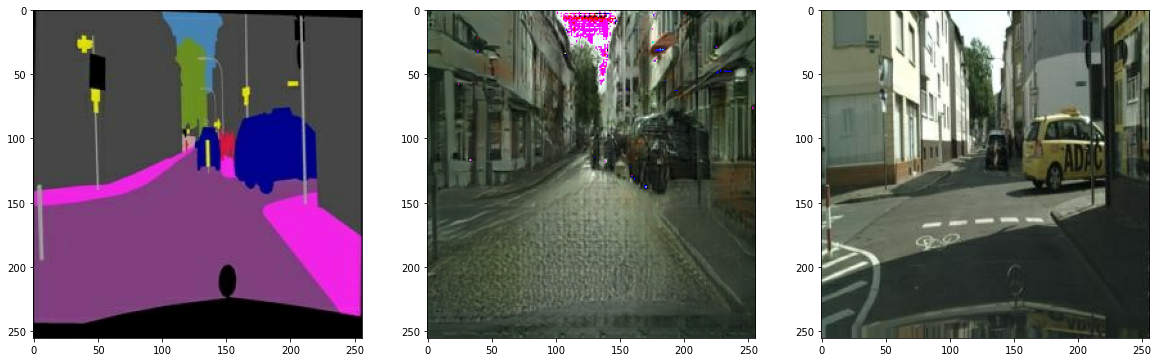

In [56]:
test_ind = 0

f = val_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize = (20, 10))

plt.subplot(1, 3, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 3, 2)
plt.imshow(pred[0])

plt.subplot(1, 3, 3)
plt.imshow(denormalize(colored))

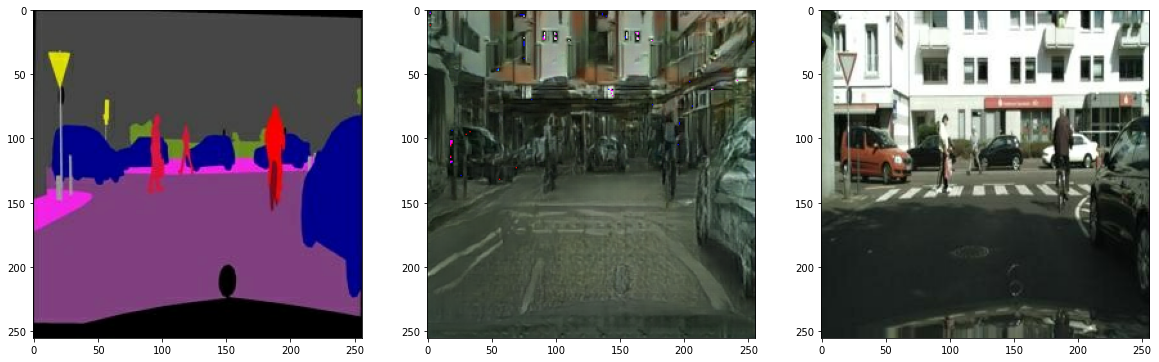

In [57]:
test_ind = 1

f = val_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize = (20, 10))

plt.subplot(1, 3, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 3, 2)
plt.imshow(pred[0])

plt.subplot(1, 3, 3)
plt.imshow(denormalize(colored))

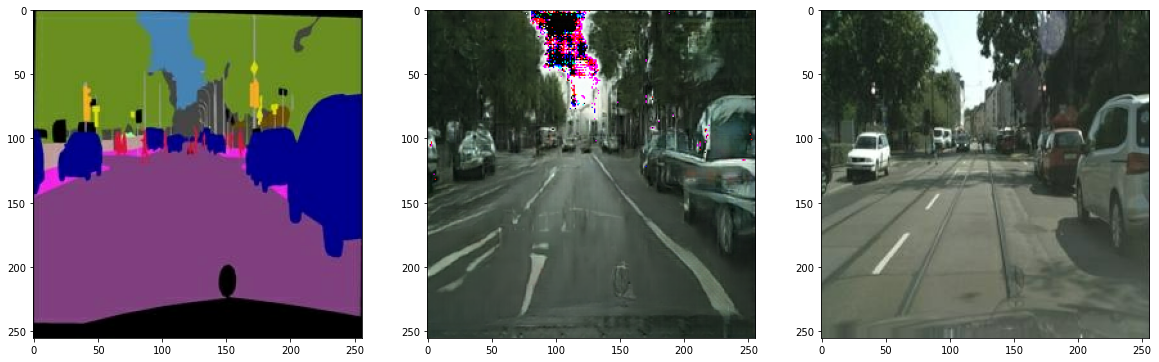

In [58]:
test_ind = 2

f = val_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize = (20, 10))

plt.subplot(1, 3, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 3, 2)
plt.imshow(pred[0])

plt.subplot(1, 3, 3)
plt.imshow(denormalize(colored))

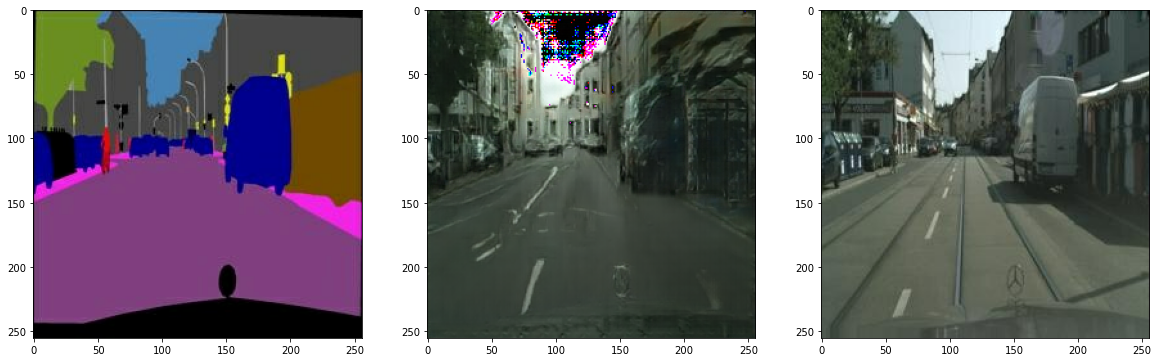

In [59]:
test_ind = 3

f = val_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize = (20, 10))

plt.subplot(1, 3, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 3, 2)
plt.imshow(pred[0])

plt.subplot(1, 3, 3)
plt.imshow(denormalize(colored))

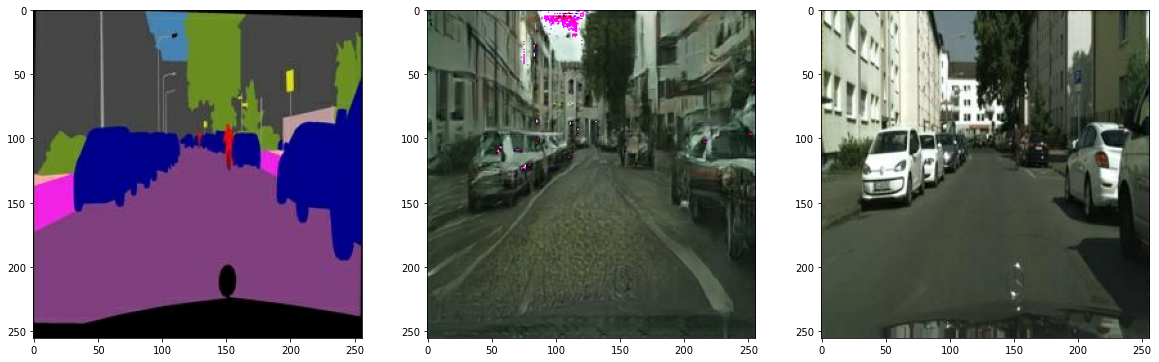

In [60]:
test_ind = 4

f = val_path + os.listdir(val_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize = (20, 10))

plt.subplot(1, 3, 1)
plt.imshow(denormalize(sketch))

plt.subplot(1, 3, 2)
plt.imshow(pred[0])

plt.subplot(1, 3, 3)
plt.imshow(denormalize(colored))

## 회고록

In [ ]:
# 오늘은 GAN을 복습해보고 cGAN이란 모델을 배웠다.
# 처음에는 GAN을 사용하다가 그 다음은 cGAN을 사용하고, 데이터셋은 총 2개(MNIST, 포켓몬스케치)를 사용하여 서로의 차이점과 구현 방법을 배웠다.
# 그리고 프로젝트를 들어가니 포켓몬 스케치를 통해 채색한 것을 그대로 사용하는 듯 했다.
# 단지 포켓몬 데이터는 왼쪽이 스케치, 오른쪽이 채색이라하면 로드 사진은 왼쪽이 채색, 오른쪽이 영역이라 데이터를 분리할 때 코드를 다르게 했다.
# 나머지의 코드를 그대로 사용하니 얼추 돌아가고, valid 데이터도 5개만 있어서 학습한 가중치를 가지고 모델을 시험했다.
# 10 epoch 이상하라해서 150번을 했는데 얼추 도로와 자동차로 보이는 것은 만들었으나 아직 미흡한 것 같다.
# 앞서 500번 학습한 가중치들을 가지고 MNIST를 했던 것 처럼 500번 학습을 하면 어떻게 될지는 궁금하다.
# 해본 결과는 위와 같다. 스케치에 파란색으로 그려진 부분은 보통 하늘인데 이 부분이 약간 분홍색을 띄는 미흡한 점이 보이나,
# 도로나 차선, 자동차, 자전거 타는 사람같은게 조금씩 보인다.